In [24]:
import os
from os.path import join, exists, isfile, realpath, dirname
import argparse
from glob import glob
import random, shutil, json
from math import log10, ceil

import torch.nn as nn
from torch.utils.data import DataLoader, SubsetRandomSampler
import torchvision.models as models
from torch.utils.data.dataset import Subset

import faiss

import netvlad

import torch.optim as optim
from tensorboardX import SummaryWriter

from datetime import datetime
from os import makedirs, remove, chdir, environ

import matplotlib.pyplot as plt

import cv2

import open3d as o3d
import numpy as np
from scipy.spatial.transform import Rotation as R

from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

import pyquaternion as pyq
import math
from tqdm import tqdm

In [20]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"
weight_dir = 'Jun01_22-29-30_vgg16_netvlad'
lidar_map_pcd = None

In [3]:
parser = argparse.ArgumentParser(description='pytorch-NetVlad')
parser.add_argument('--mode', type=str, default='train', help='Mode', choices=['train', 'test', 'cluster'])
parser.add_argument('--batchSize', type=int, default=4, help='Number of triplets (query, pos, negs). Each triplet consists of 12 images.')
parser.add_argument('--cacheBatchSize', type=int, default=24, help='Batch size for caching and testing')
parser.add_argument('--cacheRefreshRate', type=int, default=1000, help='How often to refresh cache, in number of queries. 0 for off')
parser.add_argument('--nEpochs', type=int, default=30, help='number of epochs to train for')
parser.add_argument('--start-epoch', default=0, type=int, metavar='N', help='manual epoch number (useful on restarts)')
parser.add_argument('--nGPU', type=int, default=1, help='number of GPU to use.')
parser.add_argument('--optim', type=str, default='SGD', help='optimizer to use', choices=['SGD', 'ADAM'])
parser.add_argument('--lr', type=float, default=0.0001, help='Learning Rate.')
parser.add_argument('--lrStep', type=float, default=5, help='Decay LR ever N steps.')
parser.add_argument('--lrGamma', type=float, default=0.5, help='Multiply LR by Gamma for decaying.')
parser.add_argument('--weightDecay', type=float, default=0.001, help='Weight decay for SGD.')
parser.add_argument('--momentum', type=float, default=0.9, help='Momentum for SGD.')
parser.add_argument('--nocuda', action='store_true', help='Dont use cuda')
parser.add_argument('--threads', type=int, default=8, help='Number of threads for each data loader to use')
parser.add_argument('--seed', type=int, default=123, help='Random seed to use.')
parser.add_argument('--dataPath', type=str, default='/home/ubuntu/Desktop/pytorch-NetVlad/data/', help='Path for centroid data.')
parser.add_argument('--runsPath', type=str, default='/home/ubuntu/Desktop/pytorch-NetVlad/runs/', help='Path to save runs to.')
parser.add_argument('--savePath', type=str, default='checkpoints', help='Path to save checkpoints to in logdir. Default=checkpoints/')
parser.add_argument('--cachePath', type=str, default='/tmp', help='Path to save cache to.')
parser.add_argument('--resume', type=str, default='', help='Path to load checkpoint from, for resuming training or testing.')
parser.add_argument('--ckpt', type=str, default='latest', help='Resume from latest or best checkpoint.', choices=['latest', 'best'])
parser.add_argument('--evalEvery', type=int, default=1, help='Do a validation set run, and save, every N epochs.')
parser.add_argument('--patience', type=int, default=10, help='Patience for early stopping. 0 is off.')
parser.add_argument('--dataset', type=str, default='pittsburgh', help='Dataset to use', choices=['pittsburgh','naverlabs'])
parser.add_argument('--arch', type=str, default='vgg16', help='basenetwork to use', choices=['vgg16', 'alexnet'])
parser.add_argument('--vladv2', action='store_true', help='Use VLAD v2')
parser.add_argument('--pooling', type=str, default='netvlad', help='type of pooling to use', choices=['netvlad', 'max', 'avg'])
parser.add_argument('--num_clusters', type=int, default=64, help='Number of NetVlad clusters. Default=64')
parser.add_argument('--margin', type=float, default=0.1, help='Margin for triplet loss. Default=0.1')
parser.add_argument('--split', type=str, default='val', help='Data split to use for testing. Default is val', choices=['test', 'test250k', 'train', 'val'])
parser.add_argument('--fromscratch', action='store_true', help='Train from scratch rather than using pretrained models')

_StoreTrueAction(option_strings=['--fromscratch'], dest='fromscratch', nargs=0, const=True, default=False, type=None, choices=None, help='Train from scratch rather than using pretrained models', metavar=None)

In [4]:
import torch
import torchvision.transforms as transforms
import torch.utils.data as data

from os.path import join, exists
from scipy.io import loadmat
import numpy as np
from collections import namedtuple
from PIL import Image

from sklearn.neighbors import NearestNeighbors
import h5py

db_dir = '/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/'
q_dir = '/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/'

def input_transform():
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225]),
    ])

def get_whole_test_set():
    return WholeDatasetFromStruct(input_transform=input_transform(), mode='test')

dbStruct = namedtuple('dbStruct', ['whichSet', 'dataset', 
                                   'db_image', 'db_utms', 'db_num', 'db_full_pose',
                                   'q_image', 'q_utms', 'q_num', 'q_full_pose',
                                   'posDistThr', 'posDistSqThr', 'nonTrivPosDistSqThr'])

class WholeDatasetFromStruct(data.Dataset):
    def __init__(self, input_transform=None, onlyDB=False, mode='train'):
        super().__init__()

        self.input_transform = input_transform

        self.dbStruct = my_parse_dbStruct(mode)
        self.images = [join(db_dir, dbIm) for dbIm in self.dbStruct.db_image]
        if not onlyDB:
            self.images += [join(q_dir, qIm) for qIm in self.dbStruct.q_image]

        self.whichSet = self.dbStruct.whichSet
        self.dataset = self.dbStruct.dataset

        self.positives = None
        self.distances = None

    def __getitem__(self, index):
        img = Image.open(self.images[index])
        img = img.resize((640, 480))

        if self.input_transform:
            img = self.input_transform(img)

        return img, index

    def __len__(self):
        return len(self.images)

In [5]:
def my_parse_dbStruct(_whichSet='train'):

    whichSet = _whichSet
    dataset = 'naverlabs'
    db_image_path = os.path.join(db_dir, 'images')
    db_image_files_list = []
    db_image_files_list.append(sorted(glob(os.path.join(db_image_path, '22970285_*.jpg'))))
    db_image_files_list.append(sorted(glob(os.path.join(db_image_path, '22970286_*.jpg'))))
    db_image_files_list.append(sorted(glob(os.path.join(db_image_path, '22970288_*.jpg'))))
    db_image_files_list.append(sorted(glob(os.path.join(db_image_path, '22970289_*.jpg'))))
    db_image_files_list.append(sorted(glob(os.path.join(db_image_path, '22970290_*.jpg'))))
    db_image_files_list.append(sorted(glob(os.path.join(db_image_path, '22970291_*.jpg'))))
    db_image_files_list.append(sorted(glob(os.path.join(db_image_path, 'AC01324954_*.jpg'))))
    db_image_files_list.append(sorted(glob(os.path.join(db_image_path, 'AC01324955_*.jpg'))))
    db_image_files_list.append(sorted(glob(os.path.join(db_image_path, 'AC01324968_*.jpg'))))
    db_image_files_list.append(sorted(glob(os.path.join(db_image_path, 'AC01324969_*.jpg'))))
    db_image_files = np.hstack(db_image_files_list)
    
    db_full_images = [os.path.join('images', db_image_file.split('/')[-1]) for db_image_file in db_image_files]
    
    db_gt_path = os.path.join(db_dir, 'groundtruth.hdf5')

    db_full_pose = []
    with h5py.File(db_gt_path, "r") as f:
        db_full_pose.append(np.array(f['22970285_pose']))
        db_full_pose.append(np.array(f['22970286_pose']))
        db_full_pose.append(np.array(f['22970288_pose']))
        db_full_pose.append(np.array(f['22970289_pose']))
        db_full_pose.append(np.array(f['22970290_pose']))
        db_full_pose.append(np.array(f['22970291_pose']))
        db_full_pose.append(np.array(f['AC01324954_pose']))
        db_full_pose.append(np.array(f['AC01324955_pose']))
        db_full_pose.append(np.array(f['AC01324968_pose']))
        db_full_pose.append(np.array(f['AC01324969_pose']))

        db_full_pose = np.vstack(db_full_pose)
    
    db_full_utms = db_full_pose[:,:2]
    
    db_image = db_full_images
    db_utms = db_full_utms
    db_num = len(db_image)
    db_full_pose = db_full_pose
    
    q_image_path = os.path.join(q_dir, 'images')
    q_image_files_list = []
    q_image_files_list.append(sorted(glob(os.path.join(q_image_path, '40027089*.jpg'))))
    q_image_files_list.append(sorted(glob(os.path.join(q_image_path, '40029628*.jpg'))))
    q_image_files_list.append(sorted(glob(os.path.join(q_image_path, '40030065*.jpg'))))
    q_image_files_list.append(sorted(glob(os.path.join(q_image_path, '40031951*.jpg'))))
    q_image_files_list.append(sorted(glob(os.path.join(q_image_path, '40033113*.jpg'))))
    q_image_files_list.append(sorted(glob(os.path.join(q_image_path, '40033116*.jpg'))))
    q_image_files_list.append(sorted(glob(os.path.join(q_image_path, 'AC01324954*.jpg'))))
    q_image_files_list.append(sorted(glob(os.path.join(q_image_path, 'AC01324955*.jpg'))))
    q_image_files_list.append(sorted(glob(os.path.join(q_image_path, 'AC01324968*.jpg'))))
    q_image_files_list.append(sorted(glob(os.path.join(q_image_path, 'AC01324969*.jpg'))))
    q_image_files = np.hstack(q_image_files_list)
    
    q_full_images = [os.path.join('images', q_image_file.split('/')[-1]) for q_image_file in q_image_files]
    
    q_image = q_full_images
    q_utms = None
    q_num = len(q_image)
    q_full_pose = None
    

    return dbStruct(whichSet, dataset, 
                    db_image, db_utms, db_num, db_full_pose,
                    q_image, q_utms, q_num, q_full_pose, 
                    5, 25, 20.0)

In [6]:
opt = parser.parse_args(args=('--dataset=naverlabs --mode=test --resume=runs/%s --split=test' % weight_dir).split(' '))
restore_var = ['lr', 'lrStep', 'lrGamma', 'weightDecay', 'momentum', 
            'runsPath', 'savePath', 'arch', 'num_clusters', 'pooling', 'optim',
            'margin', 'seed', 'patience']

In [7]:
flag_file = join(opt.resume, 'checkpoints', 'flags.json')
if exists(flag_file):
    with open(flag_file, 'r') as f:
        stored_flags = {'--'+k : str(v) for k,v in json.load(f).items() if k in restore_var}
        to_del = []
        for flag, val in stored_flags.items():
            for act in parser._actions:
                if act.dest == flag[2:]:
                    # store_true / store_false args don't accept arguments, filter these 
                    if type(act.const) == type(True):
                        if val == str(act.default):
                            to_del.append(flag)
                        else:
                            stored_flags[flag] = ''
        for flag in to_del: del stored_flags[flag]

        train_flags = [x for x in list(sum(stored_flags.items(), tuple())) if len(x) > 0]
        print('Restored flags:', train_flags)
        opt = parser.parse_args(train_flags, namespace=opt)

Restored flags: ['--optim', 'SGD', '--lr', '0.0001', '--lrStep', '5', '--lrGamma', '0.5', '--weightDecay', '0.001', '--momentum', '0.9', '--seed', '123', '--runsPath', '/home/ubuntu/Desktop/pytorch-NetVlad/runs/', '--savePath', '/home/ubuntu/Desktop/pytorch-NetVlad/runs/Jun01_22-29-30_vgg16_netvlad/checkpoints', '--patience', '10', '--arch', 'vgg16', '--pooling', 'netvlad', '--num_clusters', '64', '--margin', '0.1']


In [8]:
print(opt)

Namespace(arch='vgg16', batchSize=4, cacheBatchSize=24, cachePath='/tmp', cacheRefreshRate=1000, ckpt='latest', dataPath='/home/ubuntu/Desktop/pytorch-NetVlad/data/', dataset='naverlabs', evalEvery=1, fromscratch=False, lr=0.0001, lrGamma=0.5, lrStep=5.0, margin=0.1, mode='test', momentum=0.9, nEpochs=30, nGPU=1, nocuda=False, num_clusters=64, optim='SGD', patience=10, pooling='netvlad', resume='runs/Jun01_22-29-30_vgg16_netvlad', runsPath='/home/ubuntu/Desktop/pytorch-NetVlad/runs/', savePath='/home/ubuntu/Desktop/pytorch-NetVlad/runs/Jun01_22-29-30_vgg16_netvlad/checkpoints', seed=123, split='test', start_epoch=0, threads=8, vladv2=False, weightDecay=0.001)


In [9]:
cuda = True
device = torch.device("cuda")

random.seed(opt.seed)
np.random.seed(opt.seed)
torch.manual_seed(opt.seed)
torch.cuda.manual_seed(opt.seed)

In [10]:
whole_test_set = get_whole_test_set()

In [12]:
encoder_dim = 512
encoder = models.vgg16(pretrained=True)
# capture only feature part and remove last relu and maxpool
layers = list(encoder.features.children())[:-2]

# if using pretrained then only train conv5_1, conv5_2, and conv5_3
for l in layers[:-5]: 
    for p in l.parameters():
        p.requires_grad = False

In [13]:
encoder = nn.Sequential(*layers)
model = nn.Module() 
model.add_module('encoder', encoder)

In [14]:
net_vlad = netvlad.NetVLAD(num_clusters=opt.num_clusters, dim=encoder_dim, vladv2=opt.vladv2)
if not opt.resume: 
    if opt.mode.lower() == 'train':
        initcache = join(opt.dataPath, 'centroids', opt.arch + '_' + train_set.dataset + '_' + str(opt.num_clusters) +'_desc_cen.hdf5')
    else:
        initcache = join(opt.dataPath, 'centroids', opt.arch + '_' + whole_test_set.dataset + '_' + str(opt.num_clusters) +'_desc_cen.hdf5')

    if not exists(initcache):
        raise FileNotFoundError('Could not find clusters, please run with --mode=cluster before proceeding')

    with h5py.File(initcache, mode='r') as h5: 
        clsts = h5.get("centroids")[...]
        traindescs = h5.get("descriptors")[...]
        net_vlad.init_params(clsts, traindescs) 
        del clsts, traindescs

model.add_module('pool', net_vlad)

In [15]:
if opt.ckpt.lower() == 'latest':
    resume_ckpt = join(opt.resume, 'checkpoints', 'checkpoint.pth.tar')
elif opt.ckpt.lower() == 'best':
    resume_ckpt = join(opt.resume, 'checkpoints', 'model_best.pth.tar')

if isfile(resume_ckpt):
    print("=> loading checkpoint '{}'".format(resume_ckpt))
    checkpoint = torch.load(resume_ckpt, map_location=lambda storage, loc: storage)
    opt.start_epoch = checkpoint['epoch']
    best_metric = checkpoint['best_score']
    model.load_state_dict(checkpoint['state_dict'])
    model = model.to(device)
    if opt.mode == 'train':
        optimizer.load_state_dict(checkpoint['optimizer'])
    print("=> loaded checkpoint '{}' (epoch {})"
          .format(resume_ckpt, checkpoint['epoch']))
else:
    print("=> no checkpoint found at '{}'".format(resume_ckpt))

=> loading checkpoint 'runs/Jun01_22-29-30_vgg16_netvlad/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'runs/Jun01_22-29-30_vgg16_netvlad/checkpoints/checkpoint.pth.tar' (epoch 15)


# Calculate the prediction

In [17]:
test_set = whole_test_set
test_data_loader = DataLoader(dataset=test_set, num_workers=opt.threads, batch_size=opt.cacheBatchSize, shuffle=True, pin_memory=cuda)

In [18]:
model.eval()
with torch.no_grad():
    print('====> Extracting Features')
    pool_size = encoder_dim
    if opt.pooling.lower() == 'netvlad': pool_size *= opt.num_clusters
    dbFeat = np.empty((len(test_set), pool_size))

    for iteration, (input, indices) in enumerate(test_data_loader, 1):
        input = input.to(device)
        image_encoding = model.encoder(input)
        vlad_encoding = model.pool(image_encoding) 

        dbFeat[indices.detach().numpy(), :] = vlad_encoding.detach().cpu().numpy()
        if iteration % 50 == 0 or len(test_data_loader) <= 10:
            print("==> Batch ({}/{})".format(iteration, len(test_data_loader)), flush=True)

        del input, image_encoding, vlad_encoding
del test_data_loader

====> Extracting Features
==> Batch (50/983)
==> Batch (100/983)
==> Batch (150/983)
==> Batch (200/983)
==> Batch (250/983)
==> Batch (300/983)
==> Batch (350/983)
==> Batch (400/983)
==> Batch (450/983)
==> Batch (500/983)
==> Batch (550/983)
==> Batch (600/983)
==> Batch (650/983)
==> Batch (700/983)
==> Batch (750/983)
==> Batch (800/983)
==> Batch (850/983)
==> Batch (900/983)
==> Batch (950/983)


In [19]:
# extracted for both db and query, now split in own sets
qFeat = dbFeat[test_set.dbStruct.db_num:].astype('float32')
dbFeat = dbFeat[:test_set.dbStruct.db_num].astype('float32')

print('====> Building faiss index')
faiss_index = faiss.IndexFlatL2(pool_size)
faiss_index.add(dbFeat)

print('====> Calculating recall @ N')
n_values = [1,5,10,20]

_, predictions = faiss_index.search(qFeat, max(n_values)) 

====> Building faiss index
====> Calculating recall @ N


# Place Recognition

In [54]:
def placeRecognition(query_idx, rank=0):
    db_image_data_path = db_dir
    q_image_data_path = q_dir
    
#     plt.figure()
    query_image_full_path = os.path.join(q_image_data_path, test_set.dbStruct.q_image[query_idx])
    print(query_image_full_path)
    query_img = Image.open(query_image_full_path)
#     plt.imshow(query_img)
    query_pose = None
#     print(query_pose)

#     plt.figure()
    pred_image_full_path = os.path.join(db_image_data_path, test_set.dbStruct.db_image[predictions[query_idx][rank]])
    print(pred_image_full_path)
    pred_img = Image.open(pred_image_full_path) 
#     plt.imshow(pred_img)
    pred_pose = test_set.dbStruct.db_full_pose[predictions[query_idx][rank]]
#     print(pred_pose)
    
    return query_image_full_path, query_img, None, pred_image_full_path, pred_img, pred_pose

# Lidar map projection

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000560.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395546417000.jpg


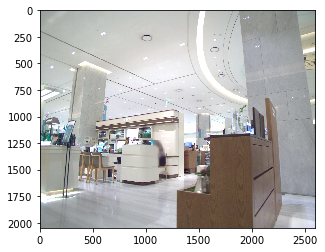

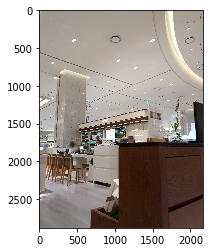

In [22]:
query_image_full_path, query_img, query_pose, pred_image_full_path, pred_img, pred_pose = placeRecognition(530)

In [25]:
if lidar_map_pcd is None:
    lidar_map_pcd = o3d.io.read_point_cloud(os.path.join(db_dir, 'map.pcd'))
    pcd_tree = o3d.geometry.KDTreeFlann(lidar_map_pcd)

In [26]:
[k, idx, _] = pcd_tree.search_radius_vector_3d(pred_pose[:3], 10.0)
print('the number of neighbors: ', k)

the number of neighbors:  4731967


In [27]:
def projection(img, _points, _Rt, thickness=1):
    
    if (img.size[0] > img.size[1]):
        _A = np.array([[1725.842032333, 0.0, 1024.0],
                      [0.0, 1725.842032333, 768.0],
                      [0.0, 0.0, 1.0]])
    else:
        _A = np.array([[2192.6345, 0.0, 1080.0],
                      [0.0, 2192.6345, 1440.0],
                      [0.0, 0.0, 1.0]])
    
    projected_img = np.ones_like(img)*np.inf
    agumented_points = np.c_[_points,np.ones(_points.shape[0])]
    transformed_points = np.linalg.inv(_Rt)@np.transpose(agumented_points)
    projected_points = _A@transformed_points[:3,:]
    hnormalized_points = projected_points/projected_points[2,:]      
    
    for i, hnormalized_point in enumerate(np.transpose(hnormalized_points)):  
        t_y = int(hnormalized_point[1])
        t_x = int(hnormalized_point[0])
        
        if (0 <= t_x and t_x < img.size[0] and 0 <= t_y and t_y < img.size[1]):
            pre_val = projected_img[t_y, t_x]
            new_val = transformed_points[:3,i]
        
            if (0 < new_val[2] and new_val[2] < pre_val[2]):
                projected_img[t_y-thickness:t_y+thickness, t_x-thickness:t_x+thickness] = new_val

    return projected_img

In [29]:
pred_Rt = np.eye(4)
pred_Rt[:3,3] = pred_pose[:3]
(pred_qw, pred_qx, pred_qy, pred_qz) = pred_pose[3:]
pred_Rt[:3,:3] = R.from_quat([pred_qx,pred_qy,pred_qz,pred_qw]).as_matrix()

radius_points = np.asarray(lidar_map_pcd.points)[idx] 
pred_projected_img = projection(pred_img, radius_points, pred_Rt, thickness=3)

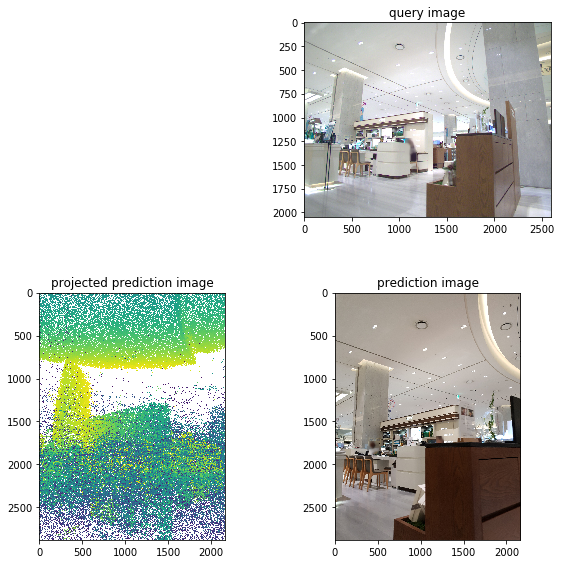

In [30]:
fig = plt.figure()

# ax1 = fig.add_subplot(2, 3, 1)
# ax1.imshow(GT_projected_img[:,:,2])
# ax1.title.set_text('groundtruth projected image')
ax2 = fig.add_subplot(2, 3, 2)
ax2.imshow(query_img)
ax2.title.set_text('query image')
# ax3 = fig.add_subplot(2, 3, 3)
# ax3.imshow(GT_blended_img)

ax4 = fig.add_subplot(2, 3, 4)
ax4.imshow(pred_projected_img[:,:,2])
ax4.title.set_text('projected prediction image')
ax5 = fig.add_subplot(2, 3, 5)
ax5.imshow(pred_img)
ax5.title.set_text('prediction image')
# ax6 = fig.add_subplot(2, 3, 6)
# ax6.imshow(pred_blended_img)

plt.show()

# Superpoint feature extraction and matching

In [31]:
sys.path.append("/home/ubuntu/Desktop/SuperPoint-VO/")

In [32]:
from sp_extractor import SuperPointFrontend, PointTracker
from norm_visual_odometry import PinholeCamera, VisualOdometry

In [33]:
class SP_VisualOdometry:
    def __init__(self):
        self.frame_stage = 0
        self.cam = None
        self.new_frame = None
        self.last_frame = None
        self.cur_R = None
        self.cur_t = None
        self.px_ref = None
        self.px_cur = None
        self.focal = None
        self.pp = None
        self.trueX, self.trueY, self.trueZ = 0, 0, 0
        self.detector = SuperPointFrontend(weights_path="/home/ubuntu/Desktop/SuperPoint-VO/weights/superpoint_v1.pth",
                                           nms_dist=4,
                                           conf_thresh=0.015,
                                           nn_thresh=0.7,
                                           cuda=True)
        self.tracker = PointTracker(max_length=2, nn_thresh=self.detector.nn_thresh)

    def featureTracking(self, new_frame):
        pts, desc, heatmap = self.detector.run(new_frame)
        # Add points and descriptors to the tracker.
        self.tracker.update(pts, desc)
        # Get tracks for points which were match successfully across all frames.
        tracks = self.tracker.get_tracks(min_length=1)
        # Normalize track scores to [0,1].
        tracks[:, 1] /= float(self.detector.nn_thresh)
        kp1, kp2 = self.tracker.draw_tracks(tracks)
        return kp1, kp2

In [34]:
sp_vo = SP_VisualOdometry()

query_img_sp = cv2.imread(query_image_full_path)
pred_img_sp = cv2.imread(pred_image_full_path)

sp_vo.featureTracking(query_img_sp)
px_query, px_pred = sp_vo.featureTracking(pred_img_sp)
curr_size = px_pred.shape[0]

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


In [35]:
points_2d = []
points_3d = []
for corr_idx in range(curr_size):
    if (not np.array_equal(pred_projected_img[int(px_pred[corr_idx][1]), int(px_pred[corr_idx][0])], np.ones(3)*np.inf)):
        points_2d.append([px_query[corr_idx][0],px_query[corr_idx][1]])
        points_3d.append(pred_projected_img[int(px_pred[corr_idx][1]), int(px_pred[corr_idx][0])])
        
points_2d = np.asarray(points_2d, dtype=np.float32)
points_3d = np.asarray(points_3d, dtype=np.float32)

In [39]:
A1 = np.array([[1716.28280, 0.0, 1299.03953],
              [0.0, 1713.79148, 1013.52990],
              [0.0, 0.0, 1.0]])
dist_coeff1 = (-0.2032717, 0.2402597, -0.0005943499, -0.002147060, -0.1755963)

A2 = np.array([[2192.6345, 0.0, 1080.0],
              [0.0, 2192.6345, 1440.0],
              [0.0, 0.0, 1.0]])
dist_coeff2 = (0.309526634993, -1.68546591669, 0.000516016398484, 0.000304875649237, 2.77731885597)

if query_img.size[0] > query_img.size[1]:
    retval, rvec, tvec, inliers = cv2.solvePnPRansac(points_3d, points_2d, A1, dist_coeff1)
else:
    retval, rvec, tvec, inliers = cv2.solvePnPRansac(points_3d, points_2d, A2, dist_coeff2)

rotation_matrix = np.zeros(shape=(3,3))
cv2.Rodrigues(rvec, rotation_matrix)
    
print(retval)
print(tvec)
print(rvec)

True
[[0.38751268]
 [0.00966285]
 [0.5779232 ]]
[[-0.00863415]
 [-0.24967826]
 [ 0.05430038]]


In [40]:
query_rot = pred_Rt[:3,:3]@np.linalg.inv(np.asarray(rotation_matrix))
query_trans = np.transpose(np.asarray(tvec)) + pred_Rt[:3,3]

query_Rt = np.eye(4)
query_Rt[:3,:3] = query_rot
query_Rt[:3,3] = query_trans

In [41]:
query_projected_img = projection(query_img, radius_points, query_Rt, thickness=3)

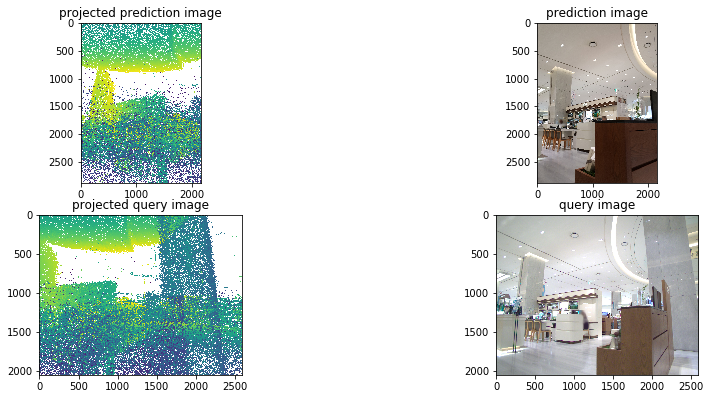

In [42]:
fig = plt.figure()

ax1 = fig.add_subplot(3, 2, 1)
ax1.imshow(pred_projected_img[:,:,2])
ax1.title.set_text('projected prediction image')
ax2 = fig.add_subplot(3, 2, 2)
ax2.imshow(pred_img)
ax2.title.set_text('prediction image')

ax3 = fig.add_subplot(3, 2, 3)
ax3.imshow(query_projected_img[:,:,2])
ax3.title.set_text('projected query image')
ax4 = fig.add_subplot(3, 2, 4)
ax4.imshow(query_img)
ax4.title.set_text('query image')

In [145]:
def VisualLocalization(query_idx):
    query_image_full_path, query_img, query_pose, pred_image_full_path, pred_img, pred_pose = placeRecognition(query_idx)
    [k, idx, _] = pcd_tree.search_radius_vector_3d(pred_pose[:3], 10.0)
    
    pred_Rt = np.eye(4)
    pred_Rt[:3,3] = pred_pose[:3]
    (pred_qw, pred_qx, pred_qy, pred_qz) = pred_pose[3:]
    pred_Rt[:3,:3] = R.from_quat([pred_qx,pred_qy,pred_qz,pred_qw]).as_matrix()

    radius_points = np.asarray(lidar_map_pcd.points)[idx] 
    pred_projected_img = projection(pred_img, radius_points, pred_Rt, thickness=3)
    
    sp_vo = SP_VisualOdometry()

    query_img_sp = cv2.imread(query_image_full_path)
    pred_img_sp = cv2.imread(pred_image_full_path)

    sp_vo.featureTracking(query_img_sp)
    px_query, px_pred = sp_vo.featureTracking(pred_img_sp)
    curr_size = px_pred.shape[0]
    
    points_2d = []
    points_3d = []
    for corr_idx in range(curr_size):
        if (not np.array_equal(pred_projected_img[int(px_pred[corr_idx][1]), int(px_pred[corr_idx][0])], np.ones(3)*np.inf)):
            points_2d.append([px_query[corr_idx][0],px_query[corr_idx][1]])
            points_3d.append(pred_projected_img[int(px_pred[corr_idx][1]), int(px_pred[corr_idx][0])])

    points_2d = np.asarray(points_2d, dtype=np.float32)
    points_3d = np.asarray(points_3d, dtype=np.float32)
    
    A1 = np.array([[1716.28280, 0.0, 1299.03953],
              [0.0, 1713.79148, 1013.52990],
              [0.0, 0.0, 1.0]])
    dist_coeff1 = (-0.2032717, 0.2402597, -0.0005943499, -0.002147060, -0.1755963)

    A2 = np.array([[2192.6345, 0.0, 1080.0],
                  [0.0, 2192.6345, 1440.0],
                  [0.0, 0.0, 1.0]])
    dist_coeff2 = (0.309526634993, -1.68546591669, 0.000516016398484, 0.000304875649237, 2.77731885597)
    
    if query_img.size[0] > query_img.size[1]:
        retval, rvec, tvec = cv2.solvePnP(points_3d, points_2d, A1, dist_coeff1)
    else:
        retval, rvec, tvec = cv2.solvePnP(points_3d, points_2d, A2, dist_coeff2)

    if retval==False:
        return False, None, None, None
        
    rotation_matrix = np.zeros(shape=(3,3))
    cv2.Rodrigues(rvec, rotation_matrix)
    
    query_rot = pred_Rt[:3,:3]@np.linalg.inv(np.asarray(rotation_matrix))
    query_trans = np.transpose(np.asarray(tvec)) + pred_Rt[:3,3]

    query_Rt = np.eye(4)
    query_Rt[:3,:3] = query_rot
    query_Rt[:3,3] = query_trans
    
    query_projected_img = projection(query_img, radius_points, query_Rt, thickness=3)
    
    result_images = (pred_img, pred_projected_img, query_img, query_projected_img)

    query_quat = R.from_matrix(query_rot).as_quat()
    result_pose = (query_quat,query_trans)
    
    return True, query_image_full_path, result_images, result_pose

In [149]:
ret_val, query_image_full_path , result_images, result_pose = VisualLocalization(73)

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000702.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393922779869.jpg


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


In [150]:
(pred_img, pred_projected_img, query_img, query_projected_img) = result_images

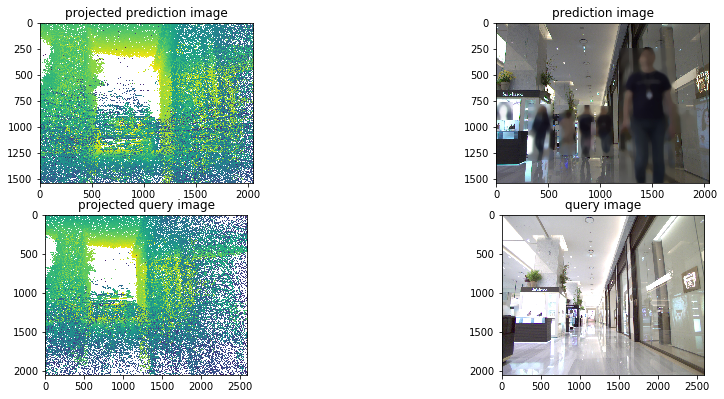

In [151]:
fig = plt.figure()

ax1 = fig.add_subplot(3, 2, 1)
ax1.imshow(pred_projected_img[:,:,2])
ax1.title.set_text('projected prediction image')
ax2 = fig.add_subplot(3, 2, 2)
ax2.imshow(pred_img)
ax2.title.set_text('prediction image')

ax3 = fig.add_subplot(3, 2, 3)
ax3.imshow(query_projected_img[:,:,2])
ax3.title.set_text('projected query image')
ax4 = fig.add_subplot(3, 2, 4)
ax4.imshow(query_img)
ax4.title.set_text('query image')

In [152]:
result_list = []
for query_idx in tqdm(range(test_set.dbStruct.q_num)):
    ret_val, query_image_full_path , result_images, result_pose = VisualLocalization(query_idx)
    
    if ret_val == True:
        (pred_img, pred_projected_img, query_img, query_projected_img) = result_images
        
        temp_dict = {'name': query_image_full_path.split('/')[-1],
                 'qw': result_pose[0][3],
                 'qx': result_pose[0][0],
                 'qy': result_pose[0][1],
                 'qz': result_pose[0][2],
                 'x': result_pose[1][0][0],
                 'y': result_pose[1][0][1],
                 'z': result_pose[1][0][2]}

        result_list.append(temp_dict)

with open('20200602_indoor_submit.json', 'w') as outfile:
    json.dump(result_list, outfile)






  0%|          | 0/1969 [00:00<?, ?it/s]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000002.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393608779869.jpg


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "





  0%|          | 1/1969 [00:13<7:21:20, 13.46s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000010.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394653779869.jpg







  0%|          | 2/1969 [00:36<8:56:54, 16.38s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000037.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555394640779869.jpg







  0%|          | 3/1969 [00:48<8:09:42, 14.95s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000046.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393289779869.jpg







  0%|          | 4/1969 [01:02<8:05:49, 14.83s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000047.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393693779869.jpg







  0%|          | 5/1969 [01:17<8:00:57, 14.69s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000063.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393966779869.jpg







  0%|          | 6/1969 [01:32<8:11:03, 15.01s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000075.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393262779869.jpg







  0%|          | 7/1969 [01:46<7:53:32, 14.48s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000093.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393600779869.jpg







  0%|          | 8/1969 [01:59<7:45:02, 14.23s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000100.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393929779869.jpg







  0%|          | 9/1969 [02:12<7:33:43, 13.89s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000101.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393080779869.jpg







  1%|          | 10/1969 [02:28<7:52:51, 14.48s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000105.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555394956779869.jpg







  1%|          | 11/1969 [02:38<7:02:49, 12.96s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000106.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394012779869.jpg







  1%|          | 12/1969 [02:54<7:36:09, 13.99s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000119.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393219779869.jpg







  1%|          | 13/1969 [03:08<7:36:15, 14.00s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000134.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393708789000.jpg







  1%|          | 14/1969 [03:24<7:54:45, 14.57s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000166.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393754779869.jpg







  1%|          | 15/1969 [03:40<8:12:06, 15.11s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000167.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393452779869.jpg







  1%|          | 16/1969 [03:56<8:12:36, 15.13s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000177.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555395087494000.jpg







  1%|          | 17/1969 [04:09<7:55:22, 14.61s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000179.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393770779869.jpg







  1%|          | 18/1969 [04:27<8:33:15, 15.78s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000186.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393075779869.jpg







  1%|          | 19/1969 [04:42<8:23:27, 15.49s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000212.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555394630412000.jpg







  1%|          | 20/1969 [04:51<7:17:46, 13.48s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000219.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393249779869.jpg







  1%|          | 21/1969 [05:09<7:57:34, 14.71s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000221.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393405779869.jpg







  1%|          | 22/1969 [05:25<8:10:12, 15.11s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000232.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555395174779869.jpg







  1%|          | 23/1969 [05:41<8:19:11, 15.39s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000234.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393437779869.jpg







  1%|          | 24/1969 [05:55<8:05:01, 14.96s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000236.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555392967779869.jpg







  1%|▏         | 25/1969 [06:11<8:20:36, 15.45s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000238.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555394312779869.jpg







  1%|▏         | 26/1969 [06:30<8:54:40, 16.51s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000240.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393978779869.jpg







  1%|▏         | 27/1969 [06:43<8:19:54, 15.45s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000243.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393577779869.jpg







  1%|▏         | 28/1969 [06:57<8:02:16, 14.91s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000259.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555394980779869.jpg







  1%|▏         | 29/1969 [07:10<7:48:01, 14.47s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000264.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555395384779869.jpg







  2%|▏         | 30/1969 [07:22<7:18:50, 13.58s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000266.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393333779869.jpg







  2%|▏         | 31/1969 [07:35<7:11:04, 13.35s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000277.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393737779869.jpg







  2%|▏         | 32/1969 [07:49<7:16:04, 13.51s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000279.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395267498000.jpg







  2%|▏         | 33/1969 [08:06<7:50:46, 14.59s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000313.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555392972779869.jpg







  2%|▏         | 34/1969 [08:21<7:55:08, 14.73s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000318.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555395296779869.jpg







  2%|▏         | 35/1969 [08:39<8:25:56, 15.70s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000335.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393080779869.jpg







  2%|▏         | 36/1969 [08:55<8:32:41, 15.91s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000338.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393081779869.jpg







  2%|▏         | 37/1969 [09:13<8:51:12, 16.50s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000355.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555395373779869.jpg







  2%|▏         | 38/1969 [09:30<8:58:46, 16.74s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000357.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393287779869.jpg







  2%|▏         | 39/1969 [09:46<8:47:13, 16.39s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000366.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394616779869.jpg







  2%|▏         | 40/1969 [09:59<8:18:57, 15.52s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000383.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555395106779869.jpg







  2%|▏         | 41/1969 [10:13<7:59:54, 14.94s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000405.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393472779869.jpg







  2%|▏         | 42/1969 [10:26<7:45:29, 14.49s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000413.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555394339779869.jpg







  2%|▏         | 43/1969 [10:45<8:25:55, 15.76s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000418.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393352779869.jpg







  2%|▏         | 44/1969 [10:57<7:51:54, 14.71s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000419.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555394946779869.jpg







  2%|▏         | 45/1969 [11:08<7:17:28, 13.64s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000423.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393901779869.jpg







  2%|▏         | 46/1969 [11:21<7:09:05, 13.39s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000425.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394261779869.jpg







  2%|▏         | 47/1969 [11:36<7:23:28, 13.84s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000426.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555394245779869.jpg







  2%|▏         | 48/1969 [11:50<7:24:56, 13.90s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000432.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555395098779869.jpg







  2%|▏         | 49/1969 [12:04<7:21:52, 13.81s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000437.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555395397465000.jpg







  3%|▎         | 50/1969 [12:18<7:21:14, 13.80s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000498.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555394266779869.jpg







  3%|▎         | 51/1969 [12:31<7:14:25, 13.59s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000499.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555394339779869.jpg







  3%|▎         | 52/1969 [12:46<7:28:50, 14.05s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000500.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394626779869.jpg







  3%|▎         | 53/1969 [12:55<6:45:00, 12.68s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000507.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394167779869.jpg







  3%|▎         | 54/1969 [13:10<7:04:34, 13.30s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000518.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393143779869.jpg







  3%|▎         | 55/1969 [13:26<7:29:22, 14.09s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000528.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393084779869.jpg







  3%|▎         | 56/1969 [13:42<7:43:30, 14.54s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000541.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555392959475000.jpg







  3%|▎         | 57/1969 [13:58<8:02:01, 15.13s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000542.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393527779869.jpg







  3%|▎         | 58/1969 [14:14<8:12:25, 15.46s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000547.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555395389779869.jpg







  3%|▎         | 59/1969 [14:26<7:31:54, 14.20s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000549.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555395046779869.jpg







  3%|▎         | 60/1969 [14:37<7:04:16, 13.34s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000553.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393977779869.jpg







  3%|▎         | 61/1969 [14:52<7:20:05, 13.84s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000558.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555392969779869.jpg







  3%|▎         | 62/1969 [15:08<7:44:30, 14.61s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000573.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394261779869.jpg







  3%|▎         | 63/1969 [15:25<8:07:55, 15.36s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000591.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555395236779869.jpg







  3%|▎         | 64/1969 [15:40<8:00:17, 15.13s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000594.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555395275779869.jpg







  3%|▎         | 65/1969 [15:56<8:13:14, 15.54s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000595.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555395221779869.jpg







  3%|▎         | 66/1969 [16:13<8:17:37, 15.69s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000599.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393439779869.jpg







  3%|▎         | 67/1969 [16:27<8:07:26, 15.38s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000611.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394031779869.jpg







  3%|▎         | 68/1969 [16:48<8:57:08, 16.95s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000617.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394650779869.jpg







  4%|▎         | 69/1969 [17:05<9:01:48, 17.11s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000630.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555395220796000.jpg







  4%|▎         | 70/1969 [17:21<8:49:21, 16.73s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000644.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555395276779869.jpg







  4%|▎         | 71/1969 [17:37<8:45:41, 16.62s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000656.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393342779869.jpg







  4%|▎         | 72/1969 [17:52<8:24:55, 15.97s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000675.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393936779869.jpg







  4%|▎         | 73/1969 [18:12<9:03:07, 17.19s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000702.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393922779869.jpg







  4%|▍         | 74/1969 [18:27<8:46:17, 16.66s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000716.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393403779869.jpg







  4%|▍         | 75/1969 [18:44<8:41:45, 16.53s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000724.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393064779869.jpg







  4%|▍         | 76/1969 [18:58<8:18:13, 15.79s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000733.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393241779869.jpg







  4%|▍         | 77/1969 [19:14<8:22:38, 15.94s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000735.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393069779869.jpg







  4%|▍         | 78/1969 [19:30<8:27:48, 16.11s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000738.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555395433779869.jpg







  4%|▍         | 79/1969 [19:48<8:41:08, 16.54s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000745.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555395393483000.jpg







  4%|▍         | 80/1969 [20:01<8:08:23, 15.51s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000759.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393604779869.jpg







  4%|▍         | 81/1969 [20:16<7:59:16, 15.23s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000782.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393044779869.jpg







  4%|▍         | 82/1969 [20:32<8:08:16, 15.53s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000831.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393035779869.jpg







  4%|▍         | 83/1969 [20:49<8:18:02, 15.84s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000838.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555395437779869.jpg







  4%|▍         | 84/1969 [21:04<8:14:10, 15.73s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000855.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555394263779869.jpg







  4%|▍         | 85/1969 [21:20<8:14:48, 15.76s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000861.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393421779869.jpg







  4%|▍         | 86/1969 [21:33<7:54:02, 15.10s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000872.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393222779869.jpg







  4%|▍         | 87/1969 [21:49<7:55:50, 15.17s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000874.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555395430779869.jpg







  4%|▍         | 88/1969 [22:07<8:20:39, 15.97s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000878.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393761779869.jpg







  5%|▍         | 89/1969 [22:22<8:14:43, 15.79s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000888.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555395050779869.jpg







  5%|▍         | 90/1969 [22:35<7:48:44, 14.97s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000890.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393080779869.jpg







  5%|▍         | 91/1969 [22:49<7:44:00, 14.82s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000922.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393625779869.jpg







  5%|▍         | 92/1969 [23:05<7:47:29, 14.94s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000925.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393766376000.jpg







  5%|▍         | 93/1969 [23:22<8:06:32, 15.56s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000931.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555392958424000.jpg







  5%|▍         | 94/1969 [23:37<8:05:30, 15.54s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000932.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555394821779869.jpg







  5%|▍         | 95/1969 [23:51<7:53:43, 15.17s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000935.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555395307779869.jpg







  5%|▍         | 96/1969 [24:04<7:33:27, 14.53s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000936.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393647779869.jpg







  5%|▍         | 97/1969 [24:19<7:33:09, 14.52s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000946.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394642779869.jpg







  5%|▍         | 98/1969 [24:30<7:04:18, 13.61s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000951.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555395434779869.jpg







  5%|▌         | 99/1969 [24:45<7:15:53, 13.99s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000953.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555395269779869.jpg







  5%|▌         | 100/1969 [25:00<7:20:34, 14.14s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000000965.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555392977779869.jpg







  5%|▌         | 101/1969 [25:17<7:45:24, 14.95s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001001.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555394642779869.jpg







  5%|▌         | 102/1969 [25:28<7:10:33, 13.84s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001010.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393383779869.jpg







  5%|▌         | 103/1969 [25:44<7:31:52, 14.53s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001022.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555395383779869.jpg







  5%|▌         | 104/1969 [25:58<7:21:51, 14.22s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001026.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555395423779869.jpg







  5%|▌         | 105/1969 [26:13<7:33:02, 14.58s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001027.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393194779869.jpg







  5%|▌         | 106/1969 [26:31<8:08:57, 15.75s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001029.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555395175779869.jpg







  5%|▌         | 107/1969 [26:46<8:01:18, 15.51s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001030.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395388421000.jpg







  5%|▌         | 108/1969 [27:00<7:46:14, 15.03s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001043.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555395397465000.jpg







  6%|▌         | 109/1969 [27:15<7:39:15, 14.81s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001054.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393501779869.jpg







  6%|▌         | 110/1969 [27:31<7:50:35, 15.19s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001060.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394636779869.jpg







  6%|▌         | 111/1969 [27:40<6:54:39, 13.39s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001072.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555392967779869.jpg







  6%|▌         | 112/1969 [27:56<7:17:12, 14.13s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001086.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393951779869.jpg







  6%|▌         | 113/1969 [28:12<7:33:51, 14.67s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001088.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393573779869.jpg







  6%|▌         | 114/1969 [28:26<7:30:56, 14.59s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001104.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555395309779869.jpg







  6%|▌         | 115/1969 [28:39<7:16:03, 14.11s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001106.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555395561779869.jpg







  6%|▌         | 116/1969 [28:54<7:21:16, 14.29s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001107.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394653779869.jpg







  6%|▌         | 117/1969 [29:10<7:36:48, 14.80s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001111.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555394277779869.jpg







  6%|▌         | 118/1969 [29:24<7:28:07, 14.53s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001125.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555395183779869.jpg







  6%|▌         | 119/1969 [29:37<7:19:15, 14.25s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001140.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393262779869.jpg







  6%|▌         | 120/1969 [29:53<7:28:33, 14.56s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001143.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555394951779869.jpg







  6%|▌         | 121/1969 [30:04<6:58:01, 13.57s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001148.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555394336779869.jpg







  6%|▌         | 122/1969 [30:20<7:25:28, 14.47s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001159.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555394946779869.jpg







  6%|▌         | 123/1969 [30:32<6:57:37, 13.57s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001161.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394261779869.jpg







  6%|▋         | 124/1969 [30:46<7:01:58, 13.72s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001166.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393649779869.jpg







  6%|▋         | 125/1969 [31:04<7:45:45, 15.15s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001171.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394017779869.jpg







  6%|▋         | 126/1969 [31:25<8:34:33, 16.75s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001181.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555395071779869.jpg







  6%|▋         | 127/1969 [31:41<8:28:10, 16.55s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001198.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394961779869.jpg







  7%|▋         | 128/1969 [31:53<7:45:34, 15.17s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001201.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555394978779869.jpg







  7%|▋         | 129/1969 [32:06<7:25:57, 14.54s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001204.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555394948779869.jpg







  7%|▋         | 130/1969 [32:18<6:59:46, 13.70s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001205.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555395389779869.jpg







  7%|▋         | 131/1969 [32:30<6:43:06, 13.16s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001217.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393281779869.jpg







  7%|▋         | 132/1969 [32:47<7:20:14, 14.38s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001226.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555395233779869.jpg







  7%|▋         | 133/1969 [33:02<7:23:05, 14.48s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001233.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393268779869.jpg







  7%|▋         | 134/1969 [33:18<7:36:53, 14.94s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001238.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393986779869.jpg







  7%|▋         | 135/1969 [33:30<7:14:57, 14.23s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001256.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555394303779869.jpg







  7%|▋         | 136/1969 [33:48<7:51:18, 15.43s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001257.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394261779869.jpg







  7%|▋         | 137/1969 [34:04<7:52:03, 15.46s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001260.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393993779869.jpg







  7%|▋         | 138/1969 [34:16<7:23:59, 14.55s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001268.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393179779869.jpg







  7%|▋         | 139/1969 [34:33<7:41:55, 15.15s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001280.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393057779869.jpg







  7%|▋         | 140/1969 [34:47<7:32:01, 14.83s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001281.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393206779869.jpg







  7%|▋         | 141/1969 [35:00<7:13:14, 14.22s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001282.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393294779869.jpg







  7%|▋         | 142/1969 [35:13<7:04:47, 13.95s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001283.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555394634419000.jpg







  7%|▋         | 143/1969 [35:23<6:30:29, 12.83s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001293.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555395104779869.jpg







  7%|▋         | 144/1969 [35:38<6:46:10, 13.35s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001304.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393628779869.jpg







  7%|▋         | 145/1969 [35:52<6:57:03, 13.72s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001317.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393910779869.jpg







  7%|▋         | 146/1969 [36:07<7:07:58, 14.09s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001320.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555395218779869.jpg







  7%|▋         | 147/1969 [36:24<7:34:15, 14.96s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001321.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393333779869.jpg







  8%|▊         | 148/1969 [36:36<7:07:25, 14.08s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001322.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394647779869.jpg







  8%|▊         | 149/1969 [36:51<7:10:05, 14.18s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001371.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555394982779869.jpg







  8%|▊         | 150/1969 [37:05<7:09:02, 14.15s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001384.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393131779869.jpg







  8%|▊         | 151/1969 [37:23<7:44:58, 15.35s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001388.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393189779869.jpg







  8%|▊         | 152/1969 [37:40<7:58:44, 15.81s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001422.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393586349000.jpg







  8%|▊         | 153/1969 [37:51<7:19:25, 14.52s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001424.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555395143779869.jpg







  8%|▊         | 154/1969 [38:07<7:28:11, 14.82s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001426.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555395110779869.jpg







  8%|▊         | 155/1969 [38:20<7:09:08, 14.19s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001431.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393965779869.jpg







  8%|▊         | 156/1969 [38:35<7:17:44, 14.49s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001434.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393214779869.jpg







  8%|▊         | 157/1969 [38:46<6:43:20, 13.36s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001440.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393904779869.jpg







  8%|▊         | 158/1969 [39:01<6:58:01, 13.85s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001444.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394113779869.jpg







  8%|▊         | 159/1969 [39:17<7:16:26, 14.47s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001450.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393065779869.jpg







  8%|▊         | 160/1969 [39:32<7:23:09, 14.70s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001458.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555394990779869.jpg







  8%|▊         | 161/1969 [39:46<7:16:17, 14.48s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001472.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393438779869.jpg







  8%|▊         | 162/1969 [40:03<7:45:27, 15.46s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001474.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555394902779869.jpg







  8%|▊         | 163/1969 [40:17<7:30:21, 14.96s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001483.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393981779869.jpg







  8%|▊         | 164/1969 [40:31<7:20:59, 14.66s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001489.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555392914392000.jpg







  8%|▊         | 165/1969 [40:45<7:13:09, 14.41s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001503.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393157779869.jpg







  8%|▊         | 166/1969 [41:03<7:46:09, 15.51s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001513.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394264779869.jpg







  8%|▊         | 167/1969 [41:18<7:35:59, 15.18s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001534.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393447779869.jpg







  9%|▊         | 168/1969 [41:37<8:17:49, 16.59s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001544.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393508779869.jpg







  9%|▊         | 169/1969 [41:57<8:44:51, 17.50s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001545.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393150779869.jpg







  9%|▊         | 170/1969 [42:15<8:50:43, 17.70s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001554.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393127779869.jpg







  9%|▊         | 171/1969 [42:31<8:36:34, 17.24s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001560.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555394951779869.jpg







  9%|▊         | 172/1969 [42:43<7:42:18, 15.44s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001561.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555395268779869.jpg







  9%|▉         | 173/1969 [42:59<7:55:13, 15.88s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001568.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393264779869.jpg







  9%|▉         | 174/1969 [43:15<7:47:51, 15.64s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001575.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555394963779869.jpg







  9%|▉         | 175/1969 [43:29<7:39:16, 15.36s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001584.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395390496000.jpg







  9%|▉         | 176/1969 [43:41<7:02:52, 14.15s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001585.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393979779869.jpg







  9%|▉         | 177/1969 [43:53<6:50:49, 13.76s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001595.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555395276501000.jpg







  9%|▉         | 178/1969 [44:12<7:35:20, 15.25s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001596.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393986779869.jpg







  9%|▉         | 179/1969 [44:24<7:04:11, 14.22s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001611.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393704779869.jpg







  9%|▉         | 180/1969 [44:40<7:23:05, 14.86s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001628.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393703448000.jpg







  9%|▉         | 181/1969 [44:57<7:41:34, 15.49s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001640.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393136779869.jpg







  9%|▉         | 182/1969 [45:15<7:56:36, 16.00s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001664.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393615779869.jpg







  9%|▉         | 183/1969 [45:28<7:32:27, 15.20s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001666.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393951779869.jpg







  9%|▉         | 184/1969 [45:45<7:51:27, 15.85s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001680.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555394630478000.jpg







  9%|▉         | 185/1969 [45:54<6:44:01, 13.59s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001682.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555394945779869.jpg







  9%|▉         | 186/1969 [46:07<6:42:07, 13.53s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001704.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393439779869.jpg







  9%|▉         | 187/1969 [46:23<7:05:18, 14.32s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001714.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393769779869.jpg







 10%|▉         | 188/1969 [46:40<7:27:19, 15.07s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001731.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393471779869.jpg







 10%|▉         | 189/1969 [46:54<7:21:54, 14.90s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001733.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393241779869.jpg







 10%|▉         | 190/1969 [47:12<7:49:38, 15.84s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001738.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555395544439000.jpg







 10%|▉         | 191/1969 [47:31<8:09:36, 16.52s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001739.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555394805779869.jpg







 10%|▉         | 192/1969 [47:47<8:10:47, 16.57s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001743.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393970779869.jpg







 10%|▉         | 193/1969 [48:00<7:40:31, 15.56s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001746.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393439779869.jpg







 10%|▉         | 194/1969 [48:16<7:41:08, 15.59s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001758.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394642779869.jpg







 10%|▉         | 195/1969 [48:31<7:31:32, 15.27s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001759.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393257467000.jpg







 10%|▉         | 196/1969 [48:45<7:26:42, 15.12s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001766.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393044779869.jpg







 10%|█         | 197/1969 [49:01<7:33:47, 15.37s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001768.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393231779869.jpg







 10%|█         | 198/1969 [49:19<7:53:22, 16.04s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001784.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393764779869.jpg







 10%|█         | 199/1969 [49:34<7:40:23, 15.61s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001786.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555395073779869.jpg







 10%|█         | 200/1969 [49:46<7:10:30, 14.60s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001793.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393281779869.jpg







 10%|█         | 201/1969 [50:01<7:13:35, 14.71s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001802.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393260779869.jpg







 10%|█         | 202/1969 [50:15<7:06:43, 14.49s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001805.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555392967779869.jpg







 10%|█         | 203/1969 [50:31<7:19:24, 14.93s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001807.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555395119779869.jpg







 10%|█         | 204/1969 [50:44<7:08:25, 14.56s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001809.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555395366779869.jpg







 10%|█         | 205/1969 [50:59<7:07:54, 14.55s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001826.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393046779869.jpg







 10%|█         | 206/1969 [51:15<7:19:00, 14.94s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001854.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555395232779869.jpg







 11%|█         | 207/1969 [51:29<7:13:17, 14.75s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001873.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393039779869.jpg







 11%|█         | 208/1969 [51:48<7:50:21, 16.03s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001882.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393760779869.jpg







 11%|█         | 209/1969 [52:05<7:55:37, 16.21s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001885.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393549779869.jpg







 11%|█         | 210/1969 [52:22<8:00:43, 16.40s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001893.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393124779869.jpg







 11%|█         | 211/1969 [52:38<8:04:32, 16.54s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001895.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393229779869.jpg







 11%|█         | 212/1969 [52:58<8:30:59, 17.45s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001922.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555394322779869.jpg







 11%|█         | 213/1969 [53:16<8:35:42, 17.62s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001928.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555395268779869.jpg







 11%|█         | 214/1969 [53:37<9:05:34, 18.65s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001931.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393043779869.jpg







 11%|█         | 215/1969 [53:54<8:54:21, 18.28s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001938.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393374779869.jpg







 11%|█         | 216/1969 [54:06<7:57:29, 16.34s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001948.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555395155424000.jpg







 11%|█         | 217/1969 [54:22<7:51:29, 16.15s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001952.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555395087779869.jpg







 11%|█         | 218/1969 [54:34<7:15:10, 14.91s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001963.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393755779869.jpg







 11%|█         | 219/1969 [54:47<6:57:22, 14.31s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001964.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393025779869.jpg







 11%|█         | 220/1969 [55:03<7:12:42, 14.84s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001979.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393770779869.jpg







 11%|█         | 221/1969 [55:18<7:16:03, 14.97s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001986.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393384779869.jpg







 11%|█▏        | 222/1969 [55:31<6:56:09, 14.29s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001992.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393757779869.jpg







 11%|█▏        | 223/1969 [55:45<6:57:36, 14.35s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000001998.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393285779869.jpg







 11%|█▏        | 224/1969 [56:00<7:02:52, 14.54s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000002018.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555394327434000.jpg







 11%|█▏        | 225/1969 [56:17<7:17:07, 15.04s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000002024.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555395417779869.jpg







 11%|█▏        | 226/1969 [56:35<7:44:19, 15.98s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000002029.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393601779869.jpg







 12%|█▏        | 227/1969 [56:48<7:17:30, 15.07s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000002038.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393374779869.jpg







 12%|█▏        | 228/1969 [57:00<6:53:48, 14.26s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000002056.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555392958424000.jpg







 12%|█▏        | 229/1969 [57:16<7:05:09, 14.66s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000002063.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555395081779869.jpg







 12%|█▏        | 230/1969 [57:29<6:51:50, 14.21s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000002065.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555395221779869.jpg







 12%|█▏        | 231/1969 [57:44<6:57:15, 14.40s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000002069.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395276489000.jpg







 12%|█▏        | 232/1969 [58:00<7:12:57, 14.96s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000002075.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393979779869.jpg







 12%|█▏        | 233/1969 [58:14<7:04:00, 14.65s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000002087.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555392918481000.jpg







 12%|█▏        | 234/1969 [58:25<6:36:18, 13.70s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000002093.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555392972779869.jpg







 12%|█▏        | 235/1969 [58:41<6:51:23, 14.24s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000002099.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393758779869.jpg







 12%|█▏        | 236/1969 [58:56<6:56:21, 14.42s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000002103.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393056779869.jpg







 12%|█▏        | 237/1969 [59:11<6:58:57, 14.51s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000002106.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393403779869.jpg







 12%|█▏        | 238/1969 [59:28<7:20:46, 15.28s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000002124.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393786779869.jpg







 12%|█▏        | 239/1969 [59:41<7:05:56, 14.77s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000002134.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555395440779869.jpg







 12%|█▏        | 240/1969 [59:58<7:27:48, 15.54s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40027089_1566000000002137.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555395227779869.jpg







 12%|█▏        | 241/1969 [1:00:16<7:43:06, 16.08s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000007.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555395040779869.jpg







 12%|█▏        | 242/1969 [1:00:32<7:46:15, 16.20s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000011.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393753779869.jpg







 12%|█▏        | 243/1969 [1:00:49<7:48:14, 16.28s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000040.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393456779869.jpg







 12%|█▏        | 244/1969 [1:01:10<8:33:48, 17.87s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000044.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555395556446000.jpg







 12%|█▏        | 245/1969 [1:01:29<8:39:28, 18.08s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000057.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555394634779869.jpg







 12%|█▏        | 246/1969 [1:01:37<7:15:43, 15.17s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000061.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555394979779869.jpg







 13%|█▎        | 247/1969 [1:01:51<7:02:10, 14.71s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000065.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555394906779869.jpg







 13%|█▎        | 248/1969 [1:02:04<6:48:18, 14.23s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000073.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393228779869.jpg







 13%|█▎        | 249/1969 [1:02:22<7:23:08, 15.46s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000074.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393260779869.jpg







 13%|█▎        | 250/1969 [1:02:38<7:22:06, 15.43s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000087.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555395041779869.jpg







 13%|█▎        | 251/1969 [1:02:50<6:57:45, 14.59s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000098.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393988409000.jpg







 13%|█▎        | 252/1969 [1:03:03<6:44:01, 14.12s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000099.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555395235779869.jpg







 13%|█▎        | 253/1969 [1:03:18<6:48:25, 14.28s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000109.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395357405000.jpg







 13%|█▎        | 254/1969 [1:03:33<6:54:33, 14.50s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000118.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555394656779869.jpg







 13%|█▎        | 255/1969 [1:03:48<6:55:19, 14.54s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000132.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395184471000.jpg







 13%|█▎        | 256/1969 [1:04:03<7:00:38, 14.73s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000160.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555394909779869.jpg







 13%|█▎        | 257/1969 [1:04:17<6:54:40, 14.53s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000164.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393990779869.jpg







 13%|█▎        | 258/1969 [1:04:28<6:26:08, 13.54s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000175.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395357405000.jpg







 13%|█▎        | 259/1969 [1:04:42<6:28:07, 13.62s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000180.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393692779869.jpg







 13%|█▎        | 260/1969 [1:04:58<6:47:51, 14.32s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000187.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393268779869.jpg







 13%|█▎        | 261/1969 [1:05:14<7:03:08, 14.86s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000199.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393257779869.jpg







 13%|█▎        | 262/1969 [1:05:29<7:00:03, 14.76s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000204.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393981779869.jpg







 13%|█▎        | 263/1969 [1:05:41<6:39:34, 14.05s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000218.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555395432779869.jpg







 13%|█▎        | 264/1969 [1:05:56<6:48:29, 14.37s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000225.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393984779869.jpg







 13%|█▎        | 265/1969 [1:06:08<6:29:49, 13.73s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000239.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393614779869.jpg







 14%|█▎        | 266/1969 [1:06:22<6:26:06, 13.60s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000242.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555395234779869.jpg







 14%|█▎        | 267/1969 [1:06:37<6:39:04, 14.07s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000278.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393359779869.jpg







 14%|█▎        | 268/1969 [1:06:50<6:29:41, 13.75s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000282.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393709779869.jpg







 14%|█▎        | 269/1969 [1:07:05<6:40:07, 14.12s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000288.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393580779869.jpg







 14%|█▎        | 270/1969 [1:07:18<6:31:02, 13.81s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000296.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393094779869.jpg







 14%|█▍        | 271/1969 [1:07:35<6:59:18, 14.82s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000300.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555395379779869.jpg







 14%|█▍        | 272/1969 [1:07:54<7:33:12, 16.02s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000306.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555395383779869.jpg







 14%|█▍        | 273/1969 [1:08:08<7:19:39, 15.55s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000352.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393403779869.jpg







 14%|█▍        | 274/1969 [1:08:24<7:18:57, 15.54s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000360.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393217779869.jpg







 14%|█▍        | 275/1969 [1:08:40<7:27:28, 15.85s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000363.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555395314779869.jpg







 14%|█▍        | 276/1969 [1:08:54<7:09:39, 15.23s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000395.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395357405000.jpg







 14%|█▍        | 277/1969 [1:09:07<6:51:35, 14.60s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000404.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393757779869.jpg







 14%|█▍        | 278/1969 [1:09:21<6:42:48, 14.29s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000424.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555394320779869.jpg







 14%|█▍        | 279/1969 [1:09:36<6:48:06, 14.49s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000448.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555395074779869.jpg







 14%|█▍        | 280/1969 [1:09:48<6:28:38, 13.81s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000451.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393701779869.jpg







 14%|█▍        | 281/1969 [1:10:03<6:38:22, 14.16s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000462.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395357405000.jpg







 14%|█▍        | 282/1969 [1:10:16<6:28:43, 13.83s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000465.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393128779869.jpg







 14%|█▍        | 283/1969 [1:10:30<6:26:58, 13.77s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000473.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555394821779869.jpg







 14%|█▍        | 284/1969 [1:10:45<6:36:12, 14.11s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000476.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393027779869.jpg







 14%|█▍        | 285/1969 [1:11:02<7:06:39, 15.20s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000486.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555392993779869.jpg







 15%|█▍        | 286/1969 [1:11:18<7:11:02, 15.37s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000489.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555395136779869.jpg







 15%|█▍        | 287/1969 [1:11:36<7:31:45, 16.12s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000516.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393982779869.jpg







 15%|█▍        | 288/1969 [1:11:49<7:02:29, 15.08s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000533.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393040779869.jpg







 15%|█▍        | 289/1969 [1:12:04<7:05:52, 15.21s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000534.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555394614779869.jpg







 15%|█▍        | 290/1969 [1:12:18<6:52:21, 14.74s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000546.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393242779869.jpg







 15%|█▍        | 291/1969 [1:12:35<7:14:53, 15.55s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000568.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555394166779869.jpg







 15%|█▍        | 292/1969 [1:12:52<7:27:36, 16.01s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000570.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393215275000.jpg







 15%|█▍        | 293/1969 [1:13:03<6:45:44, 14.53s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000575.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393647779869.jpg







 15%|█▍        | 294/1969 [1:13:22<7:18:55, 15.72s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000586.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555395115779869.jpg







 15%|█▍        | 295/1969 [1:13:37<7:09:06, 15.38s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000598.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555395053779869.jpg







 15%|█▌        | 296/1969 [1:13:50<6:50:14, 14.71s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000601.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393335779869.jpg







 15%|█▌        | 297/1969 [1:14:03<6:38:54, 14.32s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000612.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395357405000.jpg







 15%|█▌        | 298/1969 [1:14:17<6:37:38, 14.28s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000615.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555394339779869.jpg







 15%|█▌        | 299/1969 [1:14:36<7:16:59, 15.70s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000618.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393931779869.jpg







 15%|█▌        | 300/1969 [1:14:51<7:09:35, 15.44s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000621.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393379779869.jpg







 15%|█▌        | 301/1969 [1:15:04<6:46:31, 14.62s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000624.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395222473000.jpg







 15%|█▌        | 302/1969 [1:15:21<7:09:25, 15.46s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000628.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393490779869.jpg







 15%|█▌        | 303/1969 [1:15:35<6:54:09, 14.92s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000653.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393004779869.jpg







 15%|█▌        | 304/1969 [1:15:51<7:04:40, 15.30s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000668.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555395277779869.jpg







 15%|█▌        | 305/1969 [1:16:06<7:05:05, 15.33s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000672.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393623779869.jpg







 16%|█▌        | 306/1969 [1:16:21<6:57:31, 15.06s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000681.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393268779869.jpg







 16%|█▌        | 307/1969 [1:16:37<7:06:03, 15.38s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000688.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393599779869.jpg







 16%|█▌        | 308/1969 [1:16:51<6:52:10, 14.89s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000717.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393439779869.jpg







 16%|█▌        | 309/1969 [1:17:04<6:41:47, 14.52s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000718.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393981779869.jpg







 16%|█▌        | 310/1969 [1:17:17<6:22:23, 13.83s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000734.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555394942779869.jpg







 16%|█▌        | 311/1969 [1:17:30<6:19:51, 13.75s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000752.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555394000521000.jpg







 16%|█▌        | 312/1969 [1:17:43<6:15:35, 13.60s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000755.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393008779869.jpg







 16%|█▌        | 313/1969 [1:18:00<6:38:12, 14.43s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000777.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555394337507000.jpg







 16%|█▌        | 314/1969 [1:18:17<6:56:38, 15.10s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000781.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393633779869.jpg







 16%|█▌        | 315/1969 [1:18:31<6:52:55, 14.98s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000783.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393068427000.jpg







 16%|█▌        | 316/1969 [1:18:45<6:42:05, 14.59s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000801.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555394946502000.jpg







 16%|█▌        | 317/1969 [1:19:00<6:45:32, 14.73s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000803.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395357405000.jpg







 16%|█▌        | 318/1969 [1:19:16<6:54:59, 15.08s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000805.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393098487000.jpg







 16%|█▌        | 319/1969 [1:19:34<7:19:06, 15.97s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000811.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555394987779869.jpg







 16%|█▋        | 320/1969 [1:19:49<7:13:14, 15.76s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000828.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393193779869.jpg







 16%|█▋        | 321/1969 [1:20:06<7:23:58, 16.16s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000832.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393768779869.jpg







 16%|█▋        | 322/1969 [1:20:22<7:21:13, 16.07s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000843.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393981779869.jpg







 16%|█▋        | 323/1969 [1:20:37<7:10:09, 15.68s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000851.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555392974419000.jpg







 16%|█▋        | 324/1969 [1:20:53<7:13:07, 15.80s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000852.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555395123779869.jpg







 17%|█▋        | 325/1969 [1:21:10<7:19:59, 16.06s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000883.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393402779869.jpg







 17%|█▋        | 326/1969 [1:21:26<7:25:36, 16.27s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000903.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555394325779869.jpg







 17%|█▋        | 327/1969 [1:21:42<7:22:30, 16.17s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000914.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555395544779869.jpg







 17%|█▋        | 328/1969 [1:21:57<7:13:44, 15.86s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000916.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394033779869.jpg







 17%|█▋        | 329/1969 [1:22:13<7:13:15, 15.85s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000929.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555395087421000.jpg







 17%|█▋        | 330/1969 [1:22:27<6:56:03, 15.23s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000943.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555395288779869.jpg







 17%|█▋        | 331/1969 [1:22:44<7:12:30, 15.84s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000952.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393914779869.jpg







 17%|█▋        | 332/1969 [1:22:57<6:44:00, 14.81s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000967.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393757779869.jpg







 17%|█▋        | 333/1969 [1:23:12<6:46:07, 14.89s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000971.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393612779869.jpg







 17%|█▋        | 334/1969 [1:23:25<6:32:34, 14.41s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000975.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393066351000.jpg







 17%|█▋        | 335/1969 [1:23:39<6:30:37, 14.34s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000977.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393994779869.jpg







 17%|█▋        | 336/1969 [1:23:52<6:14:28, 13.76s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000982.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393770779869.jpg







 17%|█▋        | 337/1969 [1:24:08<6:38:14, 14.64s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000000990.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555394942779869.jpg







 17%|█▋        | 338/1969 [1:24:27<7:13:30, 15.95s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001004.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394033779869.jpg







 17%|█▋        | 339/1969 [1:24:45<7:28:05, 16.49s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001012.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555394616779869.jpg







 17%|█▋        | 340/1969 [1:25:02<7:30:28, 16.59s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001040.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393709779869.jpg







 17%|█▋        | 341/1969 [1:25:18<7:29:13, 16.56s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001057.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393716779869.jpg







 17%|█▋        | 342/1969 [1:25:32<7:00:35, 15.51s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001059.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555394894779869.jpg







 17%|█▋        | 343/1969 [1:25:48<7:09:08, 15.84s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001065.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555394169779869.jpg







 17%|█▋        | 344/1969 [1:26:05<7:19:49, 16.24s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001071.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393381779869.jpg







 18%|█▊        | 345/1969 [1:26:19<7:02:49, 15.62s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001073.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555395228779869.jpg







 18%|█▊        | 346/1969 [1:26:35<7:01:05, 15.57s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001079.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555394283432000.jpg







 18%|█▊        | 347/1969 [1:26:52<7:12:13, 15.99s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001101.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395357405000.jpg







 18%|█▊        | 348/1969 [1:27:07<7:06:30, 15.79s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001102.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555394951779869.jpg







 18%|█▊        | 349/1969 [1:27:17<6:14:08, 13.86s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001108.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393617779869.jpg







 18%|█▊        | 350/1969 [1:27:29<6:03:44, 13.48s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001116.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394008779869.jpg







 18%|█▊        | 351/1969 [1:27:46<6:30:19, 14.47s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001131.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393179779869.jpg







 18%|█▊        | 352/1969 [1:28:02<6:41:19, 14.89s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001135.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555394917779869.jpg







 18%|█▊        | 353/1969 [1:28:17<6:39:59, 14.85s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001139.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555394046492000.jpg







 18%|█▊        | 354/1969 [1:28:33<6:53:36, 15.37s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001147.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555395330779869.jpg







 18%|█▊        | 355/1969 [1:28:50<7:05:31, 15.82s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001156.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393653779869.jpg







 18%|█▊        | 356/1969 [1:29:08<7:19:07, 16.33s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001172.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393039779869.jpg







 18%|█▊        | 357/1969 [1:29:22<7:03:41, 15.77s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001182.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555395308486000.jpg







 18%|█▊        | 358/1969 [1:29:36<6:45:15, 15.09s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001187.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555395235779869.jpg







 18%|█▊        | 359/1969 [1:29:51<6:44:59, 15.09s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001196.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555394633779869.jpg







 18%|█▊        | 360/1969 [1:29:59<5:52:17, 13.14s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001199.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395357405000.jpg







 18%|█▊        | 361/1969 [1:30:13<6:00:39, 13.46s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001221.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555395143779869.jpg







 18%|█▊        | 362/1969 [1:30:28<6:09:26, 13.79s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001235.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393647779869.jpg







 18%|█▊        | 363/1969 [1:30:43<6:18:27, 14.14s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001247.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555394289779869.jpg







 18%|█▊        | 364/1969 [1:30:57<6:16:53, 14.09s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001262.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555392963779869.jpg







 19%|█▊        | 365/1969 [1:31:13<6:34:12, 14.75s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001272.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393531779869.jpg







 19%|█▊        | 366/1969 [1:31:31<6:56:54, 15.60s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001277.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555395355480000.jpg







 19%|█▊        | 367/1969 [1:31:47<6:57:55, 15.65s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001291.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555395073319000.jpg







 19%|█▊        | 368/1969 [1:32:03<7:04:50, 15.92s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001295.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393261779869.jpg







 19%|█▊        | 369/1969 [1:32:17<6:48:39, 15.32s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001297.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393706779869.jpg







 19%|█▉        | 370/1969 [1:32:33<6:50:57, 15.42s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001309.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555392970429000.jpg







 19%|█▉        | 371/1969 [1:32:48<6:48:27, 15.34s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001310.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555394265779869.jpg







 19%|█▉        | 372/1969 [1:33:01<6:31:04, 14.69s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001316.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555394339779869.jpg







 19%|█▉        | 373/1969 [1:33:16<6:37:11, 14.93s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001329.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393754779869.jpg







 19%|█▉        | 374/1969 [1:33:32<6:45:23, 15.25s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001345.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393080779869.jpg







 19%|█▉        | 375/1969 [1:33:46<6:31:02, 14.72s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001348.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555394648779869.jpg







 19%|█▉        | 376/1969 [1:33:59<6:19:38, 14.30s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001358.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393006779869.jpg







 19%|█▉        | 377/1969 [1:34:18<6:53:11, 15.57s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001366.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393980779869.jpg







 19%|█▉        | 378/1969 [1:34:30<6:29:05, 14.67s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001370.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394628779869.jpg







 19%|█▉        | 379/1969 [1:34:38<5:35:01, 12.64s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001387.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393079779869.jpg







 19%|█▉        | 380/1969 [1:34:51<5:34:44, 12.64s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001395.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393262779869.jpg







 19%|█▉        | 381/1969 [1:35:04<5:41:27, 12.90s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001397.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555392988779869.jpg







 19%|█▉        | 382/1969 [1:35:20<6:00:28, 13.63s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001414.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555395068779869.jpg







 19%|█▉        | 383/1969 [1:35:35<6:16:41, 14.25s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001417.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555394649779869.jpg







 20%|█▉        | 384/1969 [1:35:49<6:10:43, 14.03s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001430.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393295779869.jpg







 20%|█▉        | 385/1969 [1:36:02<6:02:04, 13.71s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001457.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555395106779869.jpg







 20%|█▉        | 386/1969 [1:36:17<6:14:28, 14.19s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001459.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393766779869.jpg







 20%|█▉        | 387/1969 [1:36:34<6:30:51, 14.82s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001462.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555395223779869.jpg







 20%|█▉        | 388/1969 [1:36:50<6:44:09, 15.34s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001473.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393297779869.jpg







 20%|█▉        | 389/1969 [1:37:06<6:44:53, 15.38s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001495.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393210779869.jpg







 20%|█▉        | 390/1969 [1:37:19<6:26:51, 14.70s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001496.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393079779869.jpg







 20%|█▉        | 391/1969 [1:37:33<6:25:55, 14.67s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001498.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393487779869.jpg







 20%|█▉        | 392/1969 [1:37:48<6:25:33, 14.67s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001504.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555395544779869.jpg







 20%|█▉        | 393/1969 [1:38:08<7:05:36, 16.20s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001509.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555395121779869.jpg







 20%|██        | 394/1969 [1:38:24<7:03:33, 16.14s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001521.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395357405000.jpg







 20%|██        | 395/1969 [1:38:41<7:10:32, 16.41s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001523.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393752779869.jpg







 20%|██        | 396/1969 [1:38:59<7:21:39, 16.85s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001524.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393900779869.jpg







 20%|██        | 397/1969 [1:39:13<6:58:17, 15.97s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001551.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393043779869.jpg







 20%|██        | 398/1969 [1:39:28<6:56:16, 15.90s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001552.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393990779869.jpg







 20%|██        | 399/1969 [1:39:41<6:34:00, 15.06s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001557.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393918779869.jpg







 20%|██        | 400/1969 [1:39:55<6:22:15, 14.62s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001573.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393224779869.jpg







 20%|██        | 401/1969 [1:40:11<6:31:26, 14.98s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001574.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393987779869.jpg







 20%|██        | 402/1969 [1:40:23<6:07:05, 14.06s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001590.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393701779869.jpg







 20%|██        | 403/1969 [1:40:38<6:18:04, 14.49s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001600.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555395225779869.jpg







 21%|██        | 404/1969 [1:40:54<6:28:41, 14.90s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001610.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555394914779869.jpg







 21%|██        | 405/1969 [1:41:07<6:15:38, 14.41s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001643.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555394283432000.jpg







 21%|██        | 406/1969 [1:41:26<6:48:21, 15.68s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001650.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395357405000.jpg







 21%|██        | 407/1969 [1:41:45<7:16:54, 16.78s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001675.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555394253779869.jpg







 21%|██        | 408/1969 [1:41:58<6:43:18, 15.50s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001690.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555395314779869.jpg







 21%|██        | 409/1969 [1:42:13<6:38:56, 15.34s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001694.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393029779869.jpg







 21%|██        | 410/1969 [1:42:32<7:06:54, 16.43s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001732.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555394318779869.jpg







 21%|██        | 411/1969 [1:42:48<7:04:20, 16.34s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001745.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555394558354000.jpg







 21%|██        | 412/1969 [1:43:05<7:09:23, 16.55s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001749.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555395544779869.jpg







 21%|██        | 413/1969 [1:43:24<7:25:27, 17.18s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001750.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393945779869.jpg







 21%|██        | 414/1969 [1:43:45<7:57:17, 18.42s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001752.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393262779869.jpg







 21%|██        | 415/1969 [1:44:01<7:42:32, 17.86s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001762.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555394297779869.jpg







 21%|██        | 416/1969 [1:44:18<7:29:36, 17.37s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001765.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395107434000.jpg







 21%|██        | 417/1969 [1:44:32<7:06:46, 16.50s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001775.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393595779869.jpg







 21%|██        | 418/1969 [1:44:46<6:43:03, 15.59s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001778.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393352779869.jpg







 21%|██▏       | 419/1969 [1:44:59<6:22:16, 14.80s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001780.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555394521779869.jpg







 21%|██▏       | 420/1969 [1:45:16<6:40:24, 15.51s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001795.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393383779869.jpg







 21%|██▏       | 421/1969 [1:45:29<6:21:07, 14.77s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001796.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555395077779869.jpg







 21%|██▏       | 422/1969 [1:45:47<6:48:03, 15.83s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001812.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393924779869.jpg







 21%|██▏       | 423/1969 [1:46:04<6:56:51, 16.18s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001814.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555394806779869.jpg







 22%|██▏       | 424/1969 [1:46:19<6:48:06, 15.85s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001825.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555394320779869.jpg







 22%|██▏       | 425/1969 [1:46:37<7:01:09, 16.37s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001827.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393759779869.jpg







 22%|██▏       | 426/1969 [1:46:51<6:47:36, 15.85s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001837.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555395424779869.jpg







 22%|██▏       | 427/1969 [1:47:09<7:00:12, 16.35s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001849.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555395268779869.jpg







 22%|██▏       | 428/1969 [1:47:23<6:40:21, 15.59s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001850.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395357405000.jpg







 22%|██▏       | 429/1969 [1:47:37<6:26:47, 15.07s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001853.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555394917779869.jpg







 22%|██▏       | 430/1969 [1:47:51<6:17:52, 14.73s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001858.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555394166779869.jpg







 22%|██▏       | 431/1969 [1:48:05<6:16:52, 14.70s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001860.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555395032779869.jpg







 22%|██▏       | 432/1969 [1:48:20<6:14:42, 14.63s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001871.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555394166779869.jpg







 22%|██▏       | 433/1969 [1:48:35<6:17:44, 14.76s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001889.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393763779869.jpg







 22%|██▏       | 434/1969 [1:48:50<6:20:57, 14.89s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001891.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393157779869.jpg







 22%|██▏       | 435/1969 [1:49:06<6:32:05, 15.34s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001914.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393494779869.jpg







 22%|██▏       | 436/1969 [1:49:22<6:36:29, 15.52s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001924.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555394249779869.jpg







 22%|██▏       | 437/1969 [1:49:38<6:35:10, 15.48s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001925.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555395382779869.jpg







 22%|██▏       | 438/1969 [1:49:51<6:16:45, 14.77s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001930.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395390496000.jpg







 22%|██▏       | 439/1969 [1:50:02<5:48:34, 13.67s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001934.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395357405000.jpg







 22%|██▏       | 440/1969 [1:50:15<5:45:45, 13.57s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001966.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395357405000.jpg







 22%|██▏       | 441/1969 [1:50:28<5:41:21, 13.40s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001970.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393185779869.jpg







 22%|██▏       | 442/1969 [1:50:46<6:13:00, 14.66s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001978.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555395541779869.jpg







 22%|██▏       | 443/1969 [1:51:06<6:58:22, 16.45s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001982.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393584779869.jpg







 23%|██▎       | 444/1969 [1:51:19<6:27:23, 15.24s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000001987.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395357405000.jpg







 23%|██▎       | 445/1969 [1:51:32<6:14:25, 14.74s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000002000.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395564470000.jpg







 23%|██▎       | 446/1969 [1:51:49<6:26:17, 15.22s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000002001.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393044352000.jpg







 23%|██▎       | 447/1969 [1:52:05<6:34:14, 15.54s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000002009.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393043779869.jpg







 23%|██▎       | 448/1969 [1:52:19<6:20:28, 15.01s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000002017.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555395429779869.jpg







 23%|██▎       | 449/1969 [1:52:33<6:16:23, 14.86s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000002026.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555394246779869.jpg







 23%|██▎       | 450/1969 [1:52:47<6:04:46, 14.41s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000002032.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555394943779869.jpg







 23%|██▎       | 451/1969 [1:53:00<5:55:57, 14.07s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000002033.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555395141779869.jpg







 23%|██▎       | 452/1969 [1:53:14<5:59:41, 14.23s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000002047.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393603779869.jpg







 23%|██▎       | 453/1969 [1:53:28<5:52:05, 13.94s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000002048.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393589779869.jpg







 23%|██▎       | 454/1969 [1:53:41<5:45:12, 13.67s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000002057.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393187779869.jpg







 23%|██▎       | 455/1969 [1:54:00<6:24:30, 15.24s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000002081.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393534779869.jpg







 23%|██▎       | 456/1969 [1:54:14<6:15:27, 14.89s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000002084.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555395362779869.jpg







 23%|██▎       | 457/1969 [1:54:26<5:54:01, 14.05s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000002085.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393944779869.jpg







 23%|██▎       | 458/1969 [1:54:43<6:16:54, 14.97s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000002092.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555394340779869.jpg







 23%|██▎       | 459/1969 [1:55:04<7:01:09, 16.73s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000002095.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393420779869.jpg







 23%|██▎       | 460/1969 [1:55:17<6:35:38, 15.73s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000002112.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555395380779869.jpg







 23%|██▎       | 461/1969 [1:55:30<6:14:35, 14.90s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40029628_1566000000002127.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555392960466000.jpg







 23%|██▎       | 462/1969 [1:55:48<6:36:25, 15.78s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000008.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393600779869.jpg







 24%|██▎       | 463/1969 [1:56:02<6:19:50, 15.13s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000012.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393648779869.jpg







 24%|██▎       | 464/1969 [1:56:18<6:32:23, 15.64s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000013.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393082779869.jpg







 24%|██▎       | 465/1969 [1:56:32<6:19:16, 15.13s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000026.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555394288779869.jpg







 24%|██▎       | 466/1969 [1:56:46<6:04:15, 14.54s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000051.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393762779869.jpg







 24%|██▎       | 467/1969 [1:57:01<6:11:23, 14.84s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000058.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555392958424000.jpg







 24%|██▍       | 468/1969 [1:57:18<6:26:19, 15.44s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000067.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393447779869.jpg







 24%|██▍       | 469/1969 [1:57:34<6:34:09, 15.77s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000071.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555395419779869.jpg







 24%|██▍       | 470/1969 [1:57:50<6:32:51, 15.72s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000078.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555394169431000.jpg







 24%|██▍       | 471/1969 [1:58:06<6:33:18, 15.75s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000079.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393931779869.jpg







 24%|██▍       | 472/1969 [1:58:21<6:28:50, 15.58s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000088.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393705779869.jpg







 24%|██▍       | 473/1969 [1:58:36<6:27:08, 15.53s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000102.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393647779869.jpg







 24%|██▍       | 474/1969 [1:58:52<6:26:39, 15.52s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000117.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393073779869.jpg







 24%|██▍       | 475/1969 [1:59:06<6:15:25, 15.08s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000124.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555395421779869.jpg







 24%|██▍       | 476/1969 [1:59:21<6:11:14, 14.92s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000135.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393029779869.jpg







 24%|██▍       | 477/1969 [1:59:41<6:54:16, 16.66s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000143.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393607779869.jpg







 24%|██▍       | 478/1969 [1:59:54<6:24:59, 15.49s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000146.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555395084779869.jpg







 24%|██▍       | 479/1969 [2:00:06<5:55:08, 14.30s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000153.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393727779869.jpg







 24%|██▍       | 480/1969 [2:00:20<5:58:27, 14.44s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000159.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555395055779869.jpg







 24%|██▍       | 481/1969 [2:00:33<5:44:41, 13.90s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000171.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393080779869.jpg







 24%|██▍       | 482/1969 [2:00:49<6:00:55, 14.56s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000172.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555394309409000.jpg







 25%|██▍       | 483/1969 [2:01:08<6:33:49, 15.90s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000185.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555395222395000.jpg







 25%|██▍       | 484/1969 [2:01:24<6:35:58, 16.00s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000190.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393041779869.jpg







 25%|██▍       | 485/1969 [2:01:39<6:28:57, 15.73s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000191.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393439779869.jpg







 25%|██▍       | 486/1969 [2:01:54<6:21:40, 15.44s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000200.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555395384779869.jpg







 25%|██▍       | 487/1969 [2:02:06<5:57:15, 14.46s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000203.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555395401779869.jpg







 25%|██▍       | 488/1969 [2:02:21<6:00:41, 14.61s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000222.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555395359417000.jpg







 25%|██▍       | 489/1969 [2:02:34<5:44:20, 13.96s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000228.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393209779869.jpg







 25%|██▍       | 490/1969 [2:02:48<5:46:58, 14.08s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000229.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555394339779869.jpg







 25%|██▍       | 491/1969 [2:03:09<6:38:16, 16.17s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000235.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393132779869.jpg







 25%|██▍       | 492/1969 [2:03:27<6:48:11, 16.58s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000241.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555395359417000.jpg







 25%|██▌       | 493/1969 [2:03:44<6:53:52, 16.82s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000248.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393225779869.jpg







 25%|██▌       | 494/1969 [2:04:06<7:34:16, 18.48s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000258.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393482779869.jpg







 25%|██▌       | 495/1969 [2:04:23<7:19:17, 17.88s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000261.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555392924449000.jpg







 25%|██▌       | 496/1969 [2:04:35<6:33:45, 16.04s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000268.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393337779869.jpg







 25%|██▌       | 497/1969 [2:04:47<6:07:43, 14.99s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000283.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393337779869.jpg







 25%|██▌       | 498/1969 [2:05:00<5:49:45, 14.27s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000303.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393625779869.jpg







 25%|██▌       | 499/1969 [2:05:15<5:59:29, 14.67s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000307.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393987450000.jpg







 25%|██▌       | 500/1969 [2:05:30<5:56:52, 14.58s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000317.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555395384779869.jpg







 25%|██▌       | 501/1969 [2:05:41<5:34:51, 13.69s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000322.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393025779869.jpg







 25%|██▌       | 502/1969 [2:06:00<6:11:15, 15.18s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000325.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393446779869.jpg







 26%|██▌       | 503/1969 [2:06:20<6:48:11, 16.71s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000341.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393460779869.jpg







 26%|██▌       | 504/1969 [2:06:36<6:37:00, 16.26s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000359.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393492779869.jpg







 26%|██▌       | 505/1969 [2:06:51<6:31:01, 16.03s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000368.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555395123779869.jpg







 26%|██▌       | 506/1969 [2:07:06<6:20:16, 15.60s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000369.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393046422000.jpg







 26%|██▌       | 507/1969 [2:07:21<6:21:52, 15.67s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000371.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555394341379000.jpg







 26%|██▌       | 508/1969 [2:07:41<6:46:39, 16.70s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000372.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393916779869.jpg







 26%|██▌       | 509/1969 [2:07:53<6:14:34, 15.39s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000381.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393129779869.jpg







 26%|██▌       | 510/1969 [2:08:08<6:08:58, 15.17s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000386.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555394249779869.jpg







 26%|██▌       | 511/1969 [2:08:20<5:51:23, 14.46s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000387.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393082779869.jpg







 26%|██▌       | 512/1969 [2:08:36<5:56:34, 14.68s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000397.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393360779869.jpg







 26%|██▌       | 513/1969 [2:08:48<5:42:03, 14.10s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000401.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393762779869.jpg







 26%|██▌       | 514/1969 [2:09:05<5:58:32, 14.79s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000447.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393991779869.jpg







 26%|██▌       | 515/1969 [2:09:16<5:32:44, 13.73s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000449.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555394288779869.jpg







 26%|██▌       | 516/1969 [2:09:30<5:38:01, 13.96s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000452.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555394016779869.jpg







 26%|██▋       | 517/1969 [2:09:47<5:54:11, 14.64s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000460.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555395276779869.jpg







 26%|██▋       | 518/1969 [2:10:05<6:22:32, 15.82s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000463.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555395235779869.jpg







 26%|██▋       | 519/1969 [2:10:20<6:14:50, 15.51s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000467.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393028779869.jpg







 26%|██▋       | 520/1969 [2:10:39<6:36:25, 16.42s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000472.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393029779869.jpg







 26%|██▋       | 521/1969 [2:10:55<6:33:58, 16.33s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000475.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555394642779869.jpg







 27%|██▋       | 522/1969 [2:11:08<6:14:44, 15.54s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000479.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393990779869.jpg







 27%|██▋       | 523/1969 [2:11:20<5:42:51, 14.23s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000485.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555394289779869.jpg







 27%|██▋       | 524/1969 [2:11:35<5:52:26, 14.63s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000519.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555394099495000.jpg







 27%|██▋       | 525/1969 [2:11:50<5:52:35, 14.65s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000524.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393173779869.jpg







 27%|██▋       | 526/1969 [2:12:05<5:54:31, 14.74s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000539.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555395359417000.jpg







 27%|██▋       | 527/1969 [2:12:17<5:35:21, 13.95s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000548.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393066779869.jpg







 27%|██▋       | 528/1969 [2:12:29<5:20:26, 13.34s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000554.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393228779869.jpg







 27%|██▋       | 529/1969 [2:12:45<5:43:53, 14.33s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000559.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393359779869.jpg







 27%|██▋       | 530/1969 [2:12:59<5:39:50, 14.17s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000560.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395546417000.jpg







 27%|██▋       | 531/1969 [2:13:16<5:57:02, 14.90s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000564.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393157779869.jpg







 27%|██▋       | 532/1969 [2:13:32<6:08:48, 15.40s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000565.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555395143779869.jpg







 27%|██▋       | 533/1969 [2:13:46<5:53:26, 14.77s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000580.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393403779869.jpg







 27%|██▋       | 534/1969 [2:14:01<6:00:02, 15.05s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000603.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393068399000.jpg







 27%|██▋       | 535/1969 [2:14:15<5:46:43, 14.51s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000607.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393578779869.jpg







 27%|██▋       | 536/1969 [2:14:30<5:54:20, 14.84s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000608.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393438779869.jpg







 27%|██▋       | 537/1969 [2:14:46<5:58:18, 15.01s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000609.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555395399470000.jpg







 27%|██▋       | 538/1969 [2:15:01<5:57:27, 14.99s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000610.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393981779869.jpg







 27%|██▋       | 539/1969 [2:15:14<5:42:41, 14.38s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000634.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393044779869.jpg







 27%|██▋       | 540/1969 [2:15:28<5:42:33, 14.38s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000645.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393235779869.jpg







 27%|██▋       | 541/1969 [2:15:44<5:54:43, 14.90s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000652.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555395184779869.jpg







 28%|██▊       | 542/1969 [2:15:59<5:57:06, 15.02s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000655.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393262779869.jpg







 28%|██▊       | 543/1969 [2:16:14<5:54:10, 14.90s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000657.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555395433779869.jpg







 28%|██▊       | 544/1969 [2:16:33<6:24:54, 16.21s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000669.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393261779869.jpg







 28%|██▊       | 545/1969 [2:16:48<6:13:18, 15.73s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000677.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555394336779869.jpg







 28%|██▊       | 546/1969 [2:17:04<6:14:32, 15.79s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000685.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555395047779869.jpg







 28%|██▊       | 547/1969 [2:17:18<6:00:38, 15.22s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000710.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555394630779869.jpg







 28%|██▊       | 548/1969 [2:17:25<5:04:12, 12.84s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000713.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393523779869.jpg







 28%|██▊       | 549/1969 [2:17:41<5:24:54, 13.73s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000722.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555392958779869.jpg







 28%|██▊       | 550/1969 [2:17:57<5:44:13, 14.55s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000726.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393023779869.jpg







 28%|██▊       | 551/1969 [2:18:16<6:13:44, 15.81s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000730.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555394813779869.jpg







 28%|██▊       | 552/1969 [2:18:31<6:10:11, 15.68s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000732.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393647779869.jpg







 28%|██▊       | 553/1969 [2:18:47<6:11:26, 15.74s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000740.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555395068779869.jpg







 28%|██▊       | 554/1969 [2:19:02<6:01:00, 15.31s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000748.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393186779869.jpg







 28%|██▊       | 555/1969 [2:19:18<6:08:04, 15.62s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000765.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555394946779869.jpg







 28%|██▊       | 556/1969 [2:19:31<5:48:28, 14.80s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000768.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393361779869.jpg







 28%|██▊       | 557/1969 [2:19:43<5:30:18, 14.04s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000787.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555394906779869.jpg







 28%|██▊       | 558/1969 [2:19:57<5:26:35, 13.89s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000796.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555395554779869.jpg







 28%|██▊       | 559/1969 [2:20:12<5:37:01, 14.34s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000797.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393060779869.jpg







 28%|██▊       | 560/1969 [2:20:24<5:23:13, 13.76s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000808.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393477779869.jpg







 28%|██▊       | 561/1969 [2:20:39<5:30:17, 14.08s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000812.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555394004779869.jpg







 29%|██▊       | 562/1969 [2:20:53<5:27:16, 13.96s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000830.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393753779869.jpg







 29%|██▊       | 563/1969 [2:21:07<5:31:25, 14.14s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000834.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393442460000.jpg







 29%|██▊       | 564/1969 [2:21:23<5:38:10, 14.44s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000841.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393079779869.jpg







 29%|██▊       | 565/1969 [2:21:35<5:26:55, 13.97s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000849.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555395114779869.jpg







 29%|██▊       | 566/1969 [2:21:49<5:22:59, 13.81s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000867.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393208779869.jpg







 29%|██▉       | 567/1969 [2:22:03<5:26:10, 13.96s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000880.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555394269474000.jpg







 29%|██▉       | 568/1969 [2:22:18<5:32:28, 14.24s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000886.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395586407000.jpg







 29%|██▉       | 569/1969 [2:22:32<5:32:27, 14.25s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000891.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393981779869.jpg







 29%|██▉       | 570/1969 [2:22:45<5:23:23, 13.87s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000897.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555394166779869.jpg







 29%|██▉       | 571/1969 [2:23:04<5:56:38, 15.31s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000904.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555395288779869.jpg







 29%|██▉       | 572/1969 [2:23:21<6:05:06, 15.68s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000917.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393138779869.jpg







 29%|██▉       | 573/1969 [2:23:36<5:59:26, 15.45s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000919.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393630779869.jpg







 29%|██▉       | 574/1969 [2:23:51<5:58:22, 15.41s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000954.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555395314779869.jpg







 29%|██▉       | 575/1969 [2:24:06<5:55:56, 15.32s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000955.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393532779869.jpg







 29%|██▉       | 576/1969 [2:24:21<5:55:05, 15.29s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000963.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555394323779869.jpg







 29%|██▉       | 577/1969 [2:24:37<6:01:05, 15.56s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000964.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555394318779869.jpg







 29%|██▉       | 578/1969 [2:24:52<5:55:23, 15.33s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000974.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393468779869.jpg







 29%|██▉       | 579/1969 [2:25:06<5:42:48, 14.80s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000983.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393076779869.jpg







 29%|██▉       | 580/1969 [2:25:19<5:31:43, 14.33s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000987.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393981779869.jpg







 30%|██▉       | 581/1969 [2:25:33<5:30:57, 14.31s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000000992.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555395561779869.jpg







 30%|██▉       | 582/1969 [2:25:51<5:55:38, 15.38s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001002.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393981779869.jpg







 30%|██▉       | 583/1969 [2:26:03<5:33:07, 14.42s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001009.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555395373779869.jpg







 30%|██▉       | 584/1969 [2:26:24<6:13:47, 16.19s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001011.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393221779869.jpg







 30%|██▉       | 585/1969 [2:26:40<6:13:08, 16.18s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001034.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555395371779869.jpg







 30%|██▉       | 586/1969 [2:26:58<6:24:36, 16.69s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001044.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393209779869.jpg







 30%|██▉       | 587/1969 [2:27:10<5:52:15, 15.29s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001050.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393589779869.jpg







 30%|██▉       | 588/1969 [2:27:22<5:31:33, 14.41s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001055.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555394554779869.jpg







 30%|██▉       | 589/1969 [2:27:42<6:08:53, 16.04s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001076.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555395359417000.jpg







 30%|██▉       | 590/1969 [2:27:55<5:50:45, 15.26s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001083.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395400400000.jpg







 30%|███       | 591/1969 [2:28:13<6:08:34, 16.05s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001090.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393901779869.jpg







 30%|███       | 592/1969 [2:28:27<5:56:18, 15.53s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001091.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555395542779869.jpg







 30%|███       | 593/1969 [2:28:46<6:15:41, 16.38s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001117.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393263779869.jpg







 30%|███       | 594/1969 [2:29:01<6:08:35, 16.08s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001119.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555394008779869.jpg







 30%|███       | 595/1969 [2:29:15<5:55:27, 15.52s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001141.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393377779869.jpg







 30%|███       | 596/1969 [2:29:29<5:40:32, 14.88s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001149.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395564470000.jpg







 30%|███       | 597/1969 [2:29:43<5:38:05, 14.79s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001151.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555392966779869.jpg







 30%|███       | 598/1969 [2:29:58<5:37:59, 14.79s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001155.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555394046492000.jpg







 30%|███       | 599/1969 [2:30:14<5:44:06, 15.07s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001169.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555395359417000.jpg







 30%|███       | 600/1969 [2:30:26<5:24:17, 14.21s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001170.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393456779869.jpg







 31%|███       | 601/1969 [2:30:41<5:27:29, 14.36s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001179.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393338779869.jpg







 31%|███       | 602/1969 [2:30:57<5:40:05, 14.93s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001192.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393981779869.jpg







 31%|███       | 603/1969 [2:31:09<5:20:37, 14.08s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001194.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555394975779869.jpg







 31%|███       | 604/1969 [2:31:23<5:14:59, 13.85s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001206.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555394988779869.jpg







 31%|███       | 605/1969 [2:31:35<5:04:45, 13.41s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001265.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393977779869.jpg







 31%|███       | 606/1969 [2:31:47<4:54:43, 12.97s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001270.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393349779869.jpg







 31%|███       | 607/1969 [2:31:59<4:50:39, 12.80s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001273.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555395182779869.jpg







 31%|███       | 608/1969 [2:32:11<4:40:59, 12.39s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001290.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393010779869.jpg







 31%|███       | 609/1969 [2:32:26<5:04:08, 13.42s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001301.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393618779869.jpg







 31%|███       | 610/1969 [2:32:39<5:00:33, 13.27s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001313.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393898779869.jpg







 31%|███       | 611/1969 [2:32:52<4:54:42, 13.02s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001315.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555395359417000.jpg







 31%|███       | 612/1969 [2:33:04<4:46:18, 12.66s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001319.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555395362779869.jpg







 31%|███       | 613/1969 [2:33:15<4:38:07, 12.31s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001324.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393753779869.jpg







 31%|███       | 614/1969 [2:33:29<4:47:02, 12.71s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001342.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393439779869.jpg







 31%|███       | 615/1969 [2:33:42<4:49:31, 12.83s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001349.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393001779869.jpg







 31%|███▏      | 616/1969 [2:33:56<4:54:36, 13.06s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001350.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555395119779869.jpg







 31%|███▏      | 617/1969 [2:34:08<4:53:28, 13.02s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001368.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555394098779869.jpg







 31%|███▏      | 618/1969 [2:34:23<5:01:01, 13.37s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001369.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393720406000.jpg







 31%|███▏      | 619/1969 [2:34:35<4:55:53, 13.15s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001386.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393708779869.jpg







 31%|███▏      | 620/1969 [2:34:53<5:25:48, 14.49s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001390.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555392958424000.jpg







 32%|███▏      | 621/1969 [2:35:09<5:34:42, 14.90s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001401.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393451779869.jpg







 32%|███▏      | 622/1969 [2:35:24<5:38:51, 15.09s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001411.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555395359417000.jpg







 32%|███▏      | 623/1969 [2:35:39<5:38:16, 15.08s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001427.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555395275779869.jpg







 32%|███▏      | 624/1969 [2:35:57<5:56:26, 15.90s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001443.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393211779869.jpg







 32%|███▏      | 625/1969 [2:36:11<5:41:23, 15.24s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001455.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393183779869.jpg







 32%|███▏      | 626/1969 [2:36:25<5:35:23, 14.98s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001476.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555394945484000.jpg







 32%|███▏      | 627/1969 [2:36:38<5:21:19, 14.37s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001478.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393752779869.jpg







 32%|███▏      | 628/1969 [2:36:53<5:21:32, 14.39s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001494.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555394345516000.jpg







 32%|███▏      | 629/1969 [2:37:10<5:43:51, 15.40s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001514.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555395245779869.jpg







 32%|███▏      | 630/1969 [2:37:19<4:56:40, 13.29s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001522.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393770779869.jpg







 32%|███▏      | 631/1969 [2:37:37<5:28:42, 14.74s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001525.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393246779869.jpg







 32%|███▏      | 632/1969 [2:37:53<5:36:44, 15.11s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001546.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555394944423000.jpg







 32%|███▏      | 633/1969 [2:38:06<5:22:50, 14.50s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001558.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393753779869.jpg







 32%|███▏      | 634/1969 [2:38:21<5:24:31, 14.59s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001563.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393462779869.jpg







 32%|███▏      | 635/1969 [2:38:34<5:17:57, 14.30s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001582.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555395384779869.jpg







 32%|███▏      | 636/1969 [2:38:47<5:07:24, 13.84s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001598.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555395377779869.jpg







 32%|███▏      | 637/1969 [2:39:01<5:09:03, 13.92s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001604.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555395384779869.jpg







 32%|███▏      | 638/1969 [2:39:13<4:55:49, 13.34s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001620.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393767431000.jpg







 32%|███▏      | 639/1969 [2:39:30<5:17:37, 14.33s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001622.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555394619779869.jpg







 33%|███▎      | 640/1969 [2:39:42<5:04:27, 13.74s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001626.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393121779869.jpg







 33%|███▎      | 641/1969 [2:39:56<5:05:51, 13.82s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001633.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393755779869.jpg







 33%|███▎      | 642/1969 [2:40:10<5:08:16, 13.94s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001654.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555394639779869.jpg







 33%|███▎      | 643/1969 [2:40:20<4:39:46, 12.66s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001658.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393550779869.jpg







 33%|███▎      | 644/1969 [2:40:35<4:55:57, 13.40s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001668.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555394916779869.jpg







 33%|███▎      | 645/1969 [2:40:49<4:55:18, 13.38s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001676.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555395177779869.jpg







 33%|███▎      | 646/1969 [2:41:04<5:09:55, 14.06s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001699.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555394166779869.jpg







 33%|███▎      | 647/1969 [2:41:20<5:20:18, 14.54s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001702.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555394273490000.jpg







 33%|███▎      | 648/1969 [2:41:35<5:23:59, 14.72s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001703.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555392990411000.jpg







 33%|███▎      | 649/1969 [2:41:53<5:48:41, 15.85s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001710.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393759779869.jpg







 33%|███▎      | 650/1969 [2:42:09<5:47:45, 15.82s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001716.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393537779869.jpg







 33%|███▎      | 651/1969 [2:42:24<5:43:15, 15.63s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001721.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555394288779869.jpg







 33%|███▎      | 652/1969 [2:42:37<5:24:52, 14.80s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001747.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555394641779869.jpg







 33%|███▎      | 653/1969 [2:42:48<4:58:00, 13.59s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001754.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393495779869.jpg







 33%|███▎      | 654/1969 [2:43:04<5:11:42, 14.22s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001785.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555395359417000.jpg







 33%|███▎      | 655/1969 [2:43:18<5:09:22, 14.13s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001789.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393765779869.jpg







 33%|███▎      | 656/1969 [2:43:32<5:09:37, 14.15s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001830.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393906779869.jpg







 33%|███▎      | 657/1969 [2:43:44<4:56:35, 13.56s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001839.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555394012779869.jpg







 33%|███▎      | 658/1969 [2:43:58<5:00:11, 13.74s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001868.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555394967779869.jpg







 33%|███▎      | 659/1969 [2:44:12<4:58:05, 13.65s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001878.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393752779869.jpg







 34%|███▎      | 660/1969 [2:44:25<4:57:06, 13.62s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001880.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555395037779869.jpg







 34%|███▎      | 661/1969 [2:44:38<4:52:52, 13.43s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001900.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393550779869.jpg







 34%|███▎      | 662/1969 [2:44:54<5:05:27, 14.02s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001910.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393215779869.jpg







 34%|███▎      | 663/1969 [2:45:04<4:43:54, 13.04s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001916.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555395375779869.jpg







 34%|███▎      | 664/1969 [2:45:20<4:58:55, 13.74s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001926.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555394637779869.jpg







 34%|███▍      | 665/1969 [2:45:28<4:25:30, 12.22s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001937.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555395108779869.jpg







 34%|███▍      | 666/1969 [2:45:41<4:29:38, 12.42s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001951.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555395386779869.jpg







 34%|███▍      | 667/1969 [2:45:54<4:34:25, 12.65s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001958.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393402779869.jpg







 34%|███▍      | 668/1969 [2:46:09<4:48:37, 13.31s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001962.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393464779869.jpg







 34%|███▍      | 669/1969 [2:46:22<4:42:31, 13.04s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001976.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555394561779869.jpg







 34%|███▍      | 670/1969 [2:46:37<4:57:34, 13.75s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001984.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555394338779869.jpg







 34%|███▍      | 671/1969 [2:46:56<5:29:57, 15.25s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000001989.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393279779869.jpg







 34%|███▍      | 672/1969 [2:47:10<5:20:56, 14.85s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000002007.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393647779869.jpg







 34%|███▍      | 673/1969 [2:47:26<5:30:02, 15.28s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000002010.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555394944423000.jpg







 34%|███▍      | 674/1969 [2:47:40<5:20:15, 14.84s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000002012.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393708779869.jpg







 34%|███▍      | 675/1969 [2:47:56<5:28:24, 15.23s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000002013.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555395117779869.jpg







 34%|███▍      | 676/1969 [2:48:10<5:17:51, 14.75s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000002027.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555395152779869.jpg







 34%|███▍      | 677/1969 [2:48:25<5:23:26, 15.02s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000002035.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555395314779869.jpg







 34%|███▍      | 678/1969 [2:48:43<5:41:06, 15.85s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000002040.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555395287779869.jpg







 34%|███▍      | 679/1969 [2:49:01<5:54:20, 16.48s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000002051.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393082779869.jpg







 35%|███▍      | 680/1969 [2:49:16<5:45:07, 16.06s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000002066.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555394811779869.jpg







 35%|███▍      | 681/1969 [2:49:31<5:35:02, 15.61s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000002079.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555395359417000.jpg







 35%|███▍      | 682/1969 [2:49:43<5:13:47, 14.63s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000002094.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394965779869.jpg







 35%|███▍      | 683/1969 [2:49:59<5:19:48, 14.92s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000002097.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555395552779869.jpg







 35%|███▍      | 684/1969 [2:50:15<5:27:02, 15.27s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000002098.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393646779869.jpg







 35%|███▍      | 685/1969 [2:50:31<5:34:43, 15.64s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000002102.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393524779869.jpg







 35%|███▍      | 686/1969 [2:50:46<5:30:07, 15.44s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000002104.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393261779869.jpg







 35%|███▍      | 687/1969 [2:51:02<5:29:22, 15.42s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000002114.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393263779869.jpg







 35%|███▍      | 688/1969 [2:51:16<5:22:26, 15.10s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000002118.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394965779869.jpg







 35%|███▍      | 689/1969 [2:51:29<5:06:23, 14.36s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000002123.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555395068779869.jpg







 35%|███▌      | 690/1969 [2:51:42<5:03:18, 14.23s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000002126.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555394003779869.jpg







 35%|███▌      | 691/1969 [2:51:56<4:58:03, 13.99s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000002128.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393646779869.jpg







 35%|███▌      | 692/1969 [2:52:13<5:15:59, 14.85s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40030065_1566000000002138.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393909779869.jpg







 35%|███▌      | 693/1969 [2:52:25<5:00:18, 14.12s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000003.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394982779869.jpg







 35%|███▌      | 694/1969 [2:52:38<4:54:52, 13.88s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000006.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393063779869.jpg







 35%|███▌      | 695/1969 [2:52:54<5:03:11, 14.28s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000009.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555392968779869.jpg







 35%|███▌      | 696/1969 [2:53:10<5:17:49, 14.98s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000018.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393760779869.jpg







 35%|███▌      | 697/1969 [2:53:25<5:15:30, 14.88s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000019.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555394322779869.jpg







 35%|███▌      | 698/1969 [2:53:41<5:23:17, 15.26s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000033.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393534779869.jpg







 36%|███▌      | 699/1969 [2:53:57<5:24:20, 15.32s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000034.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393269779869.jpg







 36%|███▌      | 700/1969 [2:54:11<5:19:55, 15.13s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000053.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555395558492000.jpg







 36%|███▌      | 701/1969 [2:54:26<5:18:01, 15.05s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000056.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393627779869.jpg







 36%|███▌      | 702/1969 [2:54:40<5:08:46, 14.62s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000069.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555394323779869.jpg







 36%|███▌      | 703/1969 [2:54:56<5:20:04, 15.17s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000096.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393731779869.jpg







 36%|███▌      | 704/1969 [2:55:10<5:09:50, 14.70s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000108.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393168779869.jpg







 36%|███▌      | 705/1969 [2:55:25<5:14:38, 14.94s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000123.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393419779869.jpg







 36%|███▌      | 706/1969 [2:55:37<4:55:40, 14.05s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000126.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555394943779869.jpg







 36%|███▌      | 707/1969 [2:55:50<4:44:20, 13.52s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000139.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393207779869.jpg







 36%|███▌      | 708/1969 [2:56:02<4:36:27, 13.15s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000145.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393615779869.jpg







 36%|███▌      | 709/1969 [2:56:14<4:31:21, 12.92s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000163.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555395036779869.jpg







 36%|███▌      | 710/1969 [2:56:26<4:26:41, 12.71s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000165.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555395112779869.jpg







 36%|███▌      | 711/1969 [2:56:39<4:26:40, 12.72s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000173.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555395074779869.jpg







 36%|███▌      | 712/1969 [2:56:52<4:25:15, 12.66s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000188.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394320779869.jpg







 36%|███▌      | 713/1969 [2:57:07<4:43:03, 13.52s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000189.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393480779869.jpg







 36%|███▋      | 714/1969 [2:57:20<4:40:31, 13.41s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000209.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555394642779869.jpg







 36%|███▋      | 715/1969 [2:57:31<4:25:41, 12.71s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000233.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394169779869.jpg







 36%|███▋      | 716/1969 [2:57:47<4:43:03, 13.55s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000254.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394013779869.jpg







 36%|███▋      | 717/1969 [2:58:03<4:59:39, 14.36s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000255.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555394565526000.jpg







 36%|███▋      | 718/1969 [2:58:19<5:11:11, 14.93s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000271.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393220779869.jpg







 37%|███▋      | 719/1969 [2:58:32<4:58:41, 14.34s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000276.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393936779869.jpg







 37%|███▋      | 720/1969 [2:58:49<5:12:24, 15.01s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000289.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393172779869.jpg







 37%|███▋      | 721/1969 [2:59:03<5:06:16, 14.72s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000291.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394003779869.jpg







 37%|███▋      | 722/1969 [2:59:16<4:54:34, 14.17s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000297.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555394915779869.jpg







 37%|███▋      | 723/1969 [2:59:29<4:47:07, 13.83s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000311.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394976779869.jpg







 37%|███▋      | 724/1969 [2:59:42<4:42:59, 13.64s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000312.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393039779869.jpg







 37%|███▋      | 725/1969 [2:59:59<5:05:08, 14.72s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000347.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555395085779869.jpg







 37%|███▋      | 726/1969 [3:00:12<4:52:32, 14.12s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000348.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555394135779869.jpg







 37%|███▋      | 727/1969 [3:00:28<5:04:10, 14.69s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000351.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555395310779869.jpg







 37%|███▋      | 728/1969 [3:00:45<5:16:39, 15.31s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000354.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394271779869.jpg







 37%|███▋      | 729/1969 [3:01:00<5:15:29, 15.27s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000358.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555395385779869.jpg







 37%|███▋      | 730/1969 [3:01:11<4:50:03, 14.05s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000361.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555395387779869.jpg







 37%|███▋      | 731/1969 [3:01:22<4:28:54, 13.03s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000362.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393418779869.jpg







 37%|███▋      | 732/1969 [3:01:35<4:28:37, 13.03s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000374.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555395419779869.jpg







 37%|███▋      | 733/1969 [3:01:53<4:56:36, 14.40s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000378.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393757779869.jpg







 37%|███▋      | 734/1969 [3:02:08<5:01:31, 14.65s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000380.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393051779869.jpg







 37%|███▋      | 735/1969 [3:02:22<4:59:02, 14.54s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000390.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394337779869.jpg







 37%|███▋      | 736/1969 [3:02:41<5:25:20, 15.83s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000392.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555395269779869.jpg







 37%|███▋      | 737/1969 [3:02:56<5:18:07, 15.49s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000399.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393405779869.jpg







 37%|███▋      | 738/1969 [3:03:12<5:21:43, 15.68s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000409.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394245779869.jpg







 38%|███▊      | 739/1969 [3:03:25<5:05:14, 14.89s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000411.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555394627779869.jpg







 38%|███▊      | 740/1969 [3:03:36<4:41:28, 13.74s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000414.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555395385779869.jpg







 38%|███▊      | 741/1969 [3:03:48<4:32:29, 13.31s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000415.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393288779869.jpg







 38%|███▊      | 742/1969 [3:04:03<4:39:16, 13.66s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000420.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393214779869.jpg







 38%|███▊      | 743/1969 [3:04:13<4:18:09, 12.63s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000421.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393030779869.jpg







 38%|███▊      | 744/1969 [3:04:31<4:50:11, 14.21s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000429.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393986779869.jpg







 38%|███▊      | 745/1969 [3:04:43<4:37:34, 13.61s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000430.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393080779869.jpg







 38%|███▊      | 746/1969 [3:04:58<4:44:23, 13.95s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000445.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555392982779869.jpg







 38%|███▊      | 747/1969 [3:05:13<4:52:14, 14.35s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000456.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555394320308000.jpg







 38%|███▊      | 748/1969 [3:05:29<5:03:54, 14.93s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000474.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393652779869.jpg







 38%|███▊      | 749/1969 [3:05:45<5:10:54, 15.29s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000480.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555395360779869.jpg







 38%|███▊      | 750/1969 [3:05:57<4:45:34, 14.06s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000492.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393383779869.jpg







 38%|███▊      | 751/1969 [3:06:09<4:36:05, 13.60s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000508.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393004779869.jpg







 38%|███▊      | 752/1969 [3:06:26<4:53:14, 14.46s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000520.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393039779869.jpg







 38%|███▊      | 753/1969 [3:06:41<4:56:51, 14.65s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000557.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393538779869.jpg







 38%|███▊      | 754/1969 [3:06:58<5:15:05, 15.56s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000574.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393267779869.jpg







 38%|███▊      | 755/1969 [3:07:14<5:14:14, 15.53s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000585.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393072779869.jpg







 38%|███▊      | 756/1969 [3:07:27<5:02:09, 14.95s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000602.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393914779869.jpg







 38%|███▊      | 757/1969 [3:07:39<4:42:25, 13.98s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000604.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395359448000.jpg







 38%|███▊      | 758/1969 [3:07:51<4:32:16, 13.49s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000620.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555392969779869.jpg







 39%|███▊      | 759/1969 [3:08:06<4:36:43, 13.72s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000646.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555395308779869.jpg







 39%|███▊      | 760/1969 [3:08:18<4:25:35, 13.18s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000651.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394023779869.jpg







 39%|███▊      | 761/1969 [3:08:36<4:59:15, 14.86s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000660.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393710779869.jpg







 39%|███▊      | 762/1969 [3:08:52<5:00:21, 14.93s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000667.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393704779869.jpg







 39%|███▉      | 763/1969 [3:09:07<5:05:09, 15.18s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000676.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555395387779869.jpg







 39%|███▉      | 764/1969 [3:09:19<4:43:08, 14.10s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000680.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555395073779869.jpg







 39%|███▉      | 765/1969 [3:09:33<4:40:16, 13.97s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000695.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555395099779869.jpg







 39%|███▉      | 766/1969 [3:09:46<4:39:33, 13.94s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000698.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393270779869.jpg







 39%|███▉      | 767/1969 [3:10:02<4:50:36, 14.51s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000703.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555395111779869.jpg







 39%|███▉      | 768/1969 [3:10:16<4:47:23, 14.36s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000731.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555395368779869.jpg







 39%|███▉      | 769/1969 [3:10:32<4:55:41, 14.78s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000739.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394292779869.jpg







 39%|███▉      | 770/1969 [3:10:51<5:17:46, 15.90s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000757.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393996779869.jpg







 39%|███▉      | 771/1969 [3:11:04<5:02:25, 15.15s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000767.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394303779869.jpg







 39%|███▉      | 772/1969 [3:11:19<5:04:43, 15.27s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000773.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394827779869.jpg







 39%|███▉      | 773/1969 [3:11:36<5:14:00, 15.75s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000785.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555394642372000.jpg







 39%|███▉      | 774/1969 [3:11:48<4:50:57, 14.61s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000795.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393085779869.jpg







 39%|███▉      | 775/1969 [3:12:05<5:05:14, 15.34s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000799.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394979779869.jpg







 39%|███▉      | 776/1969 [3:12:21<5:08:53, 15.54s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000818.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393080779869.jpg







 39%|███▉      | 777/1969 [3:12:35<4:56:46, 14.94s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000819.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393148779869.jpg







 40%|███▉      | 778/1969 [3:12:53<5:17:29, 15.99s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000825.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393505779869.jpg







 40%|███▉      | 779/1969 [3:13:12<5:35:21, 16.91s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000842.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393927779869.jpg







 40%|███▉      | 780/1969 [3:13:26<5:13:44, 15.83s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000846.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393535779869.jpg







 40%|███▉      | 781/1969 [3:13:40<5:05:36, 15.43s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000857.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394279779869.jpg







 40%|███▉      | 782/1969 [3:13:54<4:55:24, 14.93s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000871.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555394640779869.jpg







 40%|███▉      | 783/1969 [3:14:05<4:31:00, 13.71s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000879.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394070779869.jpg







 40%|███▉      | 784/1969 [3:14:23<4:56:40, 15.02s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000884.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555395368779869.jpg







 40%|███▉      | 785/1969 [3:14:39<5:04:22, 15.42s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000892.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555395359779869.jpg







 40%|███▉      | 786/1969 [3:14:51<4:40:29, 14.23s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000898.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394264779869.jpg







 40%|███▉      | 787/1969 [3:15:04<4:32:16, 13.82s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000900.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393582779869.jpg







 40%|████      | 788/1969 [3:15:16<4:26:39, 13.55s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000959.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393422779869.jpg







 40%|████      | 789/1969 [3:15:30<4:25:56, 13.52s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000960.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393594779869.jpg







 40%|████      | 790/1969 [3:15:43<4:24:48, 13.48s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000966.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555395181779869.jpg







 40%|████      | 791/1969 [3:15:57<4:26:51, 13.59s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000989.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555395387779869.jpg







 40%|████      | 792/1969 [3:16:08<4:12:34, 12.88s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000991.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393273779869.jpg







 40%|████      | 793/1969 [3:16:25<4:35:41, 14.07s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000997.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393175779869.jpg







 40%|████      | 794/1969 [3:16:41<4:44:48, 14.54s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000000999.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393998779869.jpg







 40%|████      | 795/1969 [3:16:54<4:33:38, 13.99s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001003.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393172779869.jpg







 40%|████      | 796/1969 [3:17:08<4:34:51, 14.06s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001015.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393250779869.jpg







 40%|████      | 797/1969 [3:17:26<4:57:10, 15.21s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001018.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555395369779869.jpg







 41%|████      | 798/1969 [3:17:42<5:04:46, 15.62s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001023.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394261779869.jpg







 41%|████      | 799/1969 [3:17:57<4:58:32, 15.31s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001039.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555395360779869.jpg







 41%|████      | 800/1969 [3:18:09<4:37:34, 14.25s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001049.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555395418779869.jpg







 41%|████      | 801/1969 [3:18:27<4:59:50, 15.40s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001053.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555394167779869.jpg







 41%|████      | 802/1969 [3:18:43<5:02:59, 15.58s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001062.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393114779869.jpg







 41%|████      | 803/1969 [3:18:58<4:59:47, 15.43s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001075.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393251779869.jpg







 41%|████      | 804/1969 [3:19:14<5:05:54, 15.75s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001095.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555394621435000.jpg







 41%|████      | 805/1969 [3:19:27<4:47:12, 14.80s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001113.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394916779869.jpg







 41%|████      | 806/1969 [3:19:40<4:38:44, 14.38s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001114.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555395427779869.jpg







 41%|████      | 807/1969 [3:19:55<4:38:07, 14.36s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001126.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393759779869.jpg







 41%|████      | 808/1969 [3:20:08<4:34:17, 14.18s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001128.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393134779869.jpg







 41%|████      | 809/1969 [3:20:22<4:33:37, 14.15s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001133.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555395071779869.jpg







 41%|████      | 810/1969 [3:20:36<4:28:52, 13.92s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001137.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394945779869.jpg







 41%|████      | 811/1969 [3:20:50<4:30:21, 14.01s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001142.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393610779869.jpg







 41%|████      | 812/1969 [3:21:03<4:26:48, 13.84s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001158.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393072779869.jpg







 41%|████▏     | 813/1969 [3:21:19<4:36:50, 14.37s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001162.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393769779869.jpg







 41%|████▏     | 814/1969 [3:21:35<4:43:52, 14.75s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001165.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555395314779869.jpg







 41%|████▏     | 815/1969 [3:21:48<4:35:48, 14.34s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001195.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393716779869.jpg







 41%|████▏     | 816/1969 [3:22:00<4:19:40, 13.51s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001208.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393538779869.jpg







 41%|████▏     | 817/1969 [3:22:14<4:22:10, 13.66s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001211.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555395103779869.jpg







 42%|████▏     | 818/1969 [3:22:27<4:21:06, 13.61s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001216.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555395243779869.jpg







 42%|████▏     | 819/1969 [3:22:35<3:50:19, 12.02s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001218.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394960779869.jpg







 42%|████▏     | 820/1969 [3:22:45<3:38:23, 11.40s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001219.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393040777000.jpg







 42%|████▏     | 821/1969 [3:23:05<4:24:51, 13.84s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001232.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555395387779869.jpg







 42%|████▏     | 822/1969 [3:23:19<4:23:34, 13.79s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001288.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393978779869.jpg







 42%|████▏     | 823/1969 [3:23:32<4:19:27, 13.58s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001298.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394555779869.jpg







 42%|████▏     | 824/1969 [3:23:49<4:41:45, 14.76s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001327.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555392983779869.jpg







 42%|████▏     | 825/1969 [3:24:06<4:55:01, 15.47s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001328.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555395420779869.jpg







 42%|████▏     | 826/1969 [3:24:23<5:01:25, 15.82s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001334.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393493779869.jpg







 42%|████▏     | 827/1969 [3:24:41<5:14:57, 16.55s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001336.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555394988779869.jpg







 42%|████▏     | 828/1969 [3:24:55<4:58:25, 15.69s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001338.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555394628779869.jpg







 42%|████▏     | 829/1969 [3:25:03<4:16:09, 13.48s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001353.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393080779869.jpg







 42%|████▏     | 830/1969 [3:25:18<4:20:46, 13.74s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001355.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393762779869.jpg







 42%|████▏     | 831/1969 [3:25:32<4:22:17, 13.83s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001361.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555395562779869.jpg







 42%|████▏     | 832/1969 [3:25:47<4:29:01, 14.20s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001373.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393991391000.jpg







 42%|████▏     | 833/1969 [3:25:59<4:16:23, 13.54s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001375.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555395046779869.jpg







 42%|████▏     | 834/1969 [3:26:11<4:09:38, 13.20s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001377.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393723779869.jpg







 42%|████▏     | 835/1969 [3:26:24<4:07:53, 13.12s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001381.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555395089779869.jpg







 42%|████▏     | 836/1969 [3:26:38<4:11:23, 13.31s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001393.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393450779869.jpg







 43%|████▎     | 837/1969 [3:26:53<4:21:40, 13.87s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001406.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394341779869.jpg







 43%|████▎     | 838/1969 [3:27:08<4:30:07, 14.33s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001416.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393985779869.jpg







 43%|████▎     | 839/1969 [3:27:20<4:14:20, 13.50s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001435.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393241779869.jpg







 43%|████▎     | 840/1969 [3:27:38<4:38:00, 14.77s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001449.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555395156779869.jpg







 43%|████▎     | 841/1969 [3:27:52<4:34:51, 14.62s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001451.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555395360779869.jpg







 43%|████▎     | 842/1969 [3:28:04<4:22:32, 13.98s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001453.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394951779869.jpg







 43%|████▎     | 843/1969 [3:28:16<4:06:09, 13.12s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001456.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393603779869.jpg







 43%|████▎     | 844/1969 [3:28:29<4:07:42, 13.21s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001468.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393675779869.jpg







 43%|████▎     | 845/1969 [3:28:44<4:17:24, 13.74s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001477.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555394621779869.jpg







 43%|████▎     | 846/1969 [3:28:57<4:10:32, 13.39s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001501.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393979779869.jpg







 43%|████▎     | 847/1969 [3:29:09<4:07:46, 13.25s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001531.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393029779869.jpg







 43%|████▎     | 848/1969 [3:29:29<4:41:42, 15.08s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001532.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394558779869.jpg







 43%|████▎     | 849/1969 [3:29:45<4:49:08, 15.49s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001536.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555395309779869.jpg







 43%|████▎     | 850/1969 [3:29:59<4:41:32, 15.10s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001553.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393219779869.jpg







 43%|████▎     | 851/1969 [3:30:13<4:32:07, 14.60s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001555.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393538779869.jpg







 43%|████▎     | 852/1969 [3:30:28<4:36:02, 14.83s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001556.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393068779869.jpg







 43%|████▎     | 853/1969 [3:30:43<4:32:37, 14.66s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001566.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393017779869.jpg







 43%|████▎     | 854/1969 [3:30:59<4:40:33, 15.10s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001572.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555394633779869.jpg







 43%|████▎     | 855/1969 [3:31:07<4:02:33, 13.06s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001576.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555394645779869.jpg







 43%|████▎     | 856/1969 [3:31:21<4:06:02, 13.26s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001577.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555395108779869.jpg







 44%|████▎     | 857/1969 [3:31:34<4:07:39, 13.36s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001583.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393624779869.jpg







 44%|████▎     | 858/1969 [3:31:49<4:15:46, 13.81s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001587.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555395360779869.jpg







 44%|████▎     | 859/1969 [3:32:03<4:16:11, 13.85s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001619.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393758779869.jpg







 44%|████▎     | 860/1969 [3:32:18<4:20:11, 14.08s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001627.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555395387779869.jpg







 44%|████▎     | 861/1969 [3:32:29<4:02:49, 13.15s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001630.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394822779869.jpg







 44%|████▍     | 862/1969 [3:32:44<4:15:33, 13.85s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001647.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393188779869.jpg







 44%|████▍     | 863/1969 [3:33:02<4:38:26, 15.10s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001648.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555392987779869.jpg







 44%|████▍     | 864/1969 [3:33:20<4:50:37, 15.78s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001678.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555395396779869.jpg







 44%|████▍     | 865/1969 [3:33:34<4:42:51, 15.37s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001684.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393467779869.jpg







 44%|████▍     | 866/1969 [3:33:48<4:37:51, 15.12s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001687.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555395360779869.jpg







 44%|████▍     | 867/1969 [3:34:02<4:27:29, 14.56s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001706.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393008779869.jpg







 44%|████▍     | 868/1969 [3:34:17<4:29:42, 14.70s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001728.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555395360779869.jpg







 44%|████▍     | 869/1969 [3:34:29<4:15:22, 13.93s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001730.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393479765000.jpg







 44%|████▍     | 870/1969 [3:34:43<4:17:40, 14.07s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001735.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393069779869.jpg







 44%|████▍     | 871/1969 [3:34:58<4:21:34, 14.29s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001736.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555395230420000.jpg







 44%|████▍     | 872/1969 [3:35:16<4:41:05, 15.37s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001737.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393753779869.jpg







 44%|████▍     | 873/1969 [3:35:35<4:59:34, 16.40s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001742.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555395371779869.jpg







 44%|████▍     | 874/1969 [3:35:54<5:13:57, 17.20s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001751.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393464779869.jpg







 44%|████▍     | 875/1969 [3:36:09<4:59:37, 16.43s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001760.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555394311495000.jpg







 44%|████▍     | 876/1969 [3:36:28<5:15:22, 17.31s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001769.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393041472000.jpg







 45%|████▍     | 877/1969 [3:36:45<5:13:53, 17.25s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001770.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555395314779869.jpg







 45%|████▍     | 878/1969 [3:37:05<5:27:44, 18.02s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001776.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555392965779869.jpg







 45%|████▍     | 879/1969 [3:37:30<6:04:33, 20.07s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001790.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393029779869.jpg







 45%|████▍     | 880/1969 [3:37:48<5:55:12, 19.57s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001810.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393982779869.jpg







 45%|████▍     | 881/1969 [3:38:01<5:18:12, 17.55s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001820.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394336779869.jpg







 45%|████▍     | 882/1969 [3:38:19<5:18:19, 17.57s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001832.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393649779869.jpg







 45%|████▍     | 883/1969 [3:38:36<5:17:43, 17.55s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001847.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393954779869.jpg







 45%|████▍     | 884/1969 [3:38:50<5:00:23, 16.61s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001848.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555395283779869.jpg







 45%|████▍     | 885/1969 [3:39:08<5:05:50, 16.93s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001856.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393440779869.jpg







 45%|████▍     | 886/1969 [3:39:24<5:01:07, 16.68s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001857.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555395309779869.jpg







 45%|████▌     | 887/1969 [3:39:37<4:41:32, 15.61s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001883.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393482779869.jpg







 45%|████▌     | 888/1969 [3:39:52<4:34:10, 15.22s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001902.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394962779869.jpg







 45%|████▌     | 889/1969 [3:40:04<4:18:45, 14.38s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001935.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555394989779869.jpg







 45%|████▌     | 890/1969 [3:40:16<4:06:16, 13.69s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001945.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393708779869.jpg







 45%|████▌     | 891/1969 [3:40:35<4:31:27, 15.11s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001950.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393044779869.jpg







 45%|████▌     | 892/1969 [3:40:49<4:27:38, 14.91s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001953.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555394135779869.jpg







 45%|████▌     | 893/1969 [3:41:06<4:38:55, 15.55s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001955.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555395230779869.jpg







 45%|████▌     | 894/1969 [3:41:25<4:56:38, 16.56s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001956.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393911779869.jpg







 45%|████▌     | 895/1969 [3:41:38<4:39:36, 15.62s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001957.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555395439779869.jpg







 46%|████▌     | 896/1969 [3:41:57<4:53:12, 16.40s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001959.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393041779869.jpg







 46%|████▌     | 897/1969 [3:42:12<4:46:06, 16.01s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001968.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393461779869.jpg







 46%|████▌     | 898/1969 [3:42:29<4:53:18, 16.43s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001974.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555392968779869.jpg







 46%|████▌     | 899/1969 [3:42:46<4:56:23, 16.62s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001977.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555394639779869.jpg







 46%|████▌     | 900/1969 [3:43:00<4:42:35, 15.86s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001990.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393628779869.jpg







 46%|████▌     | 901/1969 [3:43:16<4:39:30, 15.70s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000001997.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393653779869.jpg







 46%|████▌     | 902/1969 [3:43:31<4:40:10, 15.75s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000002004.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393149779869.jpg







 46%|████▌     | 903/1969 [3:43:52<5:05:17, 17.18s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000002011.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394977779869.jpg







 46%|████▌     | 904/1969 [3:44:05<4:43:54, 15.99s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000002021.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555395310779869.jpg







 46%|████▌     | 905/1969 [3:44:17<4:21:29, 14.75s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000002023.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394320779869.jpg







 46%|████▌     | 906/1969 [3:44:35<4:40:44, 15.85s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000002031.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393769779869.jpg







 46%|████▌     | 907/1969 [3:44:51<4:40:39, 15.86s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000002037.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555395072779869.jpg







 46%|████▌     | 908/1969 [3:45:04<4:25:05, 14.99s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000002044.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393355779869.jpg







 46%|████▌     | 909/1969 [3:45:17<4:12:40, 14.30s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000002045.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394273779869.jpg







 46%|████▌     | 910/1969 [3:45:30<4:06:53, 13.99s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000002046.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555395042779869.jpg







 46%|████▋     | 911/1969 [3:45:43<4:02:35, 13.76s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000002050.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393661779869.jpg







 46%|████▋     | 912/1969 [3:46:00<4:14:52, 14.47s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000002052.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393532779869.jpg







 46%|████▋     | 913/1969 [3:46:17<4:28:39, 15.26s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000002053.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394558779869.jpg







 46%|████▋     | 914/1969 [3:46:31<4:23:48, 15.00s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000002059.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555392906393000.jpg







 46%|████▋     | 915/1969 [3:46:44<4:11:25, 14.31s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000002110.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555395109779869.jpg







 47%|████▋     | 916/1969 [3:46:58<4:08:43, 14.17s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40031951_1566000000002133.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393927480000.jpg







 47%|████▋     | 917/1969 [3:47:15<4:25:15, 15.13s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000022.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394939779869.jpg







 47%|████▋     | 918/1969 [3:47:29<4:17:01, 14.67s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000035.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555395387779869.jpg







 47%|████▋     | 919/1969 [3:47:41<4:05:29, 14.03s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000039.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393262779869.jpg







 47%|████▋     | 920/1969 [3:47:55<4:04:45, 14.00s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000042.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393264779869.jpg







 47%|████▋     | 921/1969 [3:48:11<4:14:52, 14.59s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000050.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393219779869.jpg







 47%|████▋     | 922/1969 [3:48:24<4:04:38, 14.02s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000054.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393257779869.jpg







 47%|████▋     | 923/1969 [3:48:39<4:10:49, 14.39s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000066.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555394638305000.jpg







 47%|████▋     | 924/1969 [3:48:51<3:56:36, 13.59s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000070.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393352779869.jpg







 47%|████▋     | 925/1969 [3:49:03<3:51:49, 13.32s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000084.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393979779869.jpg







 47%|████▋     | 926/1969 [3:49:18<3:55:49, 13.57s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000097.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555395110779869.jpg







 47%|████▋     | 927/1969 [3:49:32<3:58:38, 13.74s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000127.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393748779869.jpg







 47%|████▋     | 928/1969 [3:49:54<4:41:42, 16.24s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000130.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555394329779869.jpg







 47%|████▋     | 929/1969 [3:50:09<4:36:36, 15.96s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000144.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555395275779869.jpg







 47%|████▋     | 930/1969 [3:50:26<4:42:27, 16.31s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000154.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395358369000.jpg







 47%|████▋     | 931/1969 [3:50:41<4:31:49, 15.71s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000162.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393752779869.jpg







 47%|████▋     | 932/1969 [3:50:57<4:33:47, 15.84s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000168.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393460779869.jpg







 47%|████▋     | 933/1969 [3:51:11<4:26:12, 15.42s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000174.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555395562779869.jpg







 47%|████▋     | 934/1969 [3:51:27<4:30:24, 15.68s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000182.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555395267779869.jpg







 47%|████▋     | 935/1969 [3:51:43<4:29:29, 15.64s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000184.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555394008397000.jpg







 48%|████▊     | 936/1969 [3:52:02<4:45:51, 16.60s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000205.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555395086779869.jpg







 48%|████▊     | 937/1969 [3:52:15<4:29:01, 15.64s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000206.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393416779869.jpg







 48%|████▊     | 938/1969 [3:52:28<4:14:28, 14.81s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000207.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393977779869.jpg







 48%|████▊     | 939/1969 [3:52:42<4:08:45, 14.49s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000216.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393693779869.jpg







 48%|████▊     | 940/1969 [3:52:58<4:15:09, 14.88s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000245.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555395284779869.jpg







 48%|████▊     | 941/1969 [3:53:16<4:32:59, 15.93s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000274.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393751779869.jpg







 48%|████▊     | 942/1969 [3:53:31<4:27:51, 15.65s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000281.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393978779869.jpg







 48%|████▊     | 943/1969 [3:53:44<4:13:20, 14.81s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000301.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555395307779869.jpg







 48%|████▊     | 944/1969 [3:53:57<4:04:24, 14.31s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000304.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555395550779869.jpg







 48%|████▊     | 945/1969 [3:54:14<4:16:36, 15.04s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000305.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393468779869.jpg







 48%|████▊     | 946/1969 [3:54:30<4:24:42, 15.53s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000308.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555395308779869.jpg







 48%|████▊     | 947/1969 [3:54:44<4:14:16, 14.93s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000310.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555394629779869.jpg







 48%|████▊     | 948/1969 [3:54:54<3:49:32, 13.49s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000319.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555394320779869.jpg







 48%|████▊     | 949/1969 [3:55:13<4:15:44, 15.04s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000327.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555394014779869.jpg







 48%|████▊     | 950/1969 [3:55:29<4:21:22, 15.39s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000329.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393640779869.jpg







 48%|████▊     | 951/1969 [3:55:47<4:34:13, 16.16s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000339.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393424779869.jpg







 48%|████▊     | 952/1969 [3:56:00<4:18:26, 15.25s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000356.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555395107779869.jpg







 48%|████▊     | 953/1969 [3:56:14<4:13:19, 14.96s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000367.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555395270779869.jpg







 48%|████▊     | 954/1969 [3:56:31<4:20:36, 15.40s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000377.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393212761000.jpg







 49%|████▊     | 955/1969 [3:56:43<4:06:02, 14.56s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000388.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555395371779869.jpg







 49%|████▊     | 956/1969 [3:57:06<4:48:15, 17.07s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000403.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393054779869.jpg







 49%|████▊     | 957/1969 [3:57:19<4:27:55, 15.89s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000406.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393223779869.jpg







 49%|████▊     | 958/1969 [3:57:34<4:20:55, 15.49s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000428.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555394341779869.jpg







 49%|████▊     | 959/1969 [3:57:53<4:41:12, 16.71s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000435.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393426779869.jpg







 49%|████▉     | 960/1969 [3:58:07<4:24:52, 15.75s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000439.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555394344460000.jpg







 49%|████▉     | 961/1969 [3:58:22<4:23:14, 15.67s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000440.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555394320779869.jpg







 49%|████▉     | 962/1969 [3:58:38<4:21:09, 15.56s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000443.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555395385419000.jpg







 49%|████▉     | 963/1969 [3:58:49<4:00:44, 14.36s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000450.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395358369000.jpg







 49%|████▉     | 964/1969 [3:59:03<3:55:34, 14.06s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000461.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395358369000.jpg







 49%|████▉     | 965/1969 [3:59:16<3:52:18, 13.88s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000466.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555395553779869.jpg







 49%|████▉     | 966/1969 [3:59:32<4:02:37, 14.51s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000468.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555395276779869.jpg







 49%|████▉     | 967/1969 [3:59:50<4:18:09, 15.46s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000490.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393757779869.jpg







 49%|████▉     | 968/1969 [4:00:08<4:29:16, 16.14s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000506.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555394281779869.jpg







 49%|████▉     | 969/1969 [4:00:22<4:19:00, 15.54s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000513.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393042779869.jpg







 49%|████▉     | 970/1969 [4:00:38<4:22:18, 15.75s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000515.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555394618779869.jpg







 49%|████▉     | 971/1969 [4:00:54<4:23:13, 15.83s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000545.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393538779869.jpg







 49%|████▉     | 972/1969 [4:01:09<4:21:43, 15.75s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000550.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555394024779869.jpg







 49%|████▉     | 973/1969 [4:01:30<4:43:28, 17.08s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000556.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555395072779869.jpg







 49%|████▉     | 974/1969 [4:01:43<4:27:02, 16.10s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000561.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393440779869.jpg







 50%|████▉     | 975/1969 [4:02:04<4:49:58, 17.50s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000578.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555395102779869.jpg







 50%|████▉     | 976/1969 [4:02:19<4:34:57, 16.61s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000581.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393080779869.jpg







 50%|████▉     | 977/1969 [4:02:34<4:25:41, 16.07s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000584.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555394574779869.jpg







 50%|████▉     | 978/1969 [4:02:50<4:26:51, 16.16s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000587.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393718779869.jpg







 50%|████▉     | 979/1969 [4:03:01<4:03:20, 14.75s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000631.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393977779869.jpg







 50%|████▉     | 980/1969 [4:03:16<3:59:50, 14.55s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000635.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393179779869.jpg







 50%|████▉     | 981/1969 [4:03:30<3:58:33, 14.49s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000638.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555394827779869.jpg







 50%|████▉     | 982/1969 [4:03:43<3:53:12, 14.18s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000654.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555395265779869.jpg







 50%|████▉     | 983/1969 [4:03:57<3:49:40, 13.98s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000686.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555394629486000.jpg







 50%|████▉     | 984/1969 [4:04:08<3:35:52, 13.15s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000694.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555394323779869.jpg







 50%|█████     | 985/1969 [4:04:25<3:56:51, 14.44s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000699.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393008779869.jpg







 50%|█████     | 986/1969 [4:04:42<4:05:22, 14.98s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000729.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393014779869.jpg







 50%|█████     | 987/1969 [4:04:58<4:09:18, 15.23s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000753.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555395172779869.jpg







 50%|█████     | 988/1969 [4:05:11<4:00:10, 14.69s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000756.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395358369000.jpg







 50%|█████     | 989/1969 [4:05:24<3:50:24, 14.11s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000762.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393756779869.jpg







 50%|█████     | 990/1969 [4:05:38<3:49:09, 14.04s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000769.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555395339779869.jpg







 50%|█████     | 991/1969 [4:05:54<4:01:15, 14.80s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000770.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393986779869.jpg







 50%|█████     | 992/1969 [4:06:08<3:58:17, 14.63s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000771.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393989779869.jpg







 50%|█████     | 993/1969 [4:06:20<3:44:07, 13.78s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000772.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555395369779869.jpg







 50%|█████     | 994/1969 [4:06:38<4:02:50, 14.94s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000789.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555395170779869.jpg







 51%|█████     | 995/1969 [4:06:51<3:53:00, 14.35s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000820.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393708779869.jpg







 51%|█████     | 996/1969 [4:07:09<4:10:51, 15.47s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000840.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393597779869.jpg







 51%|█████     | 997/1969 [4:07:22<3:58:49, 14.74s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000854.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555394948779869.jpg







 51%|█████     | 998/1969 [4:07:33<3:38:13, 13.48s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000864.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393757779869.jpg







 51%|█████     | 999/1969 [4:07:46<3:38:28, 13.51s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000865.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555394624428000.jpg







 51%|█████     | 1000/1969 [4:07:58<3:30:02, 13.01s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000869.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555395435779869.jpg







 51%|█████     | 1001/1969 [4:08:14<3:47:09, 14.08s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000873.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393701779869.jpg







 51%|█████     | 1002/1969 [4:08:29<3:49:48, 14.26s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000882.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555394943779869.jpg







 51%|█████     | 1003/1969 [4:08:43<3:46:46, 14.09s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000907.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395276489000.jpg







 51%|█████     | 1004/1969 [4:08:58<3:53:01, 14.49s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000928.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555395285779869.jpg







 51%|█████     | 1005/1969 [4:09:18<4:18:02, 16.06s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000957.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393652779869.jpg







 51%|█████     | 1006/1969 [4:09:36<4:27:45, 16.68s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000969.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393769779869.jpg







 51%|█████     | 1007/1969 [4:09:52<4:25:37, 16.57s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000973.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393950779869.jpg







 51%|█████     | 1008/1969 [4:10:08<4:22:19, 16.38s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000986.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393758779869.jpg







 51%|█████     | 1009/1969 [4:10:23<4:13:01, 15.81s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000988.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555394303779869.jpg







 51%|█████▏    | 1010/1969 [4:10:43<4:31:32, 16.99s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000000998.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555394277779869.jpg







 51%|█████▏    | 1011/1969 [4:10:55<4:07:30, 15.50s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001007.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555395437779869.jpg







 51%|█████▏    | 1012/1969 [4:11:11<4:09:45, 15.66s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001013.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393089392000.jpg







 51%|█████▏    | 1013/1969 [4:11:28<4:15:08, 16.01s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001017.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555395087779869.jpg







 51%|█████▏    | 1014/1969 [4:11:41<4:04:34, 15.37s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001031.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393059779869.jpg







 52%|█████▏    | 1015/1969 [4:11:53<3:47:39, 14.32s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001032.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555394981779869.jpg







 52%|█████▏    | 1016/1969 [4:12:07<3:43:33, 14.08s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001041.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393739779869.jpg







 52%|█████▏    | 1017/1969 [4:12:22<3:48:19, 14.39s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001056.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555395089779869.jpg







 52%|█████▏    | 1018/1969 [4:12:35<3:42:32, 14.04s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001069.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555395096779869.jpg







 52%|█████▏    | 1019/1969 [4:12:49<3:43:48, 14.13s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001070.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555395433779869.jpg







 52%|█████▏    | 1020/1969 [4:13:06<3:57:22, 15.01s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001082.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393905779869.jpg







 52%|█████▏    | 1021/1969 [4:13:21<3:57:07, 15.01s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001103.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393403779869.jpg







 52%|█████▏    | 1022/1969 [4:13:41<4:16:27, 16.25s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001115.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555394627779869.jpg







 52%|█████▏    | 1023/1969 [4:13:50<3:44:07, 14.21s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001129.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393336519000.jpg







 52%|█████▏    | 1024/1969 [4:14:04<3:44:38, 14.26s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001145.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395358369000.jpg







 52%|█████▏    | 1025/1969 [4:14:19<3:44:47, 14.29s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001152.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555394965779869.jpg







 52%|█████▏    | 1026/1969 [4:14:32<3:39:15, 13.95s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001157.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555394172779869.jpg







 52%|█████▏    | 1027/1969 [4:14:50<3:59:31, 15.26s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001167.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555395107779869.jpg







 52%|█████▏    | 1028/1969 [4:15:05<3:54:42, 14.97s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001186.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393995779869.jpg







 52%|█████▏    | 1029/1969 [4:15:17<3:41:41, 14.15s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001190.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394009779869.jpg







 52%|█████▏    | 1030/1969 [4:15:32<3:45:28, 14.41s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001212.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393400779869.jpg







 52%|█████▏    | 1031/1969 [4:15:50<4:01:18, 15.44s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001220.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555395399470000.jpg







 52%|█████▏    | 1032/1969 [4:16:03<3:50:11, 14.74s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001234.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555395087494000.jpg







 52%|█████▏    | 1033/1969 [4:16:19<3:56:38, 15.17s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001237.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393266435000.jpg







 53%|█████▎    | 1034/1969 [4:16:35<4:00:53, 15.46s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001241.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393459779869.jpg







 53%|█████▎    | 1035/1969 [4:16:49<3:52:36, 14.94s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001244.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555395224779869.jpg







 53%|█████▎    | 1036/1969 [4:17:05<3:56:39, 15.22s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001266.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393046779869.jpg







 53%|█████▎    | 1037/1969 [4:17:17<3:43:53, 14.41s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001300.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393004779869.jpg







 53%|█████▎    | 1038/1969 [4:17:32<3:45:38, 14.54s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001302.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555395416779869.jpg







 53%|█████▎    | 1039/1969 [4:17:49<3:55:03, 15.17s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001311.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555394048779869.jpg







 53%|█████▎    | 1040/1969 [4:18:08<4:11:45, 16.26s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001335.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395358369000.jpg







 53%|█████▎    | 1041/1969 [4:18:21<3:57:16, 15.34s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001340.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393257779869.jpg







 53%|█████▎    | 1042/1969 [4:18:36<3:57:03, 15.34s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001346.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393178779869.jpg







 53%|█████▎    | 1043/1969 [4:18:50<3:50:52, 14.96s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001364.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555392981779869.jpg







 53%|█████▎    | 1044/1969 [4:19:05<3:48:31, 14.82s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001379.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555394982779869.jpg







 53%|█████▎    | 1045/1969 [4:19:18<3:39:43, 14.27s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001382.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393174779869.jpg







 53%|█████▎    | 1046/1969 [4:19:31<3:35:52, 14.03s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001391.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555394276779869.jpg







 53%|█████▎    | 1047/1969 [4:19:43<3:24:10, 13.29s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001394.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393758779869.jpg







 53%|█████▎    | 1048/1969 [4:19:57<3:29:50, 13.67s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001404.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393703779869.jpg







 53%|█████▎    | 1049/1969 [4:20:14<3:45:03, 14.68s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001418.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555395387779869.jpg







 53%|█████▎    | 1050/1969 [4:20:27<3:34:05, 13.98s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001421.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393012779869.jpg







 53%|█████▎    | 1051/1969 [4:20:43<3:46:23, 14.80s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001425.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555395054779869.jpg







 53%|█████▎    | 1052/1969 [4:20:57<3:42:24, 14.55s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001432.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393151779869.jpg







 53%|█████▎    | 1053/1969 [4:21:15<3:56:34, 15.50s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001454.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555394616779869.jpg







 54%|█████▎    | 1054/1969 [4:21:29<3:50:23, 15.11s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001460.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393705779869.jpg







 54%|█████▎    | 1055/1969 [4:21:49<4:09:48, 16.40s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001487.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393707779869.jpg







 54%|█████▎    | 1056/1969 [4:22:04<4:06:28, 16.20s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001490.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555394921779869.jpg







 54%|█████▎    | 1057/1969 [4:22:18<3:53:44, 15.38s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001492.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555394329779869.jpg







 54%|█████▎    | 1058/1969 [4:22:34<3:57:55, 15.67s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001493.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555395421317000.jpg







 54%|█████▍    | 1059/1969 [4:22:54<4:16:40, 16.92s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001499.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555395278779869.jpg







 54%|█████▍    | 1060/1969 [4:23:10<4:12:07, 16.64s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001505.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555395401779869.jpg







 54%|█████▍    | 1061/1969 [4:23:24<3:59:32, 15.83s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001519.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555395222779869.jpg







 54%|█████▍    | 1062/1969 [4:23:39<3:54:03, 15.48s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001539.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555392989779869.jpg







 54%|█████▍    | 1063/1969 [4:23:54<3:53:31, 15.47s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001559.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393074779869.jpg







 54%|█████▍    | 1064/1969 [4:24:09<3:49:57, 15.25s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001570.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393468779869.jpg







 54%|█████▍    | 1065/1969 [4:24:23<3:45:57, 15.00s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001579.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555394965779869.jpg







 54%|█████▍    | 1066/1969 [4:24:37<3:40:18, 14.64s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001586.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393483779869.jpg







 54%|█████▍    | 1067/1969 [4:24:50<3:31:23, 14.06s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001588.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555394011779869.jpg







 54%|█████▍    | 1068/1969 [4:25:04<3:33:53, 14.24s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001592.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393981779869.jpg







 54%|█████▍    | 1069/1969 [4:25:17<3:27:24, 13.83s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001594.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555395091779869.jpg







 54%|█████▍    | 1070/1969 [4:25:30<3:23:08, 13.56s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001608.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393991779869.jpg







 54%|█████▍    | 1071/1969 [4:25:40<3:07:27, 12.53s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001637.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555394306779869.jpg







 54%|█████▍    | 1072/1969 [4:25:59<3:33:42, 14.30s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001641.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394326779869.jpg







 54%|█████▍    | 1073/1969 [4:26:16<3:48:21, 15.29s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001642.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555392965779869.jpg







 55%|█████▍    | 1074/1969 [4:26:34<4:00:16, 16.11s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001657.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393469779869.jpg







 55%|█████▍    | 1075/1969 [4:26:48<3:47:50, 15.29s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001662.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393675779869.jpg







 55%|█████▍    | 1076/1969 [4:27:01<3:38:20, 14.67s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001671.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555394651502000.jpg







 55%|█████▍    | 1077/1969 [4:27:16<3:40:21, 14.82s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001695.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393465779869.jpg







 55%|█████▍    | 1078/1969 [4:27:29<3:33:49, 14.40s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001696.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393220779869.jpg







 55%|█████▍    | 1079/1969 [4:27:45<3:36:35, 14.60s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001697.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393438779869.jpg







 55%|█████▍    | 1080/1969 [4:27:59<3:36:53, 14.64s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001698.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395185504000.jpg







 55%|█████▍    | 1081/1969 [4:28:14<3:35:23, 14.55s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001705.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393979779869.jpg







 55%|█████▍    | 1082/1969 [4:28:27<3:31:00, 14.27s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001713.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393191779869.jpg







 55%|█████▌    | 1083/1969 [4:28:46<3:49:57, 15.57s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001726.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555395070779869.jpg







 55%|█████▌    | 1084/1969 [4:29:01<3:49:28, 15.56s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001727.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393114779869.jpg







 55%|█████▌    | 1085/1969 [4:29:19<3:56:15, 16.04s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001734.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393016355000.jpg







 55%|█████▌    | 1086/1969 [4:29:36<4:03:01, 16.51s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001740.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555395277779869.jpg







 55%|█████▌    | 1087/1969 [4:29:53<4:02:09, 16.47s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001744.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555395305779869.jpg







 55%|█████▌    | 1088/1969 [4:30:05<3:42:40, 15.17s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001748.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393403779869.jpg







 55%|█████▌    | 1089/1969 [4:30:20<3:44:17, 15.29s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001757.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555395089779869.jpg







 55%|█████▌    | 1090/1969 [4:30:33<3:33:01, 14.54s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001767.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393509779869.jpg







 55%|█████▌    | 1091/1969 [4:30:51<3:46:46, 15.50s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001774.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393698779869.jpg







 55%|█████▌    | 1092/1969 [4:31:06<3:45:51, 15.45s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001788.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393262779869.jpg







 56%|█████▌    | 1093/1969 [4:31:20<3:37:54, 14.93s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001798.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555395048779869.jpg







 56%|█████▌    | 1094/1969 [4:31:31<3:22:34, 13.89s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001828.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555394827779869.jpg







 56%|█████▌    | 1095/1969 [4:31:46<3:25:06, 14.08s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001831.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393231779869.jpg







 56%|█████▌    | 1096/1969 [4:32:03<3:36:52, 14.91s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001861.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555395081779869.jpg







 56%|█████▌    | 1097/1969 [4:32:14<3:22:41, 13.95s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001864.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395358369000.jpg







 56%|█████▌    | 1098/1969 [4:32:31<3:35:22, 14.84s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001877.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393416779869.jpg







 56%|█████▌    | 1099/1969 [4:32:46<3:34:33, 14.80s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001903.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555395375779869.jpg







 56%|█████▌    | 1100/1969 [4:33:02<3:41:10, 15.27s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001905.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393650779869.jpg







 56%|█████▌    | 1101/1969 [4:33:19<3:48:12, 15.78s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001908.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393589779869.jpg







 56%|█████▌    | 1102/1969 [4:33:32<3:36:50, 15.01s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001912.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393447779869.jpg







 56%|█████▌    | 1103/1969 [4:33:50<3:49:04, 15.87s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001913.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555394098779869.jpg







 56%|█████▌    | 1104/1969 [4:34:14<4:22:53, 18.24s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001920.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394321779869.jpg







 56%|█████▌    | 1105/1969 [4:34:31<4:17:30, 17.88s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001936.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393705779869.jpg







 56%|█████▌    | 1106/1969 [4:34:48<4:12:55, 17.58s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001947.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393672779869.jpg







 56%|█████▌    | 1107/1969 [4:35:01<3:53:07, 16.23s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001949.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393978779869.jpg







 56%|█████▋    | 1108/1969 [4:35:14<3:36:42, 15.10s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001972.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555395391779869.jpg







 56%|█████▋    | 1109/1969 [4:35:26<3:23:17, 14.18s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000001975.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395358369000.jpg







 56%|█████▋    | 1110/1969 [4:35:39<3:17:39, 13.81s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000002022.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393024494000.jpg







 56%|█████▋    | 1111/1969 [4:35:56<3:34:52, 15.03s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000002025.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393935779869.jpg







 56%|█████▋    | 1112/1969 [4:36:15<3:49:30, 16.07s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000002028.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555394326779869.jpg







 57%|█████▋    | 1113/1969 [4:36:30<3:46:32, 15.88s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000002042.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393051779869.jpg







 57%|█████▋    | 1114/1969 [4:36:43<3:33:24, 14.98s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000002058.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555394909779869.jpg







 57%|█████▋    | 1115/1969 [4:36:58<3:30:05, 14.76s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000002067.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555394327779869.jpg







 57%|█████▋    | 1116/1969 [4:37:12<3:29:39, 14.75s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000002072.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393462779869.jpg







 57%|█████▋    | 1117/1969 [4:37:26<3:24:11, 14.38s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000002086.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393405779869.jpg







 57%|█████▋    | 1118/1969 [4:37:42<3:31:05, 14.88s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000002100.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555395056779869.jpg







 57%|█████▋    | 1119/1969 [4:37:58<3:37:30, 15.35s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000002105.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393420779869.jpg







 57%|█████▋    | 1120/1969 [4:38:12<3:30:53, 14.90s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000002108.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555394573779869.jpg







 57%|█████▋    | 1121/1969 [4:38:27<3:32:34, 15.04s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000002115.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394015779869.jpg







 57%|█████▋    | 1122/1969 [4:38:43<3:33:46, 15.14s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033113_1566000000002116.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393985779869.jpg







 57%|█████▋    | 1123/1969 [4:38:55<3:22:12, 14.34s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000014.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393023469000.jpg







 57%|█████▋    | 1124/1969 [4:39:13<3:35:34, 15.31s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000023.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394525779869.jpg







 57%|█████▋    | 1125/1969 [4:39:32<3:50:20, 16.37s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000055.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555395545779869.jpg







 57%|█████▋    | 1126/1969 [4:39:50<3:57:50, 16.93s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000059.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555394629779869.jpg







 57%|█████▋    | 1127/1969 [4:39:58<3:18:06, 14.12s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000060.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555395108779869.jpg







 57%|█████▋    | 1128/1969 [4:40:14<3:25:52, 14.69s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000064.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393079779869.jpg







 57%|█████▋    | 1129/1969 [4:40:26<3:15:03, 13.93s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000077.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555395083779869.jpg







 57%|█████▋    | 1130/1969 [4:40:38<3:08:02, 13.45s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000081.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555395572779869.jpg







 57%|█████▋    | 1131/1969 [4:40:51<3:05:27, 13.28s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000083.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393966779869.jpg







 57%|█████▋    | 1132/1969 [4:41:02<2:57:13, 12.70s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000085.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555395044779869.jpg







 58%|█████▊    | 1133/1969 [4:41:14<2:54:18, 12.51s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000094.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393991376000.jpg







 58%|█████▊    | 1134/1969 [4:41:27<2:56:37, 12.69s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000103.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555394167779869.jpg







 58%|█████▊    | 1135/1969 [4:41:42<3:05:32, 13.35s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000113.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393403779869.jpg







 58%|█████▊    | 1136/1969 [4:41:58<3:16:15, 14.14s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000114.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555395269779869.jpg







 58%|█████▊    | 1137/1969 [4:42:14<3:21:37, 14.54s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000115.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393095779869.jpg







 58%|█████▊    | 1138/1969 [4:42:30<3:29:22, 15.12s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000128.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393077779869.jpg







 58%|█████▊    | 1139/1969 [4:42:44<3:22:52, 14.67s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000136.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393046779869.jpg







 58%|█████▊    | 1140/1969 [4:42:57<3:18:13, 14.35s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000138.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393402779869.jpg







 58%|█████▊    | 1141/1969 [4:43:14<3:28:00, 15.07s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000140.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393263779869.jpg







 58%|█████▊    | 1142/1969 [4:43:30<3:28:57, 15.16s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000148.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393644779869.jpg







 58%|█████▊    | 1143/1969 [4:43:46<3:35:43, 15.67s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000150.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393360407000.jpg







 58%|█████▊    | 1144/1969 [4:43:59<3:24:09, 14.85s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000161.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555394292779869.jpg







 58%|█████▊    | 1145/1969 [4:44:15<3:25:23, 14.96s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000197.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555394154377000.jpg







 58%|█████▊    | 1146/1969 [4:44:37<3:55:24, 17.16s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000198.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393463779869.jpg







 58%|█████▊    | 1147/1969 [4:44:50<3:38:45, 15.97s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000211.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555395283779869.jpg







 58%|█████▊    | 1148/1969 [4:45:08<3:46:09, 16.53s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000217.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393759779869.jpg







 58%|█████▊    | 1149/1969 [4:45:22<3:34:48, 15.72s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000226.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555395088779869.jpg







 58%|█████▊    | 1150/1969 [4:45:39<3:40:01, 16.12s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000231.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393010404000.jpg







 58%|█████▊    | 1151/1969 [4:45:57<3:47:49, 16.71s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000237.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555394344460000.jpg







 59%|█████▊    | 1152/1969 [4:46:15<3:52:01, 17.04s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000250.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393465779869.jpg







 59%|█████▊    | 1153/1969 [4:46:28<3:36:56, 15.95s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000251.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555395407779869.jpg







 59%|█████▊    | 1154/1969 [4:46:47<3:46:54, 16.70s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000252.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555394007779869.jpg







 59%|█████▊    | 1155/1969 [4:47:02<3:39:27, 16.18s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000253.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555395281779869.jpg







 59%|█████▊    | 1156/1969 [4:47:17<3:35:14, 15.88s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000267.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393598779869.jpg







 59%|█████▉    | 1157/1969 [4:47:30<3:25:05, 15.15s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000273.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393934779869.jpg







 59%|█████▉    | 1158/1969 [4:47:46<3:27:23, 15.34s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000280.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555394953779869.jpg







 59%|█████▉    | 1159/1969 [4:47:56<3:04:39, 13.68s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000286.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393982779869.jpg







 59%|█████▉    | 1160/1969 [4:48:08<2:57:03, 13.13s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000290.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555395357331000.jpg







 59%|█████▉    | 1161/1969 [4:48:23<3:07:19, 13.91s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000321.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393753779869.jpg







 59%|█████▉    | 1162/1969 [4:48:38<3:08:52, 14.04s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000328.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393790779869.jpg







 59%|█████▉    | 1163/1969 [4:48:53<3:12:58, 14.37s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000332.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393358396000.jpg







 59%|█████▉    | 1164/1969 [4:49:08<3:16:43, 14.66s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000344.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393060779869.jpg







 59%|█████▉    | 1165/1969 [4:49:23<3:16:21, 14.65s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000364.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555394321779869.jpg







 59%|█████▉    | 1166/1969 [4:49:39<3:23:11, 15.18s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000391.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393437779869.jpg







 59%|█████▉    | 1167/1969 [4:49:55<3:24:45, 15.32s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000394.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393642779869.jpg







 59%|█████▉    | 1168/1969 [4:50:12<3:32:42, 15.93s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000396.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393264779869.jpg







 59%|█████▉    | 1169/1969 [4:50:27<3:26:17, 15.47s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000412.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393977779869.jpg







 59%|█████▉    | 1170/1969 [4:50:41<3:20:20, 15.04s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000434.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555394985779869.jpg







 59%|█████▉    | 1171/1969 [4:50:55<3:16:33, 14.78s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000446.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393693779869.jpg







 60%|█████▉    | 1172/1969 [4:51:11<3:20:26, 15.09s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000459.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393738779869.jpg







 60%|█████▉    | 1173/1969 [4:51:24<3:12:10, 14.49s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000464.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394965779869.jpg







 60%|█████▉    | 1174/1969 [4:51:38<3:11:01, 14.42s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000469.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555395357331000.jpg







 60%|█████▉    | 1175/1969 [4:51:56<3:24:01, 15.42s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000471.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394013779869.jpg







 60%|█████▉    | 1176/1969 [4:52:16<3:43:34, 16.92s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000484.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395430526000.jpg







 60%|█████▉    | 1177/1969 [4:52:35<3:52:06, 17.58s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000491.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393285762000.jpg







 60%|█████▉    | 1178/1969 [4:52:55<4:02:12, 18.37s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000504.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555394322779869.jpg







 60%|█████▉    | 1179/1969 [4:53:13<3:59:48, 18.21s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000509.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555395355779869.jpg







 60%|█████▉    | 1180/1969 [4:53:26<3:36:30, 16.47s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000527.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555394948779869.jpg







 60%|█████▉    | 1181/1969 [4:53:40<3:28:48, 15.90s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000529.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555392978779869.jpg







 60%|██████    | 1182/1969 [4:53:57<3:30:02, 16.01s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000532.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393223371000.jpg







 60%|██████    | 1183/1969 [4:54:16<3:42:17, 16.97s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000538.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555395377779869.jpg







 60%|██████    | 1184/1969 [4:54:32<3:38:20, 16.69s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000552.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393770779869.jpg







 60%|██████    | 1185/1969 [4:54:48<3:37:02, 16.61s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000563.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393749779869.jpg







 60%|██████    | 1186/1969 [4:55:03<3:29:30, 16.05s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000566.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393764779869.jpg







 60%|██████    | 1187/1969 [4:55:17<3:23:00, 15.58s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000571.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555392975779869.jpg







 60%|██████    | 1188/1969 [4:55:32<3:17:59, 15.21s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000593.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555395306779869.jpg







 60%|██████    | 1189/1969 [4:55:46<3:13:44, 14.90s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000616.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555394642484000.jpg







 60%|██████    | 1190/1969 [4:55:58<3:02:07, 14.03s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000636.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555395174779869.jpg







 60%|██████    | 1191/1969 [4:56:11<2:57:48, 13.71s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000637.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393768779869.jpg







 61%|██████    | 1192/1969 [4:56:27<3:07:04, 14.45s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000648.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393675779869.jpg







 61%|██████    | 1193/1969 [4:56:45<3:18:32, 15.35s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000659.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393195779869.jpg







 61%|██████    | 1194/1969 [4:57:05<3:39:18, 16.98s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000671.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555395104779869.jpg







 61%|██████    | 1195/1969 [4:57:19<3:27:57, 16.12s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000674.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393697779869.jpg







 61%|██████    | 1196/1969 [4:57:36<3:30:20, 16.33s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000678.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555395308779869.jpg







 61%|██████    | 1197/1969 [4:57:52<3:29:25, 16.28s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000706.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555394959779869.jpg







 61%|██████    | 1198/1969 [4:58:03<3:08:20, 14.66s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000707.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393222779869.jpg







 61%|██████    | 1199/1969 [4:58:19<3:10:56, 14.88s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000712.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555395357331000.jpg







 61%|██████    | 1200/1969 [4:58:37<3:24:14, 15.94s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000714.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555395095779869.jpg







 61%|██████    | 1201/1969 [4:58:52<3:20:16, 15.65s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000719.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555395104779869.jpg







 61%|██████    | 1202/1969 [4:59:06<3:14:02, 15.18s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000723.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393701779869.jpg







 61%|██████    | 1203/1969 [4:59:27<3:33:38, 16.73s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000728.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555394639779869.jpg







 61%|██████    | 1204/1969 [4:59:38<3:11:35, 15.03s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000736.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393752779869.jpg







 61%|██████    | 1205/1969 [4:59:55<3:21:11, 15.80s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000741.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393061779869.jpg







 61%|██████    | 1206/1969 [5:00:08<3:09:35, 14.91s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000751.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394965779869.jpg







 61%|██████▏   | 1207/1969 [5:00:23<3:10:19, 14.99s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000761.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393962779869.jpg







 61%|██████▏   | 1208/1969 [5:00:37<3:05:07, 14.60s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000792.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393469779869.jpg







 61%|██████▏   | 1209/1969 [5:00:51<3:02:31, 14.41s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000800.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393040779869.jpg







 61%|██████▏   | 1210/1969 [5:01:05<3:02:17, 14.41s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000814.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555394617779869.jpg







 62%|██████▏   | 1211/1969 [5:01:19<2:59:22, 14.20s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000817.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393248779869.jpg







 62%|██████▏   | 1212/1969 [5:01:41<3:28:21, 16.51s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000866.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555394613779869.jpg







 62%|██████▏   | 1213/1969 [5:01:54<3:15:52, 15.55s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000870.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555395395779869.jpg







 62%|██████▏   | 1214/1969 [5:02:08<3:07:35, 14.91s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000877.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555394335813000.jpg







 62%|██████▏   | 1215/1969 [5:02:25<3:15:20, 15.54s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000893.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555394008779869.jpg







 62%|██████▏   | 1216/1969 [5:02:41<3:17:46, 15.76s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000899.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393156779869.jpg







 62%|██████▏   | 1217/1969 [5:02:59<3:27:51, 16.58s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000902.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393026779869.jpg







 62%|██████▏   | 1218/1969 [5:03:18<3:37:02, 17.34s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000908.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393077779869.jpg







 62%|██████▏   | 1219/1969 [5:03:32<3:22:25, 16.19s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000918.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555394300779869.jpg







 62%|██████▏   | 1220/1969 [5:03:48<3:20:28, 16.06s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000920.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555395305779869.jpg







 62%|██████▏   | 1221/1969 [5:04:02<3:11:33, 15.37s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000924.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393909779869.jpg







 62%|██████▏   | 1222/1969 [5:04:15<3:04:32, 14.82s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000926.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395144452000.jpg







 62%|██████▏   | 1223/1969 [5:04:31<3:09:13, 15.22s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000930.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555395087779869.jpg







 62%|██████▏   | 1224/1969 [5:04:44<3:00:30, 14.54s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000937.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393786779869.jpg







 62%|██████▏   | 1225/1969 [5:05:00<3:04:39, 14.89s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000948.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555395415344000.jpg







 62%|██████▏   | 1226/1969 [5:05:20<3:23:12, 16.41s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000981.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555395087779869.jpg







 62%|██████▏   | 1227/1969 [5:05:33<3:10:33, 15.41s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000000993.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555394652779869.jpg







 62%|██████▏   | 1228/1969 [5:05:48<3:09:08, 15.32s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001019.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393018779869.jpg







 62%|██████▏   | 1229/1969 [5:06:07<3:23:21, 16.49s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001021.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555395560779869.jpg







 62%|██████▏   | 1230/1969 [5:06:26<3:29:41, 17.02s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001024.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555395222779869.jpg







 63%|██████▎   | 1231/1969 [5:06:41<3:22:22, 16.45s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001028.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393252779869.jpg







 63%|██████▎   | 1232/1969 [5:07:00<3:31:45, 17.24s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001033.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555395420779869.jpg







 63%|██████▎   | 1233/1969 [5:07:18<3:34:04, 17.45s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001036.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393452779869.jpg







 63%|██████▎   | 1234/1969 [5:07:35<3:32:32, 17.35s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001038.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555395225779869.jpg







 63%|██████▎   | 1235/1969 [5:07:51<3:26:35, 16.89s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001042.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555394918779869.jpg







 63%|██████▎   | 1236/1969 [5:08:06<3:22:18, 16.56s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001084.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555394159779869.jpg







 63%|██████▎   | 1237/1969 [5:08:23<3:23:07, 16.65s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001087.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393258779869.jpg







 63%|██████▎   | 1238/1969 [5:08:39<3:18:10, 16.27s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001097.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555395107779869.jpg







 63%|██████▎   | 1239/1969 [5:08:52<3:06:05, 15.30s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001105.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555395100779869.jpg







 63%|██████▎   | 1240/1969 [5:09:06<3:03:58, 15.14s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001110.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555395119779869.jpg







 63%|██████▎   | 1241/1969 [5:09:20<2:56:22, 14.54s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001112.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555394342779869.jpg







 63%|██████▎   | 1242/1969 [5:09:37<3:08:13, 15.53s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001130.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555394260779869.jpg







 63%|██████▎   | 1243/1969 [5:09:50<2:58:38, 14.76s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001150.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555395224779869.jpg







 63%|██████▎   | 1244/1969 [5:10:07<3:03:51, 15.22s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001177.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393082779869.jpg







 63%|██████▎   | 1245/1969 [5:10:23<3:08:42, 15.64s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001183.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393420779869.jpg







 63%|██████▎   | 1246/1969 [5:10:37<3:01:11, 15.04s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001197.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555395591410000.jpg







 63%|██████▎   | 1247/1969 [5:10:48<2:48:31, 14.00s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001210.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393943779869.jpg







 63%|██████▎   | 1248/1969 [5:11:05<2:57:33, 14.78s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001225.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555394071361000.jpg







 63%|██████▎   | 1249/1969 [5:11:24<3:10:57, 15.91s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001267.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555392962779869.jpg







 63%|██████▎   | 1250/1969 [5:11:40<3:13:16, 16.13s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001278.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555395085779869.jpg







 64%|██████▎   | 1251/1969 [5:11:53<3:01:15, 15.15s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001289.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393513457000.jpg







 64%|██████▎   | 1252/1969 [5:12:12<3:15:56, 16.40s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001292.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555395234779869.jpg







 64%|██████▎   | 1253/1969 [5:12:31<3:22:30, 16.97s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001303.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393711487000.jpg







 64%|██████▎   | 1254/1969 [5:12:46<3:17:28, 16.57s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001312.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393767431000.jpg







 64%|██████▎   | 1255/1969 [5:13:05<3:24:56, 17.22s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001314.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555395225779869.jpg







 64%|██████▍   | 1256/1969 [5:13:21<3:19:27, 16.78s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001326.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393279779869.jpg







 64%|██████▍   | 1257/1969 [5:13:35<3:10:31, 16.06s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001331.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555395357331000.jpg







 64%|██████▍   | 1258/1969 [5:13:52<3:11:05, 16.13s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001333.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555394642372000.jpg







 64%|██████▍   | 1259/1969 [5:14:03<2:55:50, 14.86s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001343.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555395357331000.jpg







 64%|██████▍   | 1260/1969 [5:14:19<2:57:09, 14.99s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001357.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555395224779869.jpg







 64%|██████▍   | 1261/1969 [5:14:34<2:57:53, 15.08s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001360.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393680779869.jpg







 64%|██████▍   | 1262/1969 [5:14:47<2:48:56, 14.34s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001362.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393255779869.jpg







 64%|██████▍   | 1263/1969 [5:15:03<2:54:35, 14.84s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001365.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393755779869.jpg







 64%|██████▍   | 1264/1969 [5:15:19<2:58:07, 15.16s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001374.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555395357331000.jpg







 64%|██████▍   | 1265/1969 [5:15:34<2:58:40, 15.23s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001380.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393473779869.jpg







 64%|██████▍   | 1266/1969 [5:15:47<2:50:46, 14.58s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001385.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393289391000.jpg







 64%|██████▍   | 1267/1969 [5:16:01<2:48:40, 14.42s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001403.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393527404000.jpg







 64%|██████▍   | 1268/1969 [5:16:20<3:03:52, 15.74s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001415.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393447779869.jpg







 64%|██████▍   | 1269/1969 [5:16:36<3:05:32, 15.90s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001428.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393420779869.jpg







 64%|██████▍   | 1270/1969 [5:16:48<2:52:39, 14.82s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001446.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555395357331000.jpg







 65%|██████▍   | 1271/1969 [5:17:02<2:48:00, 14.44s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001447.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555395357331000.jpg







 65%|██████▍   | 1272/1969 [5:17:15<2:42:29, 13.99s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001452.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555395090779869.jpg







 65%|██████▍   | 1273/1969 [5:17:30<2:45:50, 14.30s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001463.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393095779869.jpg







 65%|██████▍   | 1274/1969 [5:17:51<3:09:14, 16.34s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001470.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555395437779869.jpg







 65%|██████▍   | 1275/1969 [5:18:07<3:08:33, 16.30s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001471.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555395173393000.jpg







 65%|██████▍   | 1276/1969 [5:18:22<3:01:34, 15.72s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001475.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555394253369000.jpg







 65%|██████▍   | 1277/1969 [5:18:36<2:55:25, 15.21s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001481.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555392961779869.jpg







 65%|██████▍   | 1278/1969 [5:18:52<2:59:05, 15.55s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001488.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555395234779869.jpg







 65%|██████▍   | 1279/1969 [5:19:07<2:56:56, 15.39s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001507.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555395051779869.jpg







 65%|██████▌   | 1280/1969 [5:19:18<2:40:31, 13.98s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001511.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393762779869.jpg







 65%|██████▌   | 1281/1969 [5:19:36<2:56:12, 15.37s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001547.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555394630779869.jpg







 65%|██████▌   | 1282/1969 [5:19:44<2:29:50, 13.09s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001549.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393982779869.jpg







 65%|██████▌   | 1283/1969 [5:19:56<2:24:43, 12.66s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001578.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555395277779869.jpg







 65%|██████▌   | 1284/1969 [5:20:11<2:32:12, 13.33s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001589.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555395564779869.jpg







 65%|██████▌   | 1285/1969 [5:20:25<2:37:14, 13.79s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001591.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393444779869.jpg







 65%|██████▌   | 1286/1969 [5:20:43<2:48:56, 14.84s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001593.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555395357331000.jpg







 65%|██████▌   | 1287/1969 [5:20:57<2:45:45, 14.58s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001597.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555395375779869.jpg







 65%|██████▌   | 1288/1969 [5:21:14<2:54:27, 15.37s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001599.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393439779869.jpg







 65%|██████▌   | 1289/1969 [5:21:28<2:49:34, 14.96s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001606.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393461779869.jpg







 66%|██████▌   | 1290/1969 [5:21:41<2:42:42, 14.38s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001613.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393250779869.jpg







 66%|██████▌   | 1291/1969 [5:21:57<2:49:39, 15.01s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001614.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393069779869.jpg







 66%|██████▌   | 1292/1969 [5:22:11<2:43:27, 14.49s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001621.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394320779869.jpg







 66%|██████▌   | 1293/1969 [5:22:28<2:50:58, 15.18s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001635.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393698779869.jpg







 66%|██████▌   | 1294/1969 [5:22:44<2:53:58, 15.46s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001649.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555395281779869.jpg







 66%|██████▌   | 1295/1969 [5:22:59<2:54:51, 15.57s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001651.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555394559458000.jpg







 66%|██████▌   | 1296/1969 [5:23:16<2:59:13, 15.98s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001661.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393086779869.jpg







 66%|██████▌   | 1297/1969 [5:23:36<3:09:34, 16.93s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001691.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555394005779869.jpg







 66%|██████▌   | 1298/1969 [5:23:49<2:59:00, 16.01s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001709.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555395365779869.jpg







 66%|██████▌   | 1299/1969 [5:24:04<2:55:02, 15.68s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001712.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393212779869.jpg







 66%|██████▌   | 1300/1969 [5:24:16<2:40:43, 14.41s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001719.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555395047779869.jpg







 66%|██████▌   | 1301/1969 [5:24:28<2:32:47, 13.72s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001720.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393184779869.jpg







 66%|██████▌   | 1302/1969 [5:24:47<2:50:23, 15.33s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001722.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555395434779869.jpg







 66%|██████▌   | 1303/1969 [5:25:06<3:01:07, 16.32s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001729.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555394911779869.jpg







 66%|██████▌   | 1304/1969 [5:25:21<2:57:52, 16.05s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001779.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555394620779869.jpg







 66%|██████▋   | 1305/1969 [5:25:35<2:50:59, 15.45s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001781.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393978779869.jpg







 66%|██████▋   | 1306/1969 [5:25:48<2:42:01, 14.66s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001782.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393980779869.jpg







 66%|██████▋   | 1307/1969 [5:26:00<2:33:45, 13.94s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001799.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393904779869.jpg







 66%|██████▋   | 1308/1969 [5:26:15<2:36:27, 14.20s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001800.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393485779869.jpg







 66%|██████▋   | 1309/1969 [5:26:30<2:40:06, 14.56s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001808.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555394339779869.jpg







 67%|██████▋   | 1310/1969 [5:26:47<2:48:23, 15.33s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001811.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555394306779869.jpg







 67%|██████▋   | 1311/1969 [5:27:05<2:53:57, 15.86s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001813.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555395266779869.jpg







 67%|██████▋   | 1312/1969 [5:27:23<3:01:07, 16.54s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001818.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393096779869.jpg







 67%|██████▋   | 1313/1969 [5:27:40<3:01:44, 16.62s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001819.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393985779869.jpg







 67%|██████▋   | 1314/1969 [5:27:52<2:48:18, 15.42s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001829.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393944779869.jpg







 67%|██████▋   | 1315/1969 [5:28:07<2:46:47, 15.30s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001836.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393477779869.jpg







 67%|██████▋   | 1316/1969 [5:28:20<2:37:21, 14.46s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001838.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393356478000.jpg







 67%|██████▋   | 1317/1969 [5:28:33<2:32:27, 14.03s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001845.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393385779869.jpg







 67%|██████▋   | 1318/1969 [5:28:46<2:29:10, 13.75s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001852.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555394117779869.jpg







 67%|██████▋   | 1319/1969 [5:29:02<2:38:15, 14.61s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001859.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555395067302000.jpg







 67%|██████▋   | 1320/1969 [5:29:22<2:54:57, 16.17s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001875.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393213779869.jpg







 67%|██████▋   | 1321/1969 [5:29:33<2:38:21, 14.66s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001881.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555395085779869.jpg







 67%|██████▋   | 1322/1969 [5:29:47<2:33:59, 14.28s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001892.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555394634419000.jpg







 67%|██████▋   | 1323/1969 [5:29:56<2:17:32, 12.77s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001907.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393176779869.jpg







 67%|██████▋   | 1324/1969 [5:30:11<2:23:21, 13.34s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001932.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555395233779869.jpg







 67%|██████▋   | 1325/1969 [5:30:26<2:28:05, 13.80s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001940.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393739779869.jpg







 67%|██████▋   | 1326/1969 [5:30:42<2:35:20, 14.50s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001960.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393169779869.jpg







 67%|██████▋   | 1327/1969 [5:30:57<2:37:45, 14.74s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001965.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555394102424000.jpg







 67%|██████▋   | 1328/1969 [5:31:12<2:37:13, 14.72s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001969.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555395368779869.jpg







 67%|██████▋   | 1329/1969 [5:31:27<2:39:54, 14.99s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001973.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555395357331000.jpg







 68%|██████▊   | 1330/1969 [5:31:42<2:37:42, 14.81s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001985.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393978779869.jpg







 68%|██████▊   | 1331/1969 [5:31:54<2:30:20, 14.14s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001993.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393717431000.jpg







 68%|██████▊   | 1332/1969 [5:32:09<2:32:16, 14.34s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001996.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555394033779869.jpg







 68%|██████▊   | 1333/1969 [5:32:24<2:35:40, 14.69s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000001999.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555395143779869.jpg







 68%|██████▊   | 1334/1969 [5:32:37<2:28:57, 14.07s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000002006.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393422779869.jpg







 68%|██████▊   | 1335/1969 [5:32:50<2:23:36, 13.59s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000002019.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393652457000.jpg







 68%|██████▊   | 1336/1969 [5:33:08<2:38:29, 15.02s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000002043.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555395122779869.jpg







 68%|██████▊   | 1337/1969 [5:33:22<2:36:15, 14.84s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000002054.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393405779869.jpg







 68%|██████▊   | 1338/1969 [5:33:39<2:41:01, 15.31s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000002071.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393046422000.jpg







 68%|██████▊   | 1339/1969 [5:33:54<2:41:21, 15.37s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000002090.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555394957779869.jpg







 68%|██████▊   | 1340/1969 [5:34:04<2:23:36, 13.70s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000002107.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393384779869.jpg







 68%|██████▊   | 1341/1969 [5:34:18<2:22:52, 13.65s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000002125.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555392977779869.jpg







 68%|██████▊   | 1342/1969 [5:34:34<2:31:28, 14.50s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/40033116_1566000000002132.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393287779869.jpg







 68%|██████▊   | 1343/1969 [5:34:52<2:41:36, 15.49s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324954_1566000000000020.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555395387309000.jpg







 68%|██████▊   | 1344/1969 [5:35:06<2:37:26, 15.11s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324954_1566000000000090.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555395387309000.jpg







 68%|██████▊   | 1345/1969 [5:35:26<2:51:31, 16.49s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324954_1566000000000125.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393757779869.jpg







 68%|██████▊   | 1346/1969 [5:35:42<2:49:23, 16.31s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324954_1566000000000176.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555394285521000.jpg







 68%|██████▊   | 1347/1969 [5:35:57<2:46:08, 16.03s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324954_1566000000000195.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393735411000.jpg







 68%|██████▊   | 1348/1969 [5:36:17<2:57:36, 17.16s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324954_1566000000000214.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555394261436000.jpg







 69%|██████▊   | 1349/1969 [5:36:33<2:55:23, 16.97s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324954_1566000000000302.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393717498000.jpg







 69%|██████▊   | 1350/1969 [5:36:49<2:50:43, 16.55s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324954_1566000000000393.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555395357440000.jpg







 69%|██████▊   | 1351/1969 [5:37:05<2:47:32, 16.27s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324954_1566000000000453.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393793485000.jpg







 69%|██████▊   | 1352/1969 [5:37:25<2:58:43, 17.38s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324954_1566000000000470.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393160469000.jpg







 69%|██████▊   | 1353/1969 [5:37:45<3:06:23, 18.16s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324954_1566000000000494.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395404465000.jpg







 69%|██████▉   | 1354/1969 [5:38:00<2:56:15, 17.20s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324954_1566000000000530.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555394263430000.jpg







 69%|██████▉   | 1355/1969 [5:38:12<2:43:01, 15.93s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324954_1566000000000543.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393119410000.jpg







 69%|██████▉   | 1356/1969 [5:38:27<2:38:15, 15.49s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324954_1566000000000551.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393549373000.jpg







 69%|██████▉   | 1357/1969 [5:38:43<2:39:29, 15.64s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324954_1566000000000692.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555392935804000.jpg







 69%|██████▉   | 1358/1969 [5:38:57<2:33:45, 15.10s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324954_1566000000000750.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395382387000.jpg







 69%|██████▉   | 1359/1969 [5:39:10<2:28:36, 14.62s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324954_1566000000000835.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393905483000.jpg







 69%|██████▉   | 1360/1969 [5:39:24<2:26:44, 14.46s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324954_1566000000000962.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393918510000.jpg







 69%|██████▉   | 1361/1969 [5:39:37<2:22:15, 14.04s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324954_1566000000000980.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555394293493000.jpg







 69%|██████▉   | 1362/1969 [5:39:53<2:28:05, 14.64s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324954_1566000000000996.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555395387309000.jpg







 69%|██████▉   | 1363/1969 [5:40:05<2:18:53, 13.75s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324954_1566000000001005.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393916422000.jpg







 69%|██████▉   | 1364/1969 [5:40:19<2:19:08, 13.80s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324954_1566000000001051.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393547390000.jpg







 69%|██████▉   | 1365/1969 [5:40:35<2:26:05, 14.51s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324954_1566000000001061.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393151403000.jpg







 69%|██████▉   | 1366/1969 [5:40:53<2:34:20, 15.36s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324954_1566000000001081.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393582405000.jpg







 69%|██████▉   | 1367/1969 [5:41:05<2:24:49, 14.43s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324954_1566000000001092.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555394309469000.jpg







 69%|██████▉   | 1368/1969 [5:41:23<2:36:03, 15.58s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324954_1566000000001096.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555394287450000.jpg







 70%|██████▉   | 1369/1969 [5:41:37<2:32:15, 15.23s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324954_1566000000001109.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555395372779869.jpg







 70%|██████▉   | 1370/1969 [5:41:53<2:33:50, 15.41s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324954_1566000000001120.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393550779869.jpg







 70%|██████▉   | 1371/1969 [5:42:11<2:40:55, 16.15s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324954_1566000000001136.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393912518000.jpg







 70%|██████▉   | 1372/1969 [5:42:26<2:36:16, 15.71s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324954_1566000000001163.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393960703000.jpg







 70%|██████▉   | 1373/1969 [5:42:41<2:33:19, 15.43s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324954_1566000000001213.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393768453000.jpg







 70%|██████▉   | 1374/1969 [5:42:58<2:37:58, 15.93s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324954_1566000000001258.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555395379476000.jpg







 70%|██████▉   | 1375/1969 [5:43:12<2:32:13, 15.38s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324954_1566000000001287.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393897475000.jpg







 70%|██████▉   | 1376/1969 [5:43:26<2:27:36, 14.94s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324954_1566000000001294.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393731480000.jpg







 70%|██████▉   | 1377/1969 [5:43:42<2:31:35, 15.36s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324954_1566000000001383.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555395387309000.jpg







 70%|██████▉   | 1378/1969 [5:43:55<2:22:37, 14.48s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324954_1566000000001410.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395384475000.jpg







 70%|███████   | 1379/1969 [5:44:12<2:30:40, 15.32s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324954_1566000000001442.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393937388000.jpg







 70%|███████   | 1380/1969 [5:44:31<2:41:18, 16.43s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324954_1566000000001580.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393723481000.jpg







 70%|███████   | 1381/1969 [5:44:46<2:38:13, 16.14s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324954_1566000000001617.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393125409000.jpg







 70%|███████   | 1382/1969 [5:45:03<2:40:54, 16.45s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324954_1566000000001667.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393981422000.jpg







 70%|███████   | 1383/1969 [5:45:20<2:39:29, 16.33s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324954_1566000000001717.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393757396000.jpg







 70%|███████   | 1384/1969 [5:45:37<2:43:54, 16.81s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324954_1566000000001794.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393981422000.jpg







 70%|███████   | 1385/1969 [5:45:52<2:37:51, 16.22s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324954_1566000000001851.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393594302000.jpg







 70%|███████   | 1386/1969 [5:46:07<2:31:46, 15.62s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324954_1566000000001942.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393707478000.jpg







 70%|███████   | 1387/1969 [5:46:26<2:42:33, 16.76s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324954_1566000000001988.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395385429000.jpg







 70%|███████   | 1388/1969 [5:46:39<2:32:05, 15.71s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324954_1566000000002036.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393135297000.jpg







 71%|███████   | 1389/1969 [5:46:57<2:36:48, 16.22s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324954_1566000000002088.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555395387309000.jpg







 71%|███████   | 1390/1969 [5:47:09<2:25:06, 15.04s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324954_1566000000002109.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393926424000.jpg







 71%|███████   | 1391/1969 [5:47:23<2:20:55, 14.63s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324954_1566000000002129.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555395387309000.jpg







 71%|███████   | 1392/1969 [5:47:35<2:15:33, 14.10s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000016.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555394922378000.jpg







 71%|███████   | 1393/1969 [5:47:50<2:16:24, 14.21s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000017.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555395210403000.jpg







 71%|███████   | 1394/1969 [5:48:08<2:27:18, 15.37s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000021.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555395155779869.jpg







 71%|███████   | 1395/1969 [5:48:22<2:23:50, 15.04s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000024.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395385429000.jpg







 71%|███████   | 1396/1969 [5:48:35<2:16:58, 14.34s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000027.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393185415000.jpg







 71%|███████   | 1397/1969 [5:48:55<2:33:21, 16.09s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000030.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393121470000.jpg







 71%|███████   | 1398/1969 [5:49:13<2:37:01, 16.50s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000038.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555395371508000.jpg







 71%|███████   | 1399/1969 [5:49:33<2:47:51, 17.67s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000104.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555394914387000.jpg







 71%|███████   | 1400/1969 [5:49:48<2:39:46, 16.85s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000110.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393709779869.jpg







 71%|███████   | 1401/1969 [5:50:06<2:41:55, 17.11s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000120.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395110399000.jpg







 71%|███████   | 1402/1969 [5:50:21<2:37:00, 16.61s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000137.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395404465000.jpg







 71%|███████▏  | 1403/1969 [5:50:39<2:41:27, 17.12s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000142.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393493378000.jpg







 71%|███████▏  | 1404/1969 [5:50:59<2:47:59, 17.84s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000147.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555395331724000.jpg







 71%|███████▏  | 1405/1969 [5:51:18<2:50:21, 18.12s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000157.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393213419000.jpg







 71%|███████▏  | 1406/1969 [5:51:33<2:41:48, 17.25s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000158.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555394287401000.jpg







 71%|███████▏  | 1407/1969 [5:51:49<2:37:06, 16.77s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000181.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393949402000.jpg







 72%|███████▏  | 1408/1969 [5:52:06<2:38:31, 16.95s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000192.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555394311495000.jpg







 72%|███████▏  | 1409/1969 [5:52:23<2:39:06, 17.05s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000201.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393092396000.jpg







 72%|███████▏  | 1410/1969 [5:52:39<2:36:28, 16.80s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000210.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555395230300000.jpg







 72%|███████▏  | 1411/1969 [5:52:56<2:36:05, 16.78s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000213.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393141387000.jpg







 72%|███████▏  | 1412/1969 [5:53:12<2:34:13, 16.61s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000215.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555392966411000.jpg







 72%|███████▏  | 1413/1969 [5:53:30<2:36:12, 16.86s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000224.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395420360000.jpg







 72%|███████▏  | 1414/1969 [5:53:46<2:34:48, 16.74s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000247.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555394339379000.jpg







 72%|███████▏  | 1415/1969 [5:54:04<2:36:49, 16.99s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000270.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555392970397000.jpg







 72%|███████▏  | 1416/1969 [5:54:21<2:38:11, 17.16s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000272.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395052377000.jpg







 72%|███████▏  | 1417/1969 [5:54:34<2:25:02, 15.77s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000275.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555394946727000.jpg







 72%|███████▏  | 1418/1969 [5:54:46<2:14:17, 14.62s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000285.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555394317423000.jpg







 72%|███████▏  | 1419/1969 [5:55:06<2:27:54, 16.14s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000287.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393782444000.jpg







 72%|███████▏  | 1420/1969 [5:55:25<2:37:34, 17.22s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000293.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555392984458000.jpg







 72%|███████▏  | 1421/1969 [5:55:42<2:36:57, 17.18s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000299.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555394025412000.jpg







 72%|███████▏  | 1422/1969 [5:56:05<2:51:40, 18.83s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000309.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393263384000.jpg







 72%|███████▏  | 1423/1969 [5:56:22<2:45:16, 18.16s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000324.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395418390000.jpg







 72%|███████▏  | 1424/1969 [5:56:43<2:53:14, 19.07s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000330.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393354483000.jpg







 72%|███████▏  | 1425/1969 [5:56:57<2:40:04, 17.66s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000337.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555395397345000.jpg







 72%|███████▏  | 1426/1969 [5:57:11<2:28:01, 16.36s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000340.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393463469000.jpg







 72%|███████▏  | 1427/1969 [5:57:27<2:27:42, 16.35s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000342.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555394548469000.jpg







 73%|███████▎  | 1428/1969 [5:57:46<2:33:48, 17.06s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000350.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393766500000.jpg







 73%|███████▎  | 1429/1969 [5:58:05<2:40:10, 17.80s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000370.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395093489000.jpg







 73%|███████▎  | 1430/1969 [5:58:20<2:31:53, 16.91s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000398.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395183514000.jpg







 73%|███████▎  | 1431/1969 [5:58:35<2:25:28, 16.22s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000427.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393982779869.jpg







 73%|███████▎  | 1432/1969 [5:58:48<2:19:04, 15.54s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000436.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555394307479000.jpg







 73%|███████▎  | 1433/1969 [5:59:07<2:26:10, 16.36s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000458.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555395270779869.jpg







 73%|███████▎  | 1434/1969 [5:59:24<2:27:44, 16.57s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000477.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393536403000.jpg







 73%|███████▎  | 1435/1969 [5:59:42<2:30:35, 16.92s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000481.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393177748000.jpg







 73%|███████▎  | 1436/1969 [5:59:59<2:32:01, 17.11s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000483.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393356478000.jpg







 73%|███████▎  | 1437/1969 [6:00:15<2:28:48, 16.78s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000488.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555395397345000.jpg







 73%|███████▎  | 1438/1969 [6:00:29<2:20:47, 15.91s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000495.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395142483000.jpg







 73%|███████▎  | 1439/1969 [6:00:43<2:15:56, 15.39s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000497.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393447779869.jpg







 73%|███████▎  | 1440/1969 [6:01:01<2:21:37, 16.06s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000501.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555394986387000.jpg







 73%|███████▎  | 1441/1969 [6:01:17<2:20:32, 15.97s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000517.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393623418000.jpg







 73%|███████▎  | 1442/1969 [6:01:31<2:17:13, 15.62s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000526.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393919763000.jpg







 73%|███████▎  | 1443/1969 [6:01:47<2:16:33, 15.58s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000535.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393354417000.jpg







 73%|███████▎  | 1444/1969 [6:02:00<2:09:36, 14.81s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000576.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395404465000.jpg







 73%|███████▎  | 1445/1969 [6:02:17<2:14:15, 15.37s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000577.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555394644533000.jpg







 73%|███████▎  | 1446/1969 [6:02:32<2:13:41, 15.34s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000579.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555394638422000.jpg







 73%|███████▎  | 1447/1969 [6:02:44<2:04:11, 14.27s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000588.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395404465000.jpg







 74%|███████▎  | 1448/1969 [6:02:59<2:08:04, 14.75s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000606.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555394247402000.jpg







 74%|███████▎  | 1449/1969 [6:03:17<2:14:32, 15.52s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000613.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393420382000.jpg







 74%|███████▎  | 1450/1969 [6:03:30<2:09:27, 14.97s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000622.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393441779869.jpg







 74%|███████▎  | 1451/1969 [6:03:49<2:18:59, 16.10s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000625.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395110399000.jpg







 74%|███████▎  | 1452/1969 [6:04:07<2:21:56, 16.47s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000633.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395036466000.jpg







 74%|███████▍  | 1453/1969 [6:04:23<2:21:12, 16.42s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000666.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555394265460000.jpg







 74%|███████▍  | 1454/1969 [6:04:39<2:19:54, 16.30s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000670.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555394261449000.jpg







 74%|███████▍  | 1455/1969 [6:04:54<2:15:34, 15.83s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000683.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555394019386000.jpg







 74%|███████▍  | 1456/1969 [6:05:11<2:20:07, 16.39s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000691.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395404465000.jpg







 74%|███████▍  | 1457/1969 [6:05:26<2:16:19, 15.97s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000705.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555394430492000.jpg







 74%|███████▍  | 1458/1969 [6:05:36<1:59:50, 14.07s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000709.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395404465000.jpg







 74%|███████▍  | 1459/1969 [6:05:51<2:01:19, 14.27s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000711.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555395565328000.jpg







 74%|███████▍  | 1460/1969 [6:06:06<2:03:44, 14.59s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000720.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395404465000.jpg







 74%|███████▍  | 1461/1969 [6:06:21<2:03:24, 14.57s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000721.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393526441000.jpg







 74%|███████▍  | 1462/1969 [6:06:38<2:10:31, 15.45s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000743.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393461779869.jpg







 74%|███████▍  | 1463/1969 [6:06:54<2:11:36, 15.61s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000746.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555394339379000.jpg







 74%|███████▍  | 1464/1969 [6:07:13<2:19:22, 16.56s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000774.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393289415000.jpg







 74%|███████▍  | 1465/1969 [6:07:29<2:19:10, 16.57s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000786.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555392997472000.jpg







 74%|███████▍  | 1466/1969 [6:07:46<2:19:21, 16.62s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000790.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393219813000.jpg







 75%|███████▍  | 1467/1969 [6:08:00<2:12:06, 15.79s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000802.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393934424000.jpg







 75%|███████▍  | 1468/1969 [6:08:19<2:20:29, 16.83s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000813.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555394263417000.jpg







 75%|███████▍  | 1469/1969 [6:08:38<2:24:28, 17.34s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000823.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393352463000.jpg







 75%|███████▍  | 1470/1969 [6:08:53<2:17:50, 16.58s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000824.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393580416000.jpg







 75%|███████▍  | 1471/1969 [6:09:09<2:18:05, 16.64s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000827.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555394317478000.jpg







 75%|███████▍  | 1472/1969 [6:09:30<2:28:16, 17.90s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000837.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393915492000.jpg







 75%|███████▍  | 1473/1969 [6:09:44<2:17:25, 16.62s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000845.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393249779869.jpg







 75%|███████▍  | 1474/1969 [6:10:02<2:20:27, 17.02s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000850.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555394559458000.jpg







 75%|███████▍  | 1475/1969 [6:10:18<2:17:46, 16.73s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000858.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555394646463000.jpg







 75%|███████▍  | 1476/1969 [6:10:35<2:17:45, 16.77s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000859.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393985795000.jpg







 75%|███████▌  | 1477/1969 [6:10:48<2:09:52, 15.84s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000876.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555392980447000.jpg







 75%|███████▌  | 1478/1969 [6:11:06<2:14:13, 16.40s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000885.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395404465000.jpg







 75%|███████▌  | 1479/1969 [6:11:22<2:12:47, 16.26s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000887.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393991391000.jpg







 75%|███████▌  | 1480/1969 [6:11:35<2:03:38, 15.17s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000905.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555394139417000.jpg







 75%|███████▌  | 1481/1969 [6:11:51<2:07:22, 15.66s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000910.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393346404000.jpg







 75%|███████▌  | 1482/1969 [6:12:06<2:04:07, 15.29s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000913.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393078405000.jpg







 75%|███████▌  | 1483/1969 [6:12:19<1:58:41, 14.65s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000915.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393418453000.jpg







 75%|███████▌  | 1484/1969 [6:12:32<1:55:30, 14.29s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000921.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393736453000.jpg







 75%|███████▌  | 1485/1969 [6:12:53<2:09:37, 16.07s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000927.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393767431000.jpg







 75%|███████▌  | 1486/1969 [6:13:11<2:15:28, 16.83s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000938.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393081416000.jpg







 76%|███████▌  | 1487/1969 [6:13:28<2:15:11, 16.83s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000942.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393763359000.jpg







 76%|███████▌  | 1488/1969 [6:13:44<2:12:04, 16.47s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000944.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393925391000.jpg







 76%|███████▌  | 1489/1969 [6:13:59<2:09:17, 16.16s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000956.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393044409000.jpg







 76%|███████▌  | 1490/1969 [6:14:16<2:10:38, 16.37s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000968.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555394343484000.jpg







 76%|███████▌  | 1491/1969 [6:14:39<2:25:45, 18.30s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000979.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555394017401000.jpg







 76%|███████▌  | 1492/1969 [6:14:57<2:26:09, 18.38s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000984.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393039477000.jpg







 76%|███████▌  | 1493/1969 [6:15:15<2:24:01, 18.15s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000000994.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393173420000.jpg







 76%|███████▌  | 1494/1969 [6:15:34<2:26:01, 18.44s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001006.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395416468000.jpg







 76%|███████▌  | 1495/1969 [6:15:55<2:30:33, 19.06s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001025.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395310471000.jpg







 76%|███████▌  | 1496/1969 [6:16:09<2:18:00, 17.51s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001046.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393221503000.jpg







 76%|███████▌  | 1497/1969 [6:16:27<2:19:06, 17.68s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001047.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395099462000.jpg







 76%|███████▌  | 1498/1969 [6:16:41<2:11:51, 16.80s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001068.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393757396000.jpg







 76%|███████▌  | 1499/1969 [6:16:58<2:10:10, 16.62s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001074.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395101484000.jpg







 76%|███████▌  | 1500/1969 [6:17:12<2:05:04, 16.00s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001078.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395550458000.jpg







 76%|███████▌  | 1501/1969 [6:17:29<2:06:39, 16.24s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001080.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395276489000.jpg







 76%|███████▋  | 1502/1969 [6:17:44<2:04:48, 16.04s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001094.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393487412000.jpg







 76%|███████▋  | 1503/1969 [6:18:01<2:05:58, 16.22s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001100.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395430471000.jpg







 76%|███████▋  | 1504/1969 [6:18:19<2:09:36, 16.72s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001118.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555394157410000.jpg







 76%|███████▋  | 1505/1969 [6:18:35<2:08:09, 16.57s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001123.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393752506000.jpg







 76%|███████▋  | 1506/1969 [6:18:53<2:09:46, 16.82s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001160.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555394826475000.jpg







 77%|███████▋  | 1507/1969 [6:19:08<2:05:02, 16.24s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001164.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555394321480000.jpg







 77%|███████▋  | 1508/1969 [6:19:25<2:08:32, 16.73s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001168.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395338477000.jpg







 77%|███████▋  | 1509/1969 [6:19:43<2:09:35, 16.90s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001174.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555394011438000.jpg







 77%|███████▋  | 1510/1969 [6:20:02<2:15:49, 17.75s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001188.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395428435000.jpg







 77%|███████▋  | 1511/1969 [6:20:19<2:13:09, 17.44s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001193.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393752718000.jpg







 77%|███████▋  | 1512/1969 [6:20:37<2:12:40, 17.42s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001203.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393762417000.jpg







 77%|███████▋  | 1513/1969 [6:20:54<2:13:11, 17.53s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001207.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393710457000.jpg







 77%|███████▋  | 1514/1969 [6:21:15<2:20:27, 18.52s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001209.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555392964408000.jpg







 77%|███████▋  | 1515/1969 [6:21:37<2:27:14, 19.46s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001222.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395119439000.jpg







 77%|███████▋  | 1516/1969 [6:21:56<2:26:53, 19.46s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001223.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395404465000.jpg







 77%|███████▋  | 1517/1969 [6:22:14<2:22:26, 18.91s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001229.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555395097378000.jpg







 77%|███████▋  | 1518/1969 [6:22:30<2:15:04, 17.97s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001231.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393536403000.jpg







 77%|███████▋  | 1519/1969 [6:22:48<2:14:48, 17.97s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001236.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393708789000.jpg







 77%|███████▋  | 1520/1969 [6:23:03<2:08:55, 17.23s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001240.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395074727000.jpg







 77%|███████▋  | 1521/1969 [6:23:22<2:13:10, 17.84s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001246.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555395272402000.jpg







 77%|███████▋  | 1522/1969 [6:23:42<2:16:28, 18.32s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001248.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555394982404000.jpg







 77%|███████▋  | 1523/1969 [6:23:57<2:09:55, 17.48s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001252.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555394964385000.jpg







 77%|███████▋  | 1524/1969 [6:24:14<2:07:48, 17.23s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001253.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393060486000.jpg







 77%|███████▋  | 1525/1969 [6:24:29<2:03:32, 16.70s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001261.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395142483000.jpg







 78%|███████▊  | 1526/1969 [6:24:45<1:59:40, 16.21s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001271.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395091527000.jpg







 78%|███████▊  | 1527/1969 [6:24:59<1:55:20, 15.66s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001279.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393243403000.jpg







 78%|███████▊  | 1528/1969 [6:25:21<2:09:10, 17.57s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001299.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393046422000.jpg







 78%|███████▊  | 1529/1969 [6:25:36<2:02:52, 16.76s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001307.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555394980429000.jpg







 78%|███████▊  | 1530/1969 [6:25:53<2:02:35, 16.76s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001325.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395054465000.jpg







 78%|███████▊  | 1531/1969 [6:26:09<2:02:43, 16.81s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001341.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393704459000.jpg







 78%|███████▊  | 1532/1969 [6:26:28<2:06:46, 17.41s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001356.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395276489000.jpg







 78%|███████▊  | 1533/1969 [6:26:45<2:05:53, 17.32s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001367.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395404465000.jpg







 78%|███████▊  | 1534/1969 [6:27:02<2:04:06, 17.12s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001399.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395383415000.jpg







 78%|███████▊  | 1535/1969 [6:27:17<1:59:08, 16.47s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001402.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393040777000.jpg







 78%|███████▊  | 1536/1969 [6:27:36<2:04:56, 17.31s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001409.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395089476000.jpg







 78%|███████▊  | 1537/1969 [6:27:53<2:02:47, 17.05s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001420.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395077351000.jpg







 78%|███████▊  | 1538/1969 [6:28:07<1:57:10, 16.31s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001423.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393223427000.jpg







 78%|███████▊  | 1539/1969 [6:28:26<2:02:25, 17.08s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001433.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555394625416000.jpg







 78%|███████▊  | 1540/1969 [6:28:38<1:51:24, 15.58s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001479.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393757396000.jpg







 78%|███████▊  | 1541/1969 [6:28:54<1:50:33, 15.50s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001491.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393757396000.jpg







 78%|███████▊  | 1542/1969 [6:29:07<1:46:05, 14.91s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001510.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393701468000.jpg







 78%|███████▊  | 1543/1969 [6:29:23<1:48:16, 15.25s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001517.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393420382000.jpg







 78%|███████▊  | 1544/1969 [6:29:38<1:48:14, 15.28s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001528.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393074795000.jpg







 78%|███████▊  | 1545/1969 [6:29:53<1:46:43, 15.10s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001535.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393599483000.jpg







 79%|███████▊  | 1546/1969 [6:30:08<1:45:56, 15.03s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001538.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393767779869.jpg







 79%|███████▊  | 1547/1969 [6:30:23<1:45:39, 15.02s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001541.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395278415000.jpg







 79%|███████▊  | 1548/1969 [6:30:41<1:50:59, 15.82s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001548.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555394942388000.jpg







 79%|███████▊  | 1549/1969 [6:30:59<1:55:09, 16.45s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001550.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555394956408000.jpg







 79%|███████▊  | 1550/1969 [6:31:09<1:42:37, 14.70s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001581.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393008409000.jpg







 79%|███████▉  | 1551/1969 [6:31:28<1:51:01, 15.94s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001601.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555395399414000.jpg







 79%|███████▉  | 1552/1969 [6:31:43<1:48:08, 15.56s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001602.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555394321480000.jpg







 79%|███████▉  | 1553/1969 [6:32:02<1:56:07, 16.75s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001607.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393536403000.jpg







 79%|███████▉  | 1554/1969 [6:32:18<1:53:57, 16.48s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001631.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393420382000.jpg







 79%|███████▉  | 1555/1969 [6:32:33<1:51:12, 16.12s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001632.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395432385000.jpg







 79%|███████▉  | 1556/1969 [6:32:52<1:55:07, 16.72s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001636.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555394287401000.jpg







 79%|███████▉  | 1557/1969 [6:33:07<1:52:03, 16.32s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001638.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393081779869.jpg







 79%|███████▉  | 1558/1969 [6:33:23<1:51:03, 16.21s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001639.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555395223779869.jpg







 79%|███████▉  | 1559/1969 [6:33:40<1:52:25, 16.45s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001646.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393706421000.jpg







 79%|███████▉  | 1560/1969 [6:33:57<1:53:42, 16.68s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001656.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393721488000.jpg







 79%|███████▉  | 1561/1969 [6:34:11<1:47:34, 15.82s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001659.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555394978359000.jpg







 79%|███████▉  | 1562/1969 [6:34:27<1:48:06, 15.94s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001660.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555394001405000.jpg







 79%|███████▉  | 1563/1969 [6:34:46<1:53:19, 16.75s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001663.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555394892493000.jpg







 79%|███████▉  | 1564/1969 [6:35:03<1:53:26, 16.81s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001670.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555395357440000.jpg







 79%|███████▉  | 1565/1969 [6:35:18<1:50:48, 16.46s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001672.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555394619395000.jpg







 80%|███████▉  | 1566/1969 [6:35:34<1:48:53, 16.21s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001673.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393514421000.jpg







 80%|███████▉  | 1567/1969 [6:35:52<1:52:01, 16.72s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001674.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393123479000.jpg







 80%|███████▉  | 1568/1969 [6:36:08<1:49:48, 16.43s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001685.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555394289330000.jpg







 80%|███████▉  | 1569/1969 [6:36:24<1:48:56, 16.34s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001686.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555394630412000.jpg







 80%|███████▉  | 1570/1969 [6:36:33<1:33:41, 14.09s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001688.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393262475000.jpg







 80%|███████▉  | 1571/1969 [6:36:48<1:36:13, 14.51s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001701.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393586493000.jpg







 80%|███████▉  | 1572/1969 [6:37:02<1:34:14, 14.24s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001707.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393262475000.jpg







 80%|███████▉  | 1573/1969 [6:37:16<1:34:31, 14.32s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001718.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393213419000.jpg







 80%|███████▉  | 1574/1969 [6:37:32<1:36:59, 14.73s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001723.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555394171482000.jpg







 80%|███████▉  | 1575/1969 [6:37:50<1:44:06, 15.85s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001724.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393999466000.jpg







 80%|████████  | 1576/1969 [6:38:05<1:40:37, 15.36s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001756.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555395399414000.jpg







 80%|████████  | 1577/1969 [6:38:20<1:39:28, 15.23s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001772.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393069490000.jpg







 80%|████████  | 1578/1969 [6:38:36<1:41:41, 15.61s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001773.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555395220796000.jpg







 80%|████████  | 1579/1969 [6:38:53<1:43:17, 15.89s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001791.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393784463000.jpg







 80%|████████  | 1580/1969 [6:39:09<1:44:58, 16.19s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001816.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393081416000.jpg







 80%|████████  | 1581/1969 [6:39:25<1:43:51, 16.06s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001822.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393591403000.jpg







 80%|████████  | 1582/1969 [6:39:40<1:40:18, 15.55s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001835.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555394247402000.jpg







 80%|████████  | 1583/1969 [6:39:55<1:39:55, 15.53s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001840.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393378408000.jpg







 80%|████████  | 1584/1969 [6:40:10<1:38:57, 15.42s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001842.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393420382000.jpg







 80%|████████  | 1585/1969 [6:40:24<1:35:38, 14.94s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001846.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555395399414000.jpg







 81%|████████  | 1586/1969 [6:40:39<1:34:47, 14.85s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001862.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555392982467000.jpg







 81%|████████  | 1587/1969 [6:40:57<1:41:00, 15.87s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001863.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555394648483000.jpg







 81%|████████  | 1588/1969 [6:41:16<1:46:37, 16.79s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001865.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393360468000.jpg







 81%|████████  | 1589/1969 [6:41:32<1:44:39, 16.52s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001884.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555394984391000.jpg







 81%|████████  | 1590/1969 [6:41:50<1:47:24, 17.00s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001886.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393730476000.jpg







 81%|████████  | 1591/1969 [6:42:07<1:46:49, 16.96s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001890.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393659487000.jpg







 81%|████████  | 1592/1969 [6:42:24<1:46:11, 16.90s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001894.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395367423000.jpg







 81%|████████  | 1593/1969 [6:42:41<1:46:35, 17.01s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001896.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555394908393000.jpg







 81%|████████  | 1594/1969 [6:42:57<1:44:38, 16.74s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001904.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555395107723000.jpg







 81%|████████  | 1595/1969 [6:43:10<1:38:23, 15.79s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001909.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393967404000.jpg







 81%|████████  | 1596/1969 [6:43:24<1:34:52, 15.26s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001915.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555394277803000.jpg







 81%|████████  | 1597/1969 [6:43:38<1:31:59, 14.84s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001917.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393613402000.jpg







 81%|████████  | 1598/1969 [6:43:53<1:32:12, 14.91s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001919.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555395399414000.jpg







 81%|████████  | 1599/1969 [6:44:06<1:28:21, 14.33s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001923.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393994422000.jpg







 81%|████████▏ | 1600/1969 [6:44:19<1:25:08, 13.84s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001929.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393271416000.jpg







 81%|████████▏ | 1601/1969 [6:44:38<1:33:53, 15.31s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001943.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555394273490000.jpg







 81%|████████▏ | 1602/1969 [6:44:51<1:30:24, 14.78s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001944.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393086467000.jpg







 81%|████████▏ | 1603/1969 [6:45:10<1:37:01, 15.91s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001983.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395379411000.jpg







 81%|████████▏ | 1604/1969 [6:45:25<1:36:00, 15.78s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001994.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393631384000.jpg







 82%|████████▏ | 1605/1969 [6:45:41<1:34:34, 15.59s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000001995.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393907463000.jpg







 82%|████████▏ | 1606/1969 [6:45:55<1:32:52, 15.35s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000002003.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395404465000.jpg







 82%|████████▏ | 1607/1969 [6:46:11<1:32:56, 15.41s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000002014.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555395091337000.jpg







 82%|████████▏ | 1608/1969 [6:46:27<1:33:52, 15.60s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000002015.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393045764000.jpg







 82%|████████▏ | 1609/1969 [6:46:42<1:33:27, 15.58s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000002020.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393225484000.jpg







 82%|████████▏ | 1610/1969 [6:46:59<1:35:06, 15.90s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000002030.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393155498000.jpg







 82%|████████▏ | 1611/1969 [6:47:24<1:50:27, 18.51s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000002034.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555395399414000.jpg







 82%|████████▏ | 1612/1969 [6:47:38<1:43:12, 17.35s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000002061.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393755779869.jpg







 82%|████████▏ | 1613/1969 [6:47:54<1:40:16, 16.90s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000002062.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395382387000.jpg







 82%|████████▏ | 1614/1969 [6:48:08<1:33:55, 15.88s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000002068.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393718377000.jpg







 82%|████████▏ | 1615/1969 [6:48:21<1:28:30, 15.00s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000002074.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555395182410000.jpg







 82%|████████▏ | 1616/1969 [6:48:35<1:27:54, 14.94s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000002076.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395175364000.jpg







 82%|████████▏ | 1617/1969 [6:48:50<1:27:15, 14.87s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000002082.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393251385000.jpg







 82%|████████▏ | 1618/1969 [6:49:10<1:36:11, 16.44s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000002091.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393422398000.jpg







 82%|████████▏ | 1619/1969 [6:49:27<1:35:44, 16.41s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000002101.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555394001493000.jpg







 82%|████████▏ | 1620/1969 [6:49:41<1:31:24, 15.72s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000002111.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555394802493000.jpg







 82%|████████▏ | 1621/1969 [6:49:57<1:32:05, 15.88s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000002113.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393382423000.jpg







 82%|████████▏ | 1622/1969 [6:50:12<1:29:32, 15.48s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000002135.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393073478000.jpg







 82%|████████▏ | 1623/1969 [6:50:27<1:29:36, 15.54s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324955_1566000000002136.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393595409000.jpg







 82%|████████▏ | 1624/1969 [6:50:43<1:30:15, 15.70s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000005.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393792435000.jpg







 83%|████████▎ | 1625/1969 [6:50:58<1:27:53, 15.33s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000015.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393914414000.jpg







 83%|████████▎ | 1626/1969 [6:51:12<1:25:56, 15.03s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000025.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555394072401000.jpg







 83%|████████▎ | 1627/1969 [6:51:31<1:33:11, 16.35s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000031.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393758779869.jpg







 83%|████████▎ | 1628/1969 [6:51:47<1:30:38, 15.95s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000082.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555395367405000.jpg







 83%|████████▎ | 1629/1969 [6:52:03<1:31:03, 16.07s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000086.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393248443000.jpg







 83%|████████▎ | 1630/1969 [6:52:22<1:35:12, 16.85s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000095.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393598484000.jpg







 83%|████████▎ | 1631/1969 [6:52:37<1:32:06, 16.35s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000112.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393132484000.jpg







 83%|████████▎ | 1632/1969 [6:52:52<1:29:46, 15.98s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000116.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393912428000.jpg







 83%|████████▎ | 1633/1969 [6:53:05<1:24:29, 15.09s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000121.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555392968338000.jpg







 83%|████████▎ | 1634/1969 [6:53:22<1:28:31, 15.85s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000122.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393440468000.jpg







 83%|████████▎ | 1635/1969 [6:53:42<1:33:55, 16.87s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000133.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395142483000.jpg







 83%|████████▎ | 1636/1969 [6:53:56<1:29:57, 16.21s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000141.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395356396000.jpg







 83%|████████▎ | 1637/1969 [6:54:13<1:29:53, 16.25s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000155.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393752506000.jpg







 83%|████████▎ | 1638/1969 [6:54:27<1:27:06, 15.79s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000156.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393064739000.jpg







 83%|████████▎ | 1639/1969 [6:54:44<1:27:24, 15.89s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000169.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555394007414000.jpg







 83%|████████▎ | 1640/1969 [6:54:57<1:22:19, 15.01s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000183.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393439317000.jpg







 83%|████████▎ | 1641/1969 [6:55:10<1:20:16, 14.68s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000193.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393263420000.jpg







 83%|████████▎ | 1642/1969 [6:55:25<1:20:28, 14.77s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000227.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970289_1555393386779869.jpg







 83%|████████▎ | 1643/1969 [6:55:39<1:17:56, 14.35s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000262.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393423404000.jpg







 83%|████████▎ | 1644/1969 [6:55:54<1:18:50, 14.56s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000284.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393769779869.jpg







 84%|████████▎ | 1645/1969 [6:56:10<1:21:07, 15.02s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000292.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555394009389000.jpg







 84%|████████▎ | 1646/1969 [6:56:26<1:23:04, 15.43s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000314.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395356396000.jpg







 84%|████████▎ | 1647/1969 [6:56:41<1:22:18, 15.34s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000315.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393074402000.jpg







 84%|████████▎ | 1648/1969 [6:57:00<1:26:48, 16.23s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000326.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393699482000.jpg







 84%|████████▎ | 1649/1969 [6:57:16<1:26:41, 16.25s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000333.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395554775000.jpg







 84%|████████▍ | 1650/1969 [6:57:31<1:24:23, 15.87s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000336.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393340417000.jpg







 84%|████████▍ | 1651/1969 [6:57:47<1:24:57, 16.03s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000343.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393082415000.jpg







 84%|████████▍ | 1652/1969 [6:58:03<1:24:37, 16.02s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000365.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393506299000.jpg







 84%|████████▍ | 1653/1969 [6:58:24<1:31:29, 17.37s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000385.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393265379000.jpg







 84%|████████▍ | 1654/1969 [6:58:41<1:30:21, 17.21s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000496.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555392980336000.jpg







 84%|████████▍ | 1655/1969 [6:58:57<1:28:04, 16.83s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000514.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395356396000.jpg







 84%|████████▍ | 1656/1969 [6:59:10<1:22:57, 15.90s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000582.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393761472000.jpg







 84%|████████▍ | 1657/1969 [6:59:26<1:22:08, 15.80s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000589.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393736413000.jpg







 84%|████████▍ | 1658/1969 [6:59:46<1:28:13, 17.02s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000590.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393610450000.jpg







 84%|████████▍ | 1659/1969 [7:00:03<1:28:01, 17.04s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000596.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395356396000.jpg







 84%|████████▍ | 1660/1969 [7:00:18<1:24:34, 16.42s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000619.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393628395000.jpg







 84%|████████▍ | 1661/1969 [7:00:34<1:23:00, 16.17s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000623.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393136461000.jpg







 84%|████████▍ | 1662/1969 [7:00:56<1:32:22, 18.06s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000632.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393766376000.jpg







 84%|████████▍ | 1663/1969 [7:01:12<1:28:59, 17.45s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000658.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393612511000.jpg







 85%|████████▍ | 1664/1969 [7:01:26<1:22:56, 16.31s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000662.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393996335000.jpg







 85%|████████▍ | 1665/1969 [7:01:41<1:20:23, 15.87s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000665.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393478406000.jpg







 85%|████████▍ | 1666/1969 [7:01:54<1:15:56, 15.04s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000682.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393421358000.jpg







 85%|████████▍ | 1667/1969 [7:02:10<1:17:38, 15.43s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000687.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395356396000.jpg







 85%|████████▍ | 1668/1969 [7:02:25<1:17:04, 15.36s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000700.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555395405389000.jpg







 85%|████████▍ | 1669/1969 [7:02:42<1:18:36, 15.72s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000704.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555394302348000.jpg







 85%|████████▍ | 1670/1969 [7:02:59<1:20:26, 16.14s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000708.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393494469000.jpg







 85%|████████▍ | 1671/1969 [7:03:19<1:26:22, 17.39s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000744.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393236464000.jpg







 85%|████████▍ | 1672/1969 [7:03:38<1:28:29, 17.88s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000747.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970290_1555393263779869.jpg







 85%|████████▍ | 1673/1969 [7:03:53<1:23:43, 16.97s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000758.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395356396000.jpg







 85%|████████▌ | 1674/1969 [7:04:10<1:22:42, 16.82s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000763.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555394286305000.jpg







 85%|████████▌ | 1675/1969 [7:04:24<1:18:50, 16.09s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000775.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393460779869.jpg







 85%|████████▌ | 1676/1969 [7:04:38<1:15:08, 15.39s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000778.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393524437000.jpg







 85%|████████▌ | 1677/1969 [7:04:55<1:17:49, 15.99s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000791.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393228488000.jpg







 85%|████████▌ | 1678/1969 [7:05:15<1:23:45, 17.27s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000806.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393243384000.jpg







 85%|████████▌ | 1679/1969 [7:05:34<1:26:10, 17.83s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000807.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393144417000.jpg







 85%|████████▌ | 1680/1969 [7:06:27<2:15:49, 28.20s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000815.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393574423000.jpg







 85%|████████▌ | 1681/1969 [7:06:45<2:00:51, 25.18s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000822.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393028458000.jpg







 85%|████████▌ | 1682/1969 [7:07:04<1:51:20, 23.28s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000847.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555394013792000.jpg







 85%|████████▌ | 1683/1969 [7:07:19<1:40:03, 20.99s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000862.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393252804000.jpg







 86%|████████▌ | 1684/1969 [7:07:36<1:33:15, 19.63s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000875.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555392972362000.jpg







 86%|████████▌ | 1685/1969 [7:07:53<1:29:36, 18.93s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000901.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393000367000.jpg







 86%|████████▌ | 1686/1969 [7:08:09<1:24:17, 17.87s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000933.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393484425000.jpg







 86%|████████▌ | 1687/1969 [7:08:26<1:23:26, 17.75s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000000995.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393421358000.jpg







 86%|████████▌ | 1688/1969 [7:08:39<1:16:44, 16.39s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001000.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555394526415000.jpg







 86%|████████▌ | 1689/1969 [7:08:58<1:19:14, 16.98s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001037.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395356396000.jpg







 86%|████████▌ | 1690/1969 [7:09:13<1:16:14, 16.40s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001045.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395356396000.jpg







 86%|████████▌ | 1691/1969 [7:09:26<1:12:00, 15.54s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001063.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393405306000.jpg







 86%|████████▌ | 1692/1969 [7:09:46<1:18:11, 16.94s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001077.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393934424000.jpg







 86%|████████▌ | 1693/1969 [7:10:06<1:21:55, 17.81s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001085.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393752718000.jpg







 86%|████████▌ | 1694/1969 [7:10:23<1:20:44, 17.62s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001122.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970286_1555393426779869.jpg







 86%|████████▌ | 1695/1969 [7:10:37<1:14:28, 16.31s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001124.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393538406000.jpg







 86%|████████▌ | 1696/1969 [7:10:55<1:16:43, 16.86s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001178.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395356396000.jpg







 86%|████████▌ | 1697/1969 [7:11:12<1:16:36, 16.90s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001180.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555394168494000.jpg







 86%|████████▌ | 1698/1969 [7:11:29<1:16:36, 16.96s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001200.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393210471000.jpg







 86%|████████▋ | 1699/1969 [7:11:45<1:15:43, 16.83s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001202.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393590411000.jpg







 86%|████████▋ | 1700/1969 [7:11:59<1:10:33, 15.74s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001215.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393458403000.jpg







 86%|████████▋ | 1701/1969 [7:12:20<1:18:26, 17.56s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001224.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393419401000.jpg







 86%|████████▋ | 1702/1969 [7:12:35<1:14:17, 16.70s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001227.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393442460000.jpg







 86%|████████▋ | 1703/1969 [7:12:58<1:21:46, 18.44s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001230.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393986418000.jpg







 87%|████████▋ | 1704/1969 [7:13:10<1:13:53, 16.73s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001242.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393442460000.jpg







 87%|████████▋ | 1705/1969 [7:13:25<1:10:33, 16.04s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001263.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393950432000.jpg







 87%|████████▋ | 1706/1969 [7:13:39<1:08:26, 15.62s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001296.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393758366000.jpg







 87%|████████▋ | 1707/1969 [7:13:54<1:07:08, 15.37s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001318.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393240515000.jpg







 87%|████████▋ | 1708/1969 [7:14:12<1:10:26, 16.19s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001398.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393912428000.jpg







 87%|████████▋ | 1709/1969 [7:14:25<1:05:50, 15.19s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001407.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393022356000.jpg







 87%|████████▋ | 1710/1969 [7:14:43<1:08:18, 15.83s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001408.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393006408000.jpg







 87%|████████▋ | 1711/1969 [7:15:02<1:13:25, 17.07s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001412.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555395559469000.jpg







 87%|████████▋ | 1712/1969 [7:15:20<1:13:43, 17.21s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001436.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393730295000.jpg







 87%|████████▋ | 1713/1969 [7:15:38<1:13:53, 17.32s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001437.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393920737000.jpg







 87%|████████▋ | 1714/1969 [7:15:54<1:11:58, 16.94s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001438.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555392958396000.jpg







 87%|████████▋ | 1715/1969 [7:16:12<1:13:37, 17.39s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001441.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555394115484000.jpg







 87%|████████▋ | 1716/1969 [7:16:29<1:13:12, 17.36s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001448.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393536450000.jpg







 87%|████████▋ | 1717/1969 [7:16:45<1:10:30, 16.79s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001461.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393336519000.jpg







 87%|████████▋ | 1718/1969 [7:16:59<1:07:03, 16.03s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001465.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393986418000.jpg







 87%|████████▋ | 1719/1969 [7:17:11<1:01:54, 14.86s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001467.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393008399000.jpg







 87%|████████▋ | 1720/1969 [7:17:30<1:06:32, 16.04s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001484.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555394101477000.jpg







 87%|████████▋ | 1721/1969 [7:17:47<1:07:46, 16.40s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001486.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555394292301000.jpg







 87%|████████▋ | 1722/1969 [7:18:05<1:08:40, 16.68s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001508.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395356396000.jpg







 88%|████████▊ | 1723/1969 [7:18:21<1:08:10, 16.63s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001512.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393616393000.jpg







 88%|████████▊ | 1724/1969 [7:18:37<1:07:13, 16.46s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001516.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555394331759000.jpg







 88%|████████▊ | 1725/1969 [7:18:56<1:09:17, 17.04s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001518.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393184467000.jpg







 88%|████████▊ | 1726/1969 [7:19:13<1:09:58, 17.28s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001542.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555395379339000.jpg







 88%|████████▊ | 1727/1969 [7:19:32<1:10:52, 17.57s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001565.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555394008397000.jpg







 88%|████████▊ | 1728/1969 [7:19:52<1:13:24, 18.28s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001567.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395356396000.jpg







 88%|████████▊ | 1729/1969 [7:20:07<1:09:57, 17.49s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001569.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393722391000.jpg







 88%|████████▊ | 1730/1969 [7:20:24<1:08:30, 17.20s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001618.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393269364000.jpg







 88%|████████▊ | 1731/1969 [7:20:43<1:10:16, 17.72s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001623.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393760446000.jpg







 88%|████████▊ | 1732/1969 [7:21:02<1:12:00, 18.23s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001644.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393945797000.jpg







 88%|████████▊ | 1733/1969 [7:21:20<1:11:09, 18.09s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001653.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393548461000.jpg







 88%|████████▊ | 1734/1969 [7:21:42<1:15:58, 19.40s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001665.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393979717000.jpg







 88%|████████▊ | 1735/1969 [7:21:59<1:12:17, 18.54s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001679.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395356396000.jpg







 88%|████████▊ | 1736/1969 [7:22:15<1:08:51, 17.73s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001689.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393450339000.jpg







 88%|████████▊ | 1737/1969 [7:22:32<1:08:13, 17.65s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001693.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393288419000.jpg







 88%|████████▊ | 1738/1969 [7:22:48<1:06:06, 17.17s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001700.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393442460000.jpg







 88%|████████▊ | 1739/1969 [7:23:06<1:06:31, 17.35s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001764.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393620511000.jpg







 88%|████████▊ | 1740/1969 [7:23:24<1:06:29, 17.42s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001771.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393284419000.jpg







 88%|████████▊ | 1741/1969 [7:23:40<1:04:32, 16.99s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001777.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393979717000.jpg







 88%|████████▊ | 1742/1969 [7:23:53<59:59, 15.86s/it]  

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001787.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393170433000.jpg







 89%|████████▊ | 1743/1969 [7:24:09<1:00:00, 15.93s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001801.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393292495000.jpg







 89%|████████▊ | 1744/1969 [7:24:29<1:04:07, 17.10s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001803.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393766376000.jpg







 89%|████████▊ | 1745/1969 [7:24:45<1:02:42, 16.80s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001804.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393697462000.jpg







 89%|████████▊ | 1746/1969 [7:25:01<1:01:35, 16.57s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001806.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393180482000.jpg







 89%|████████▊ | 1747/1969 [7:25:19<1:02:56, 17.01s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001815.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393403348000.jpg







 89%|████████▉ | 1748/1969 [7:25:38<1:05:05, 17.67s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001817.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393241483000.jpg







 89%|████████▉ | 1749/1969 [7:25:56<1:05:12, 17.79s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001841.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395356396000.jpg







 89%|████████▉ | 1750/1969 [7:26:13<1:03:59, 17.53s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001866.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393086315000.jpg







 89%|████████▉ | 1751/1969 [7:26:31<1:03:54, 17.59s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001874.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393440468000.jpg







 89%|████████▉ | 1752/1969 [7:26:46<1:01:23, 16.97s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001899.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393762838000.jpg







 89%|████████▉ | 1753/1969 [7:27:04<1:01:31, 17.09s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000001927.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555394266386000.jpg







 89%|████████▉ | 1754/1969 [7:27:18<58:07, 16.22s/it]  

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000002005.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393628528000.jpg







 89%|████████▉ | 1755/1969 [7:27:32<55:55, 15.68s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000002008.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393478406000.jpg







 89%|████████▉ | 1756/1969 [7:27:45<52:55, 14.91s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000002049.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393710328000.jpg







 89%|████████▉ | 1757/1969 [7:28:02<54:46, 15.50s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000002080.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393250737000.jpg







 89%|████████▉ | 1758/1969 [7:28:22<58:28, 16.63s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000002089.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393979717000.jpg







 89%|████████▉ | 1759/1969 [7:28:37<57:18, 16.37s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000002096.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393538406000.jpg







 89%|████████▉ | 1760/1969 [7:28:54<56:57, 16.35s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000002117.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393020406000.jpg







 89%|████████▉ | 1761/1969 [7:29:14<1:00:49, 17.55s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324968_1566000000002120.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393214407000.jpg







 89%|████████▉ | 1762/1969 [7:29:26<54:45, 15.87s/it]  

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000000.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395309475000.jpg







 90%|████████▉ | 1763/1969 [7:29:41<53:37, 15.62s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000001.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555394287453000.jpg







 90%|████████▉ | 1764/1969 [7:29:55<51:22, 15.04s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000032.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393257467000.jpg







 90%|████████▉ | 1765/1969 [7:30:11<52:58, 15.58s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000045.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393043440000.jpg







 90%|████████▉ | 1766/1969 [7:30:28<53:49, 15.91s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000049.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393277486000.jpg







 90%|████████▉ | 1767/1969 [7:30:47<56:57, 16.92s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000052.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393336459000.jpg







 90%|████████▉ | 1768/1969 [7:31:00<52:46, 15.75s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000062.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393040777000.jpg







 90%|████████▉ | 1769/1969 [7:31:16<52:42, 15.81s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000068.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555394337505000.jpg







 90%|████████▉ | 1770/1969 [7:31:33<53:37, 16.17s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000072.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395436502000.jpg







 90%|████████▉ | 1771/1969 [7:31:58<1:01:36, 18.67s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000076.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393458494000.jpg







 90%|████████▉ | 1772/1969 [7:32:16<1:00:13, 18.34s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000080.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395440413000.jpg







 90%|█████████ | 1773/1969 [7:32:34<59:48, 18.31s/it]  

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000089.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395040490000.jpg







 90%|█████████ | 1774/1969 [7:32:50<57:25, 17.67s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000107.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393400372000.jpg







 90%|█████████ | 1775/1969 [7:33:08<57:59, 17.93s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000111.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555394279418000.jpg







 90%|█████████ | 1776/1969 [7:33:24<55:33, 17.27s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000129.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393231394000.jpg







 90%|█████████ | 1777/1969 [7:33:45<58:16, 18.21s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000131.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555394653419000.jpg







 90%|█████████ | 1778/1969 [7:34:00<55:27, 17.42s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000149.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555394911402000.jpg







 90%|█████████ | 1779/1969 [7:34:16<53:37, 16.93s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000152.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555394013395000.jpg







 90%|█████████ | 1780/1969 [7:34:33<53:12, 16.89s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000170.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395281498000.jpg







 90%|█████████ | 1781/1969 [7:34:52<55:08, 17.60s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000196.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393223371000.jpg







 91%|█████████ | 1782/1969 [7:35:09<53:57, 17.31s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000202.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393259352000.jpg







 91%|█████████ | 1783/1969 [7:35:26<53:33, 17.28s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000223.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555394905434000.jpg







 91%|█████████ | 1784/1969 [7:35:40<50:09, 16.27s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000244.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393979717000.jpg







 91%|█████████ | 1785/1969 [7:35:56<49:48, 16.24s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000249.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555392973483000.jpg







 91%|█████████ | 1786/1969 [7:36:15<51:40, 16.94s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000256.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393439317000.jpg







 91%|█████████ | 1787/1969 [7:36:30<50:02, 16.50s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000257.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555394965390000.jpg







 91%|█████████ | 1788/1969 [7:36:45<48:03, 15.93s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000263.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393264411000.jpg







 91%|█████████ | 1789/1969 [7:37:03<49:35, 16.53s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000265.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395182478000.jpg







 91%|█████████ | 1790/1969 [7:37:17<47:14, 15.83s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000323.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393954459000.jpg







 91%|█████████ | 1791/1969 [7:37:32<46:52, 15.80s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000345.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555392985420000.jpg







 91%|█████████ | 1792/1969 [7:37:49<46:56, 15.91s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000349.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393626420000.jpg







 91%|█████████ | 1793/1969 [7:38:04<46:31, 15.86s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000384.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555392995452000.jpg







 91%|█████████ | 1794/1969 [7:38:22<47:44, 16.37s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000389.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395382387000.jpg







 91%|█████████ | 1795/1969 [7:38:38<47:10, 16.27s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000402.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555395387309000.jpg







 91%|█████████ | 1796/1969 [7:38:51<44:28, 15.42s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000408.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555394337505000.jpg







 91%|█████████▏| 1797/1969 [7:39:09<46:30, 16.23s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000410.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555395599416000.jpg







 91%|█████████▏| 1798/1969 [7:39:24<44:28, 15.61s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000417.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555394618453000.jpg







 91%|█████████▏| 1799/1969 [7:39:37<42:40, 15.06s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000422.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395434483000.jpg







 91%|█████████▏| 1800/1969 [7:39:57<46:11, 16.40s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000431.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393358396000.jpg







 91%|█████████▏| 1801/1969 [7:40:11<43:58, 15.70s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000438.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393463779869.jpg







 92%|█████████▏| 1802/1969 [7:40:24<41:48, 15.02s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000442.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555395371358000.jpg







 92%|█████████▏| 1803/1969 [7:40:43<44:35, 16.12s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000454.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555395276501000.jpg







 92%|█████████▏| 1804/1969 [7:41:00<44:46, 16.28s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000487.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555392924449000.jpg







 92%|█████████▏| 1805/1969 [7:41:11<40:29, 14.81s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000503.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555394287453000.jpg







 92%|█████████▏| 1806/1969 [7:41:25<39:35, 14.57s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000505.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555394642484000.jpg







 92%|█████████▏| 1807/1969 [7:41:37<37:29, 13.88s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000512.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555394981449000.jpg







 92%|█████████▏| 1808/1969 [7:41:52<37:40, 14.04s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000522.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555394646470000.jpg







 92%|█████████▏| 1809/1969 [7:42:07<38:36, 14.48s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000523.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395420479000.jpg







 92%|█████████▏| 1810/1969 [7:42:23<39:22, 14.86s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000531.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555392969496000.jpg







 92%|█████████▏| 1811/1969 [7:42:41<41:44, 15.85s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000555.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395362406000.jpg







 92%|█████████▏| 1812/1969 [7:42:56<40:52, 15.62s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000562.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393420473000.jpg







 92%|█████████▏| 1813/1969 [7:43:11<39:38, 15.25s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000572.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393538338000.jpg







 92%|█████████▏| 1814/1969 [7:43:26<39:45, 15.39s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000592.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555394018435000.jpg







 92%|█████████▏| 1815/1969 [7:43:44<41:12, 16.05s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000600.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555395387309000.jpg







 92%|█████████▏| 1816/1969 [7:43:56<37:48, 14.82s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000629.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393781456000.jpg







 92%|█████████▏| 1817/1969 [7:44:14<40:01, 15.80s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000639.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393010404000.jpg







 92%|█████████▏| 1818/1969 [7:44:36<44:29, 17.68s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000642.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555394923409000.jpg







 92%|█████████▏| 1819/1969 [7:44:53<43:12, 17.29s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000661.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555393083779869.jpg







 92%|█████████▏| 1820/1969 [7:45:09<42:09, 16.97s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000673.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393620455000.jpg







 92%|█████████▏| 1821/1969 [7:45:23<40:01, 16.23s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000690.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393420473000.jpg







 93%|█████████▎| 1822/1969 [7:45:37<38:01, 15.52s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000693.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393336387000.jpg







 93%|█████████▎| 1823/1969 [7:45:53<37:45, 15.52s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000715.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393506369000.jpg







 93%|█████████▎| 1824/1969 [7:46:10<39:08, 16.20s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000725.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555395330366000.jpg







 93%|█████████▎| 1825/1969 [7:46:28<39:58, 16.66s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000727.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393529396000.jpg







 93%|█████████▎| 1826/1969 [7:46:47<41:24, 17.38s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000742.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393273463000.jpg







 93%|█████████▎| 1827/1969 [7:47:06<42:27, 17.94s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000749.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393063781000.jpg







 93%|█████████▎| 1828/1969 [7:47:21<39:55, 16.99s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000760.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555393340779869.jpg







 93%|█████████▎| 1829/1969 [7:47:35<37:14, 15.96s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000766.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393257467000.jpg







 93%|█████████▎| 1830/1969 [7:47:51<37:24, 16.14s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000776.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555394323481000.jpg







 93%|█████████▎| 1831/1969 [7:48:10<38:58, 16.94s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000784.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555394001405000.jpg







 93%|█████████▎| 1832/1969 [7:48:23<36:04, 15.80s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000788.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970285_1555395552779869.jpg







 93%|█████████▎| 1833/1969 [7:48:38<35:17, 15.57s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000793.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395422489000.jpg







 93%|█████████▎| 1834/1969 [7:48:57<36:59, 16.44s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000794.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393979717000.jpg







 93%|█████████▎| 1835/1969 [7:49:13<36:43, 16.44s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000798.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555395326425000.jpg







 93%|█████████▎| 1836/1969 [7:49:32<37:53, 17.09s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000809.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395368386000.jpg







 93%|█████████▎| 1837/1969 [7:49:50<38:11, 17.36s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000810.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555394640451000.jpg







 93%|█████████▎| 1838/1969 [7:50:02<34:11, 15.66s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000816.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393269463000.jpg







 93%|█████████▎| 1839/1969 [7:50:19<35:20, 16.31s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000821.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555392962453000.jpg







 93%|█████████▎| 1840/1969 [7:50:37<36:03, 16.77s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000829.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395098405000.jpg







 93%|█████████▎| 1841/1969 [7:50:54<35:29, 16.63s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000836.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555394261497000.jpg







 94%|█████████▎| 1842/1969 [7:51:12<36:03, 17.04s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000839.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555394942491000.jpg







 94%|█████████▎| 1843/1969 [7:51:25<33:47, 16.09s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000853.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555394307460000.jpg







 94%|█████████▎| 1844/1969 [7:51:43<34:38, 16.63s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000856.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555394305479000.jpg







 94%|█████████▎| 1845/1969 [7:51:59<33:48, 16.36s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000860.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555394337505000.jpg







 94%|█████████▍| 1846/1969 [7:52:17<34:21, 16.76s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000863.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393420473000.jpg







 94%|█████████▍| 1847/1969 [7:52:30<32:10, 15.83s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000881.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393378463000.jpg







 94%|█████████▍| 1848/1969 [7:52:44<30:24, 15.08s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000889.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393089466000.jpg







 94%|█████████▍| 1849/1969 [7:53:01<31:31, 15.76s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000894.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555392962453000.jpg







 94%|█████████▍| 1850/1969 [7:53:19<32:39, 16.46s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000906.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555394560426000.jpg







 94%|█████████▍| 1851/1969 [7:53:35<31:56, 16.24s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000911.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395357405000.jpg







 94%|█████████▍| 1852/1969 [7:53:50<31:00, 15.90s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000912.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970288_1555393754779869.jpg







 94%|█████████▍| 1853/1969 [7:54:05<30:25, 15.74s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000923.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393257467000.jpg







 94%|█████████▍| 1854/1969 [7:54:21<30:06, 15.71s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000939.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395412452000.jpg







 94%|█████████▍| 1855/1969 [7:54:38<30:19, 15.96s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000941.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393586493000.jpg







 94%|█████████▍| 1856/1969 [7:54:49<27:34, 14.64s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000945.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393612418000.jpg







 94%|█████████▍| 1857/1969 [7:55:02<26:25, 14.15s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000950.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393405306000.jpg







 94%|█████████▍| 1858/1969 [7:55:20<28:13, 15.25s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000958.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393334467000.jpg







 94%|█████████▍| 1859/1969 [7:55:35<27:52, 15.20s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000961.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393038467000.jpg







 94%|█████████▍| 1860/1969 [7:55:53<29:10, 16.06s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000976.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393703448000.jpg







 95%|█████████▍| 1861/1969 [7:56:12<30:11, 16.77s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000978.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393982341000.jpg







 95%|█████████▍| 1862/1969 [7:56:26<28:29, 15.98s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000000985.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393708789000.jpg







 95%|█████████▍| 1863/1969 [7:56:42<28:09, 15.94s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001020.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393225384000.jpg







 95%|█████████▍| 1864/1969 [7:56:59<28:51, 16.49s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001035.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555395387309000.jpg







 95%|█████████▍| 1865/1969 [7:57:17<28:58, 16.72s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001052.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393725399000.jpg







 95%|█████████▍| 1866/1969 [7:57:31<27:20, 15.93s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001058.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393752718000.jpg







 95%|█████████▍| 1867/1969 [7:57:48<27:53, 16.41s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001067.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555392975392000.jpg







 95%|█████████▍| 1868/1969 [7:58:09<30:03, 17.86s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001089.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393297798000.jpg







 95%|█████████▍| 1869/1969 [7:58:23<27:30, 16.51s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001098.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555395095430000.jpg







 95%|█████████▍| 1870/1969 [7:58:39<27:15, 16.52s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001099.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395046527000.jpg







 95%|█████████▌| 1871/1969 [7:58:54<26:06, 15.99s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001121.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555395599416000.jpg







 95%|█████████▌| 1872/1969 [7:59:08<24:56, 15.43s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001134.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555395278734000.jpg







 95%|█████████▌| 1873/1969 [7:59:26<25:58, 16.23s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001138.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393764448000.jpg







 95%|█████████▌| 1874/1969 [7:59:42<25:32, 16.13s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001146.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393023469000.jpg







 95%|█████████▌| 1875/1969 [8:00:03<27:19, 17.44s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001175.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393002477000.jpg







 95%|█████████▌| 1876/1969 [8:00:18<26:13, 16.92s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001191.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393590389000.jpg







 95%|█████████▌| 1877/1969 [8:00:33<25:00, 16.31s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001228.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555395234378000.jpg







 95%|█████████▌| 1878/1969 [8:00:48<23:59, 15.82s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001243.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555394247468000.jpg







 95%|█████████▌| 1879/1969 [8:01:08<25:43, 17.15s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001245.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393422469000.jpg







 95%|█████████▌| 1880/1969 [8:01:25<25:17, 17.05s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001249.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395275806000.jpg







 96%|█████████▌| 1881/1969 [8:01:44<25:55, 17.68s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001251.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393265379000.jpg







 96%|█████████▌| 1882/1969 [8:02:01<25:23, 17.51s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001259.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393764383000.jpg







 96%|█████████▌| 1883/1969 [8:02:18<24:34, 17.14s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001269.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393700290000.jpg







 96%|█████████▌| 1884/1969 [8:02:37<25:12, 17.80s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001275.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555394921435000.jpg







 96%|█████████▌| 1885/1969 [8:02:53<24:17, 17.35s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001284.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393287792000.jpg







 96%|█████████▌| 1886/1969 [8:03:13<25:07, 18.16s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001286.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395592475000.jpg







 96%|█████████▌| 1887/1969 [8:03:27<23:00, 16.83s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001306.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393178467000.jpg







 96%|█████████▌| 1888/1969 [8:03:45<23:15, 17.22s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001323.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393987450000.jpg







 96%|█████████▌| 1889/1969 [8:04:00<21:52, 16.41s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001330.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555395278734000.jpg







 96%|█████████▌| 1890/1969 [8:04:16<21:40, 16.46s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001347.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395365399000.jpg







 96%|█████████▌| 1891/1969 [8:04:32<21:08, 16.26s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001352.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555392962453000.jpg







 96%|█████████▌| 1892/1969 [8:04:48<20:51, 16.26s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001354.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555395387309000.jpg







 96%|█████████▌| 1893/1969 [8:05:01<19:26, 15.35s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001378.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395036486000.jpg







 96%|█████████▌| 1894/1969 [8:05:15<18:31, 14.83s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001389.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/22970291_1555395223779869.jpg







 96%|█████████▌| 1895/1969 [8:05:32<18:55, 15.35s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001396.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555394644765000.jpg







 96%|█████████▋| 1896/1969 [8:05:46<18:29, 15.20s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001400.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393036497000.jpg







 96%|█████████▋| 1897/1969 [8:06:03<18:37, 15.52s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001405.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395592475000.jpg







 96%|█████████▋| 1898/1969 [8:06:14<16:51, 14.25s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001413.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393537412000.jpg







 96%|█████████▋| 1899/1969 [8:06:32<18:02, 15.46s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001419.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555395387309000.jpg







 96%|█████████▋| 1900/1969 [8:06:44<16:28, 14.33s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001429.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555392988338000.jpg







 97%|█████████▋| 1901/1969 [8:07:01<17:02, 15.04s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001445.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393402364000.jpg







 97%|█████████▋| 1902/1969 [8:07:18<17:27, 15.64s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001464.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393916366000.jpg







 97%|█████████▋| 1903/1969 [8:07:30<16:00, 14.55s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001466.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393987450000.jpg







 97%|█████████▋| 1904/1969 [8:07:44<15:45, 14.54s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001469.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393027444000.jpg







 97%|█████████▋| 1905/1969 [8:08:03<16:52, 15.81s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001480.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395432409000.jpg







 97%|█████████▋| 1906/1969 [8:08:19<16:35, 15.79s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001482.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393346489000.jpg







 97%|█████████▋| 1907/1969 [8:08:36<16:50, 16.30s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001485.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393022378000.jpg







 97%|█████████▋| 1908/1969 [8:08:54<16:55, 16.65s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001500.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395230468000.jpg







 97%|█████████▋| 1909/1969 [8:09:13<17:28, 17.48s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001502.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393170433000.jpg







 97%|█████████▋| 1910/1969 [8:09:29<16:41, 16.97s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001506.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393707801000.jpg







 97%|█████████▋| 1911/1969 [8:09:50<17:32, 18.15s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001520.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393448433000.jpg







 97%|█████████▋| 1912/1969 [8:10:07<17:04, 17.97s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001526.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393521401000.jpg







 97%|█████████▋| 1913/1969 [8:10:26<16:51, 18.06s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001527.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395044494000.jpg







 97%|█████████▋| 1914/1969 [8:10:39<15:12, 16.59s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001530.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555394815401000.jpg







 97%|█████████▋| 1915/1969 [8:10:56<15:10, 16.87s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001537.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555394979422000.jpg







 97%|█████████▋| 1916/1969 [8:11:11<14:10, 16.06s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001543.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393995388000.jpg







 97%|█████████▋| 1917/1969 [8:11:23<13:03, 15.08s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001562.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555392906393000.jpg







 97%|█████████▋| 1918/1969 [8:11:37<12:23, 14.58s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001564.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393628395000.jpg







 97%|█████████▋| 1919/1969 [8:11:52<12:19, 14.78s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001603.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393016418000.jpg







 98%|█████████▊| 1920/1969 [8:12:10<12:49, 15.70s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001605.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555394555502000.jpg







 98%|█████████▊| 1921/1969 [8:12:29<13:23, 16.74s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001616.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393219482000.jpg







 98%|█████████▊| 1922/1969 [8:12:45<12:54, 16.47s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001624.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555394268353000.jpg







 98%|█████████▊| 1923/1969 [8:12:59<12:03, 15.73s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001634.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393991391000.jpg







 98%|█████████▊| 1924/1969 [8:13:12<11:09, 14.88s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001645.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555395599416000.jpg







 98%|█████████▊| 1925/1969 [8:13:26<10:46, 14.70s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001655.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393454478000.jpg







 98%|█████████▊| 1926/1969 [8:13:44<11:13, 15.66s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001669.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555394005381000.jpg







 98%|█████████▊| 1927/1969 [8:13:58<10:40, 15.24s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001677.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393237472000.jpg







 98%|█████████▊| 1928/1969 [8:14:19<11:33, 16.92s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001715.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393991376000.jpg







 98%|█████████▊| 1929/1969 [8:14:32<10:35, 15.88s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001725.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393632485000.jpg







 98%|█████████▊| 1930/1969 [8:14:49<10:30, 16.16s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001741.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555394265522000.jpg







 98%|█████████▊| 1931/1969 [8:15:05<10:11, 16.09s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001753.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555394945484000.jpg







 98%|█████████▊| 1932/1969 [8:15:19<09:31, 15.45s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001755.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555394653419000.jpg







 98%|█████████▊| 1933/1969 [8:15:37<09:40, 16.12s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001763.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393039477000.jpg







 98%|█████████▊| 1934/1969 [8:15:55<09:45, 16.71s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001797.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555393170433000.jpg







 98%|█████████▊| 1935/1969 [8:16:13<09:37, 16.98s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001823.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393762417000.jpg







 98%|█████████▊| 1936/1969 [8:16:31<09:37, 17.50s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001824.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393466771000.jpg







 98%|█████████▊| 1937/1969 [8:16:49<09:19, 17.48s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001834.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393080487000.jpg







 98%|█████████▊| 1938/1969 [8:17:05<08:47, 17.01s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001843.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393081416000.jpg







 98%|█████████▊| 1939/1969 [8:17:20<08:16, 16.56s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001844.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555392983339000.jpg







 99%|█████████▊| 1940/1969 [8:17:38<08:11, 16.94s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001867.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555395226392000.jpg







 99%|█████████▊| 1941/1969 [8:17:56<08:00, 17.16s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001870.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393575455000.jpg







 99%|█████████▊| 1942/1969 [8:18:09<07:15, 16.14s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001876.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555394913483000.jpg







 99%|█████████▊| 1943/1969 [8:18:27<07:08, 16.47s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001879.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395109463000.jpg







 99%|█████████▊| 1944/1969 [8:18:41<06:37, 15.89s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001887.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555394919448000.jpg







 99%|█████████▉| 1945/1969 [8:18:55<06:07, 15.31s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001888.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395094451000.jpg







 99%|█████████▉| 1946/1969 [8:19:11<05:54, 15.40s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001897.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393269463000.jpg







 99%|█████████▉| 1947/1969 [8:19:28<05:54, 16.09s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001898.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393752718000.jpg







 99%|█████████▉| 1948/1969 [8:19:42<05:24, 15.44s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001901.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393967399000.jpg







 99%|█████████▉| 1949/1969 [8:19:56<04:58, 14.90s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001906.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555395053361000.jpg







 99%|█████████▉| 1950/1969 [8:20:09<04:33, 14.41s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001911.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395564470000.jpg







 99%|█████████▉| 1951/1969 [8:20:28<04:41, 15.64s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001918.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395222473000.jpg







 99%|█████████▉| 1952/1969 [8:20:45<04:32, 16.05s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001921.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555392981475000.jpg







 99%|█████████▉| 1953/1969 [8:21:05<04:37, 17.32s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001933.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555394626394000.jpg







 99%|█████████▉| 1954/1969 [8:21:17<03:53, 15.60s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001939.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393460481000.jpg







 99%|█████████▉| 1955/1969 [8:21:33<03:42, 15.88s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001941.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555394323397000.jpg







 99%|█████████▉| 1956/1969 [8:21:52<03:39, 16.86s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001946.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393630472000.jpg







 99%|█████████▉| 1957/1969 [8:22:11<03:29, 17.47s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001954.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555393752718000.jpg







 99%|█████████▉| 1958/1969 [8:22:28<03:10, 17.30s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000001980.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555394556463000.jpg







 99%|█████████▉| 1959/1969 [8:22:45<02:53, 17.33s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000002016.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324968_1555395401449000.jpg







100%|█████████▉| 1960/1969 [8:23:01<02:31, 16.85s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000002039.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395120469000.jpg







100%|█████████▉| 1961/1969 [8:23:20<02:18, 17.29s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000002041.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555395094451000.jpg







100%|█████████▉| 1962/1969 [8:23:35<01:56, 16.69s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000002073.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393040777000.jpg







100%|█████████▉| 1963/1969 [8:23:54<01:44, 17.40s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000002078.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555395287348000.jpg







100%|█████████▉| 1964/1969 [8:24:13<01:29, 17.85s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000002083.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324954_1555394634419000.jpg







100%|█████████▉| 1965/1969 [8:24:22<01:00, 15.16s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000002121.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393172423000.jpg







100%|█████████▉| 1966/1969 [8:24:43<00:51, 17.00s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000002122.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393356478000.jpg







100%|█████████▉| 1967/1969 [8:25:01<00:34, 17.33s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000002130.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324969_1555393152451000.jpg







100%|█████████▉| 1968/1969 [8:25:22<00:18, 18.28s/it]

/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/test/2019-08-21_12-10-13/images/AC01324969_1566000000002131.jpg
/home/ubuntu/Desktop/visual-localization-challenge-2020/indoor_dataset/1f/train/2019-04-16_14-35-00/images/AC01324955_1555393418497000.jpg







100%|██████████| 1969/1969 [8:25:35<00:00, 15.41s/it]
